In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import glob
import os
import torch.optim as optim
import matplotlib.pyplot as plt

class GCN(nn.Module):
    def __init__(self, input_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, 32)
        self.bn1 = nn.BatchNorm1d(32)
        
        self.conv2 = GCNConv(32, 64)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.conv3 = GCNConv(64, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.dropout_gcn = nn.Dropout(0.2)
        self.dropout = nn.Dropout(0.6)
        
        self.fc1 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = self.conv1(x, edge_index, edge_weight)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        x = self.conv2(x, edge_index, edge_weight)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        x = self.conv3(x, edge_index, edge_weight)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        # Global pooling to get graph-level representation
        x = global_mean_pool(x, batch)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.out(x)

        return x
    
def organize_graph_and_add_weight(file_path, label):
    data = np.load(file_path, allow_pickle=True).item()
    inverse_distance = data['inverse_distance']
    encoded_matrix = data['encoded_matrix']

    x = torch.tensor(encoded_matrix, dtype=torch.float32)
    adj = torch.tensor(inverse_distance, dtype=torch.float32)

    # Normalize adjacency (row-normalize)
    #adj = adj / (adj.sum(dim=1, keepdim=True) + 1e-8)

    # Create edge_index and edge weights
    edge_index = (adj > 0).nonzero(as_tuple=False).t()
    edge_weight = adj[adj > 0]

    y = torch.tensor([label], dtype=torch.float32)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)


In [2]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for batch in dataloader:
        batch = batch.to(device)

        optimizer.zero_grad()
        outputs = model(batch)
        outputs = outputs.view(-1)  # shape: [batch_size]
        loss = criterion(outputs, batch.y.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * batch.num_graphs
        probs = torch.sigmoid(outputs)
        preds = probs >= 0.5
        correct += (preds == batch.y.view(-1).bool()).sum().item()
        total += batch.num_graphs

    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy

def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            outputs = model(batch)
            outputs = outputs.view(-1)
            loss = criterion(outputs, batch.y.view(-1))
            running_loss += loss.item() * batch.num_graphs
            probs = torch.sigmoid(outputs)
            preds = probs >= 0.5
            correct += (preds == batch.y.view(-1).bool()).sum().item()
            total += batch.num_graphs

    validation_loss = running_loss / total
    accuracy = correct / total
    return validation_loss, accuracy

In [3]:
# Create a dictionary with file names as keys and label + tensor grid as values
positive_grids = glob.glob('../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp5/PositiveWithoutSpies/*.npy')
validation_grids = glob.glob('../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp5/Validation_Set/*.npy')

positive_graphs = []
validation_graphs = []

for file in positive_grids:
    positive_graphs.append(organize_graph_and_add_weight(file, 1))

positive_validation_count = 0
unlabeled_validation_count = 0

for file in validation_grids:
    # Label as negative if "-f1" to "-f5" is in the filename
    if any(f"-f{i}" in file for i in range(1, 6)):
        label = 0
        unlabeled_validation_count += 1
        validation_graphs.append(organize_graph_and_add_weight(file, label))
    else:
        label = 1
        positive_validation_count += 1
        validation_graphs.append(organize_graph_and_add_weight(file, label))

print("In validation directory there are", positive_validation_count, "positives and", unlabeled_validation_count, "fragments")

k = 50
bins = []
for i in range(1, k + 1):
    bin = positive_graphs.copy()
    subset_grid = glob.glob(f'../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp5/k_subsets/subset_{i}/*.npy')  # Adjust path as needed
    for file in subset_grid:
        bin.append(organize_graph_and_add_weight(file, 0))
    
    bins.append(bin)

for i, bin in enumerate(bins):
    pos = sum(1 for g in bin if g.y.item() == 1)
    neg = sum(1 for g in bin if g.y.item() == 0)
    print(f"Bin {i+1}: Positives = {pos}, Negatives = {neg}")


In validation directory there are 77 positives and 277 fragments
Bin 1: Positives = 385, Negatives = 385
Bin 2: Positives = 385, Negatives = 385
Bin 3: Positives = 385, Negatives = 385
Bin 4: Positives = 385, Negatives = 385
Bin 5: Positives = 385, Negatives = 385
Bin 6: Positives = 385, Negatives = 385
Bin 7: Positives = 385, Negatives = 385
Bin 8: Positives = 385, Negatives = 385
Bin 9: Positives = 385, Negatives = 385
Bin 10: Positives = 385, Negatives = 385
Bin 11: Positives = 385, Negatives = 385
Bin 12: Positives = 385, Negatives = 385
Bin 13: Positives = 385, Negatives = 385
Bin 14: Positives = 385, Negatives = 385
Bin 15: Positives = 385, Negatives = 385
Bin 16: Positives = 385, Negatives = 385
Bin 17: Positives = 385, Negatives = 385
Bin 18: Positives = 385, Negatives = 385
Bin 19: Positives = 385, Negatives = 385
Bin 20: Positives = 385, Negatives = 385
Bin 21: Positives = 385, Negatives = 385
Bin 22: Positives = 385, Negatives = 385
Bin 23: Positives = 385, Negatives = 385
B

In [4]:
def plot_graphs(train_losses, validation_losses, validation_accuracies, learning_rates):
    # Plot Training Loss vs Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Validation Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Learning Rate
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(learning_rates) + 1), learning_rates, label='Learning Rates', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

Training on bin 1/50
Bin 1, Epoch 1/4000, Train Loss: 0.6865, Validation Loss: 0.6931,  Accuracy: 0.5282, LR: 0.000010
Bin 1, Epoch 101/4000, Train Loss: 0.6063, Validation Loss: 0.6435,  Accuracy: 0.7655, LR: 0.000010
Bin 1, Epoch 201/4000, Train Loss: 0.5597, Validation Loss: 0.5777,  Accuracy: 0.8390, LR: 0.000010
Bin 1, Epoch 301/4000, Train Loss: 0.5153, Validation Loss: 0.5356,  Accuracy: 0.8531, LR: 0.000010
Bin 1, Epoch 401/4000, Train Loss: 0.4850, Validation Loss: 0.4640,  Accuracy: 0.8757, LR: 0.000010
Bin 1, Epoch 501/4000, Train Loss: 0.4548, Validation Loss: 0.4708,  Accuracy: 0.8672, LR: 0.000010
Bin 1, Epoch 601/4000, Train Loss: 0.4443, Validation Loss: 0.4215,  Accuracy: 0.8729, LR: 0.000010
Bin 1, Epoch 701/4000, Train Loss: 0.4170, Validation Loss: 0.4149,  Accuracy: 0.8672, LR: 0.000010
Bin 1, Epoch 801/4000, Train Loss: 0.3987, Validation Loss: 0.4298,  Accuracy: 0.8616, LR: 0.000009
Bin 1, Epoch 901/4000, Train Loss: 0.3867, Validation Loss: 0.3929,  Accuracy: 0.

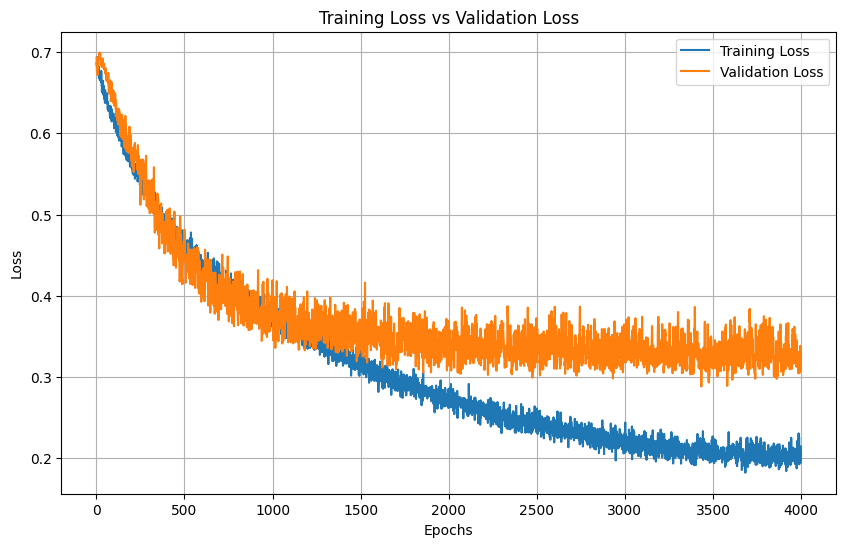

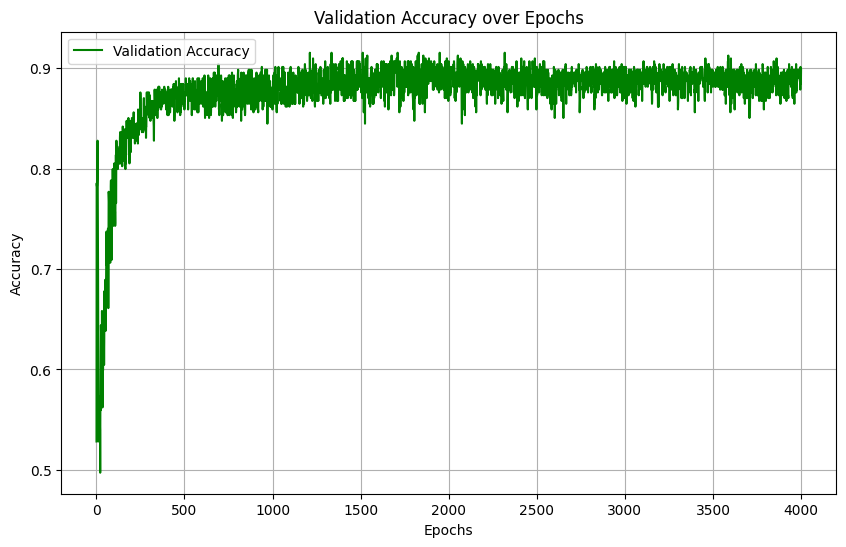

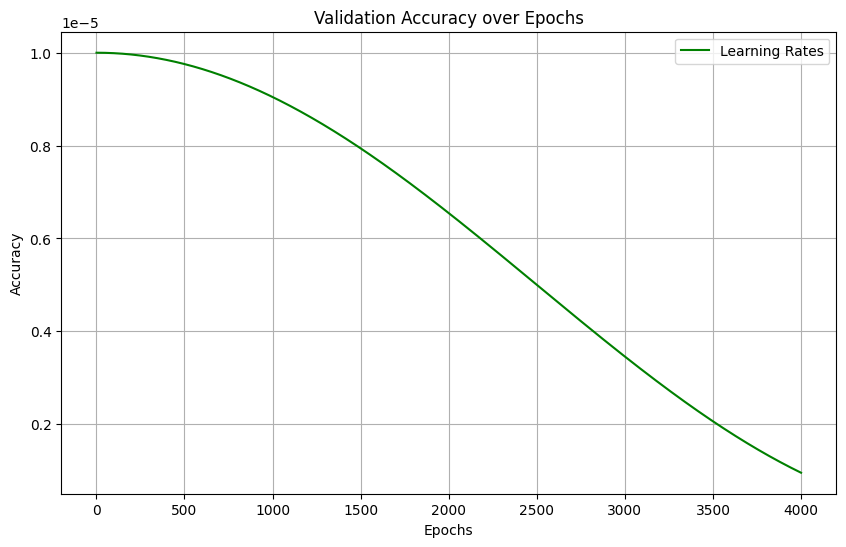

Model for bin 1 saved to GCNModels-5A_exp5/model_bin_1.pth
Training on bin 2/50
Bin 2, Epoch 1/4000, Train Loss: 0.7082, Validation Loss: 0.6877,  Accuracy: 0.7825, LR: 0.000010
Bin 2, Epoch 101/4000, Train Loss: 0.6173, Validation Loss: 0.6556,  Accuracy: 0.8136, LR: 0.000010
Bin 2, Epoch 201/4000, Train Loss: 0.5591, Validation Loss: 0.6149,  Accuracy: 0.8588, LR: 0.000010
Bin 2, Epoch 301/4000, Train Loss: 0.5062, Validation Loss: 0.5435,  Accuracy: 0.8757, LR: 0.000010
Bin 2, Epoch 401/4000, Train Loss: 0.4717, Validation Loss: 0.4677,  Accuracy: 0.8870, LR: 0.000010
Bin 2, Epoch 501/4000, Train Loss: 0.4373, Validation Loss: 0.4360,  Accuracy: 0.8898, LR: 0.000010
Bin 2, Epoch 601/4000, Train Loss: 0.4170, Validation Loss: 0.4038,  Accuracy: 0.9040, LR: 0.000010
Bin 2, Epoch 701/4000, Train Loss: 0.3999, Validation Loss: 0.4011,  Accuracy: 0.8983, LR: 0.000010
Bin 2, Epoch 801/4000, Train Loss: 0.3669, Validation Loss: 0.3872,  Accuracy: 0.8927, LR: 0.000009
Bin 2, Epoch 901/4000,

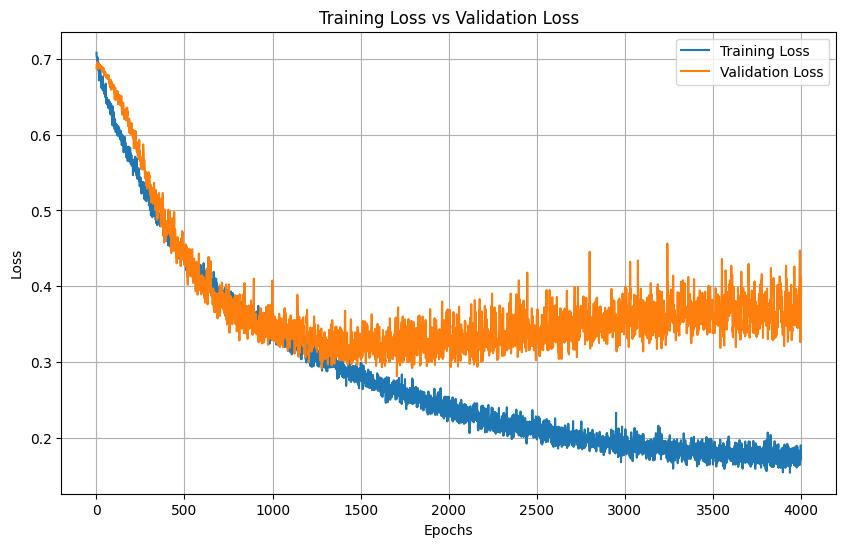

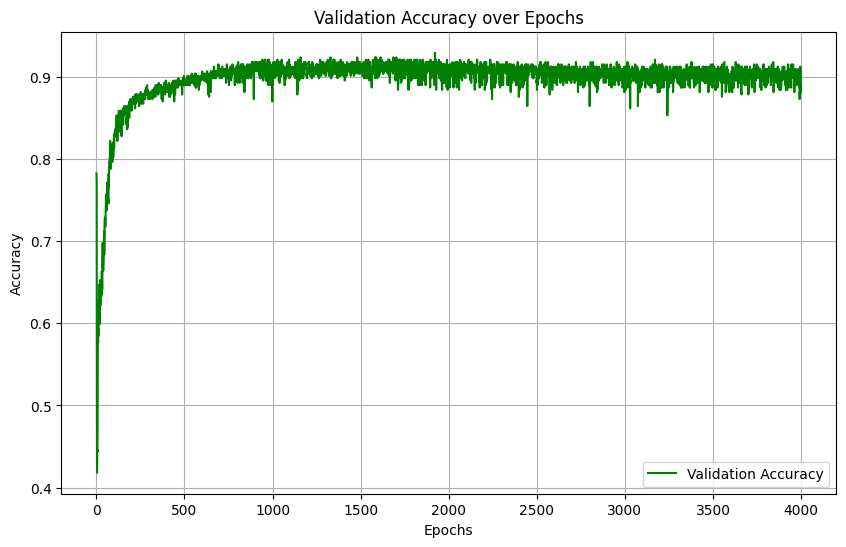

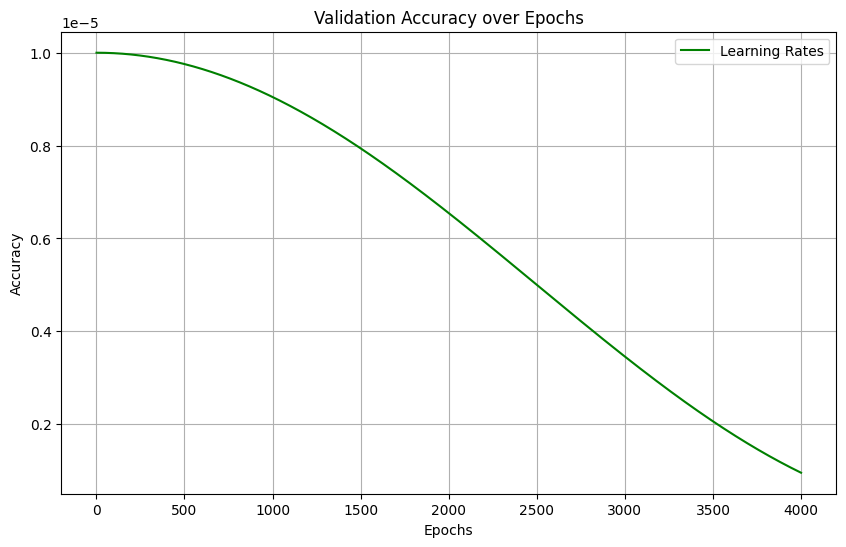

Model for bin 2 saved to GCNModels-5A_exp5/model_bin_2.pth
Training on bin 3/50
Bin 3, Epoch 1/4000, Train Loss: 0.6980, Validation Loss: 0.6982,  Accuracy: 0.2175, LR: 0.000010
Bin 3, Epoch 101/4000, Train Loss: 0.6366, Validation Loss: 0.6604,  Accuracy: 0.7458, LR: 0.000010
Bin 3, Epoch 201/4000, Train Loss: 0.5591, Validation Loss: 0.5546,  Accuracy: 0.8616, LR: 0.000010
Bin 3, Epoch 301/4000, Train Loss: 0.5186, Validation Loss: 0.5121,  Accuracy: 0.8672, LR: 0.000010
Bin 3, Epoch 401/4000, Train Loss: 0.4846, Validation Loss: 0.4544,  Accuracy: 0.8814, LR: 0.000010
Bin 3, Epoch 501/4000, Train Loss: 0.4444, Validation Loss: 0.4284,  Accuracy: 0.8729, LR: 0.000010
Bin 3, Epoch 601/4000, Train Loss: 0.4220, Validation Loss: 0.4049,  Accuracy: 0.8814, LR: 0.000010
Bin 3, Epoch 701/4000, Train Loss: 0.4086, Validation Loss: 0.4141,  Accuracy: 0.8672, LR: 0.000010
Bin 3, Epoch 801/4000, Train Loss: 0.3917, Validation Loss: 0.4011,  Accuracy: 0.8672, LR: 0.000009
Bin 3, Epoch 901/4000,

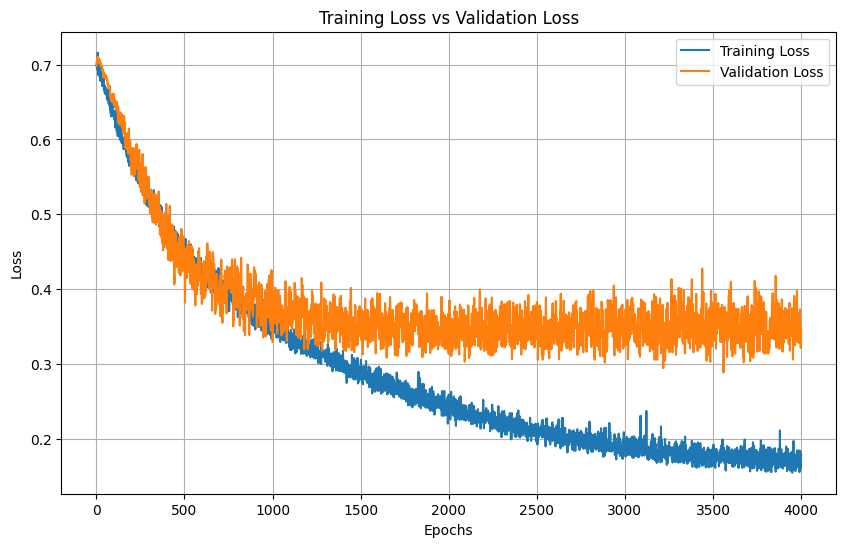

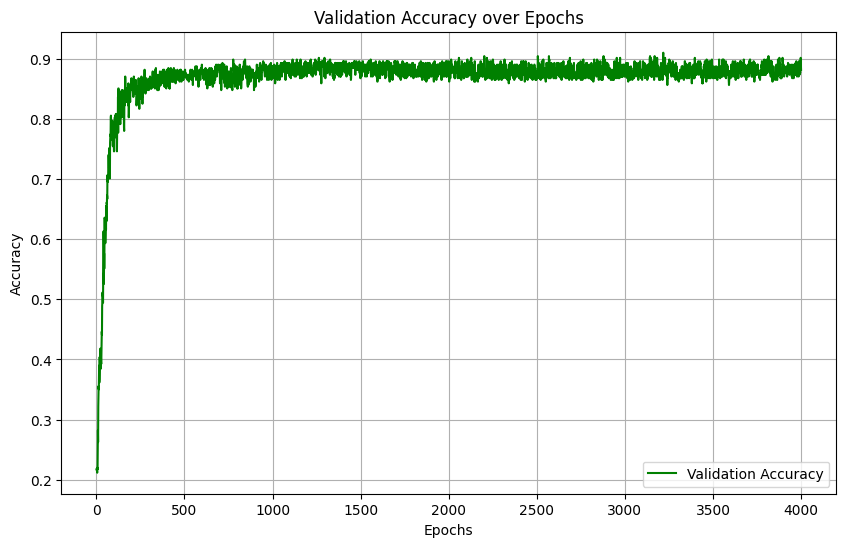

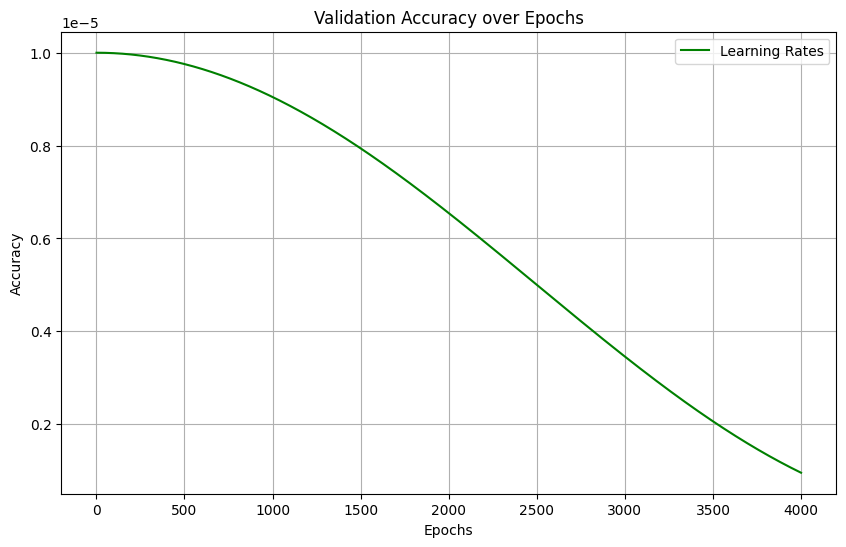

Model for bin 3 saved to GCNModels-5A_exp5/model_bin_3.pth
Training on bin 4/50
Bin 4, Epoch 1/4000, Train Loss: 0.7079, Validation Loss: 0.6894,  Accuracy: 0.7825, LR: 0.000010
Bin 4, Epoch 101/4000, Train Loss: 0.6380, Validation Loss: 0.6600,  Accuracy: 0.7655, LR: 0.000010
Bin 4, Epoch 201/4000, Train Loss: 0.6009, Validation Loss: 0.6025,  Accuracy: 0.8079, LR: 0.000010
Bin 4, Epoch 301/4000, Train Loss: 0.5362, Validation Loss: 0.5475,  Accuracy: 0.8305, LR: 0.000010
Bin 4, Epoch 401/4000, Train Loss: 0.5114, Validation Loss: 0.4787,  Accuracy: 0.8531, LR: 0.000010
Bin 4, Epoch 501/4000, Train Loss: 0.4854, Validation Loss: 0.4495,  Accuracy: 0.8531, LR: 0.000010
Bin 4, Epoch 601/4000, Train Loss: 0.4641, Validation Loss: 0.4489,  Accuracy: 0.8616, LR: 0.000010
Bin 4, Epoch 701/4000, Train Loss: 0.4252, Validation Loss: 0.4038,  Accuracy: 0.8672, LR: 0.000010
Bin 4, Epoch 801/4000, Train Loss: 0.3983, Validation Loss: 0.4011,  Accuracy: 0.8446, LR: 0.000009
Bin 4, Epoch 901/4000,

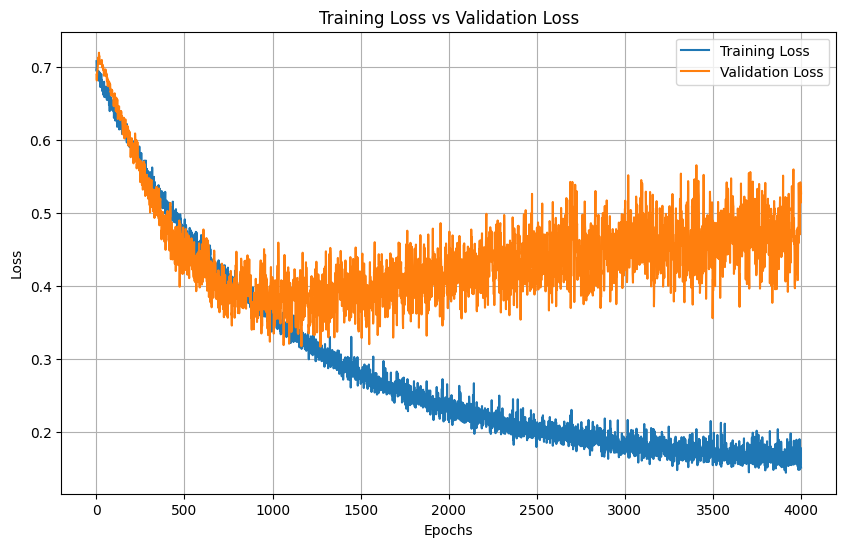

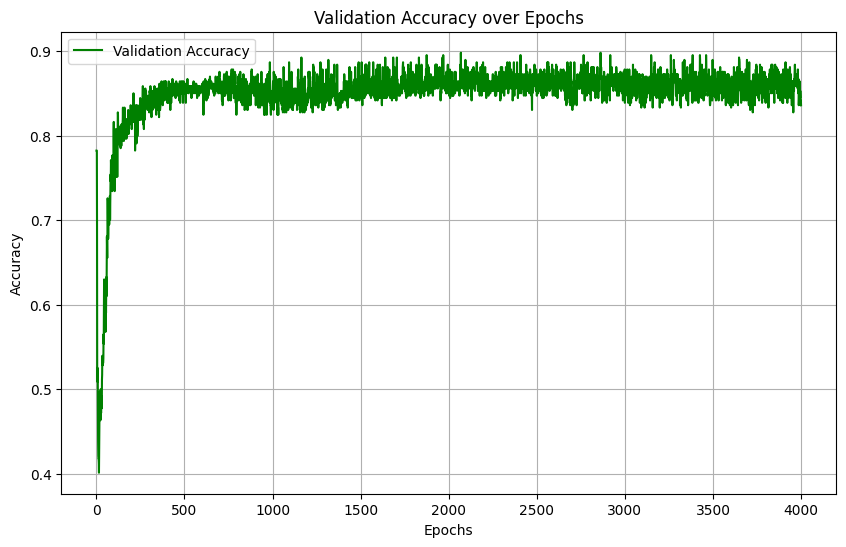

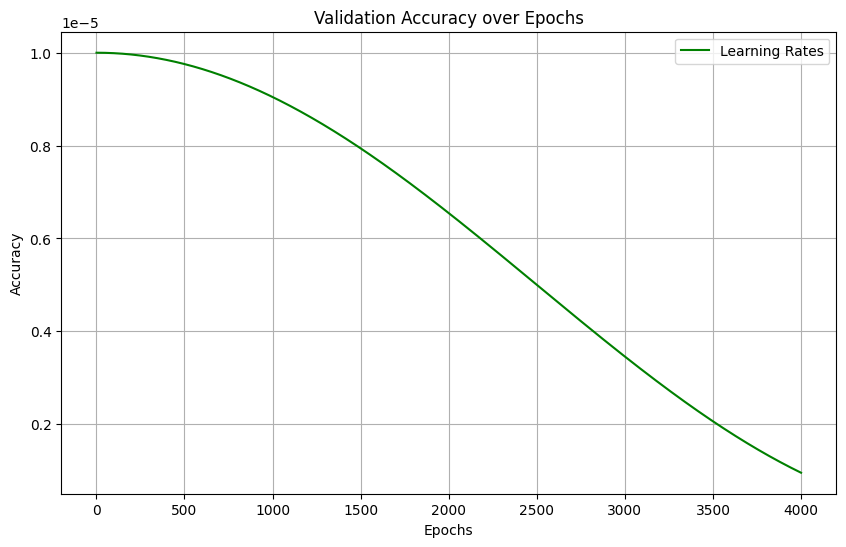

Model for bin 4 saved to GCNModels-5A_exp5/model_bin_4.pth
Training on bin 5/50
Bin 5, Epoch 1/4000, Train Loss: 0.6940, Validation Loss: 0.6764,  Accuracy: 0.7825, LR: 0.000010
Bin 5, Epoch 101/4000, Train Loss: 0.6231, Validation Loss: 0.6277,  Accuracy: 0.8390, LR: 0.000010
Bin 5, Epoch 201/4000, Train Loss: 0.5882, Validation Loss: 0.5774,  Accuracy: 0.8475, LR: 0.000010
Bin 5, Epoch 301/4000, Train Loss: 0.5427, Validation Loss: 0.5469,  Accuracy: 0.8475, LR: 0.000010
Bin 5, Epoch 401/4000, Train Loss: 0.4978, Validation Loss: 0.4559,  Accuracy: 0.8757, LR: 0.000010
Bin 5, Epoch 501/4000, Train Loss: 0.4773, Validation Loss: 0.4459,  Accuracy: 0.8785, LR: 0.000010
Bin 5, Epoch 601/4000, Train Loss: 0.4448, Validation Loss: 0.3955,  Accuracy: 0.8898, LR: 0.000010
Bin 5, Epoch 701/4000, Train Loss: 0.4341, Validation Loss: 0.4182,  Accuracy: 0.8842, LR: 0.000010
Bin 5, Epoch 801/4000, Train Loss: 0.4064, Validation Loss: 0.4231,  Accuracy: 0.8644, LR: 0.000009
Bin 5, Epoch 901/4000,

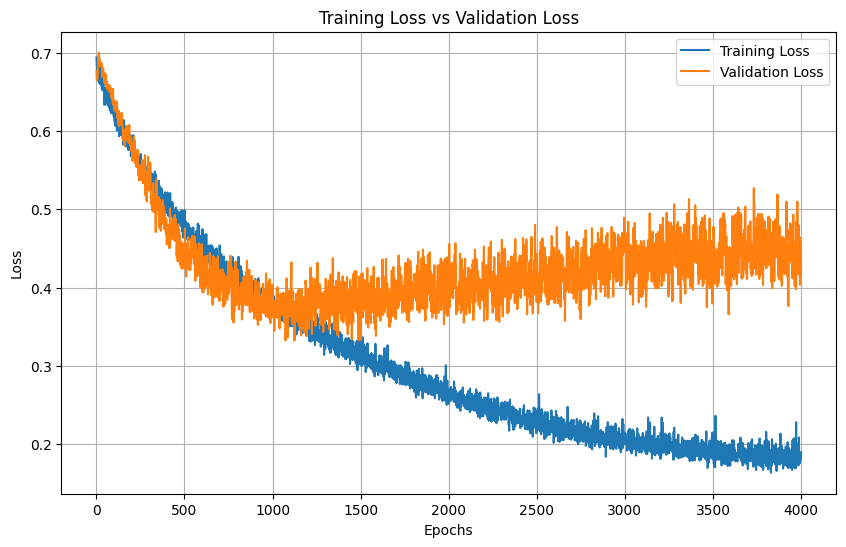

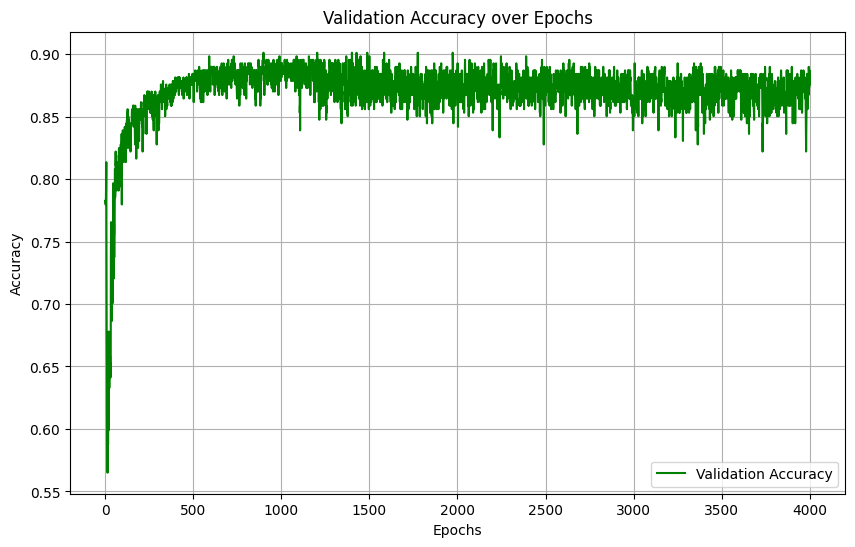

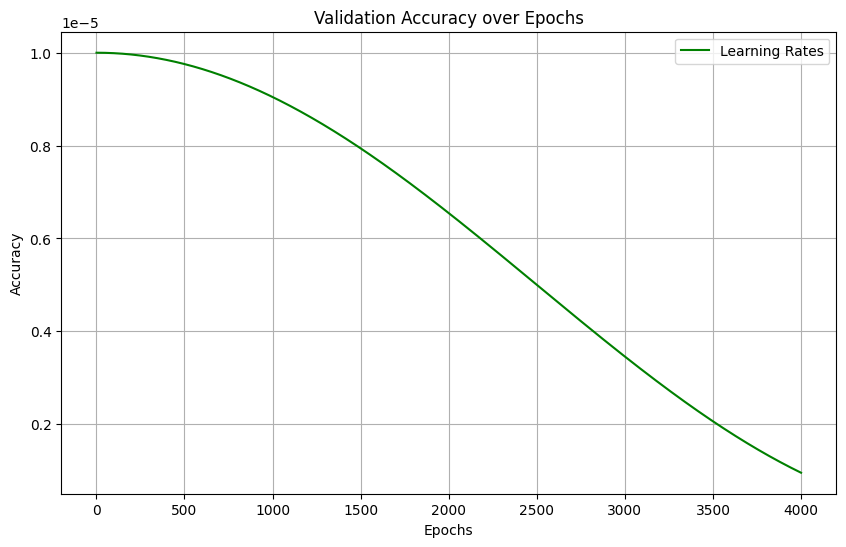

Model for bin 5 saved to GCNModels-5A_exp5/model_bin_5.pth
Training on bin 6/50
Bin 6, Epoch 1/4000, Train Loss: 0.6930, Validation Loss: 0.7126,  Accuracy: 0.2175, LR: 0.000010
Bin 6, Epoch 101/4000, Train Loss: 0.6368, Validation Loss: 0.6883,  Accuracy: 0.5791, LR: 0.000010
Bin 6, Epoch 201/4000, Train Loss: 0.5848, Validation Loss: 0.6341,  Accuracy: 0.7655, LR: 0.000010
Bin 6, Epoch 301/4000, Train Loss: 0.5418, Validation Loss: 0.5644,  Accuracy: 0.8192, LR: 0.000010
Bin 6, Epoch 401/4000, Train Loss: 0.5061, Validation Loss: 0.4775,  Accuracy: 0.8672, LR: 0.000010
Bin 6, Epoch 501/4000, Train Loss: 0.4616, Validation Loss: 0.4314,  Accuracy: 0.8785, LR: 0.000010
Bin 6, Epoch 601/4000, Train Loss: 0.4497, Validation Loss: 0.4087,  Accuracy: 0.8785, LR: 0.000010
Bin 6, Epoch 701/4000, Train Loss: 0.4204, Validation Loss: 0.3563,  Accuracy: 0.8927, LR: 0.000010
Bin 6, Epoch 801/4000, Train Loss: 0.3940, Validation Loss: 0.3445,  Accuracy: 0.8898, LR: 0.000009
Bin 6, Epoch 901/4000,

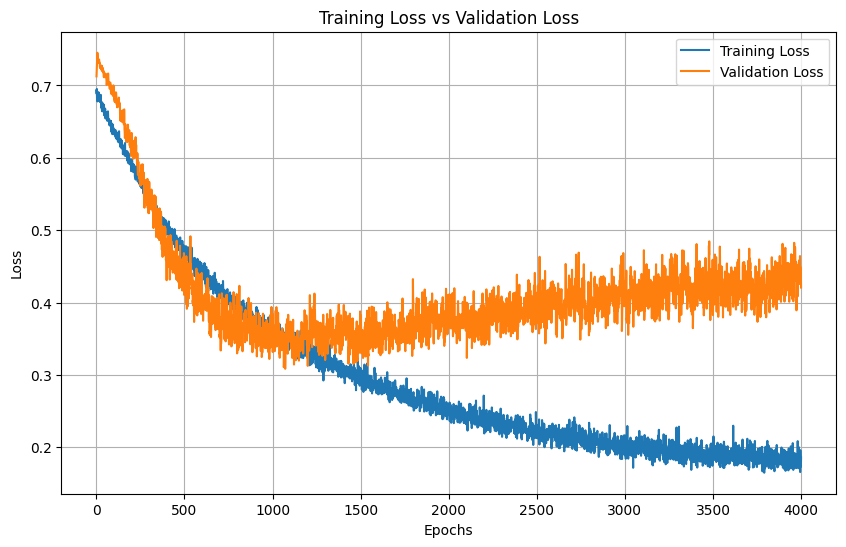

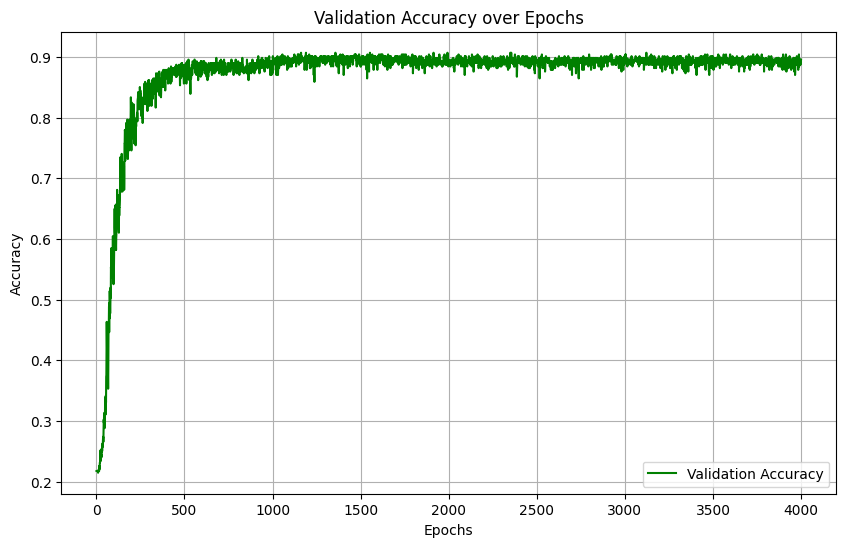

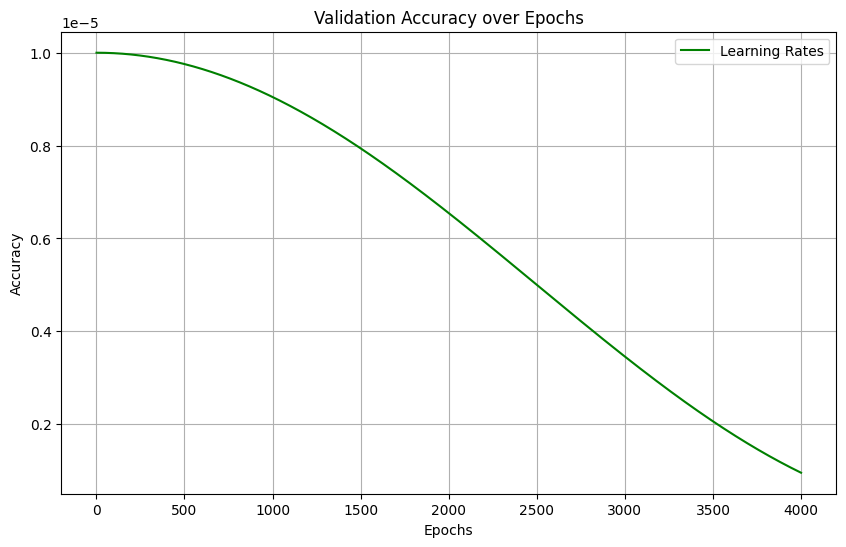

Model for bin 6 saved to GCNModels-5A_exp5/model_bin_6.pth
Training on bin 7/50
Bin 7, Epoch 1/4000, Train Loss: 0.7083, Validation Loss: 0.7304,  Accuracy: 0.2175, LR: 0.000010
Bin 7, Epoch 101/4000, Train Loss: 0.6177, Validation Loss: 0.6442,  Accuracy: 0.7712, LR: 0.000010
Bin 7, Epoch 201/4000, Train Loss: 0.5759, Validation Loss: 0.5633,  Accuracy: 0.8531, LR: 0.000010
Bin 7, Epoch 301/4000, Train Loss: 0.5236, Validation Loss: 0.4987,  Accuracy: 0.8588, LR: 0.000010
Bin 7, Epoch 401/4000, Train Loss: 0.5065, Validation Loss: 0.4649,  Accuracy: 0.8531, LR: 0.000010
Bin 7, Epoch 501/4000, Train Loss: 0.4615, Validation Loss: 0.4244,  Accuracy: 0.8644, LR: 0.000010
Bin 7, Epoch 601/4000, Train Loss: 0.4340, Validation Loss: 0.3910,  Accuracy: 0.8672, LR: 0.000010
Bin 7, Epoch 701/4000, Train Loss: 0.3984, Validation Loss: 0.3891,  Accuracy: 0.8559, LR: 0.000010
Bin 7, Epoch 801/4000, Train Loss: 0.3789, Validation Loss: 0.3839,  Accuracy: 0.8475, LR: 0.000009
Bin 7, Epoch 901/4000,

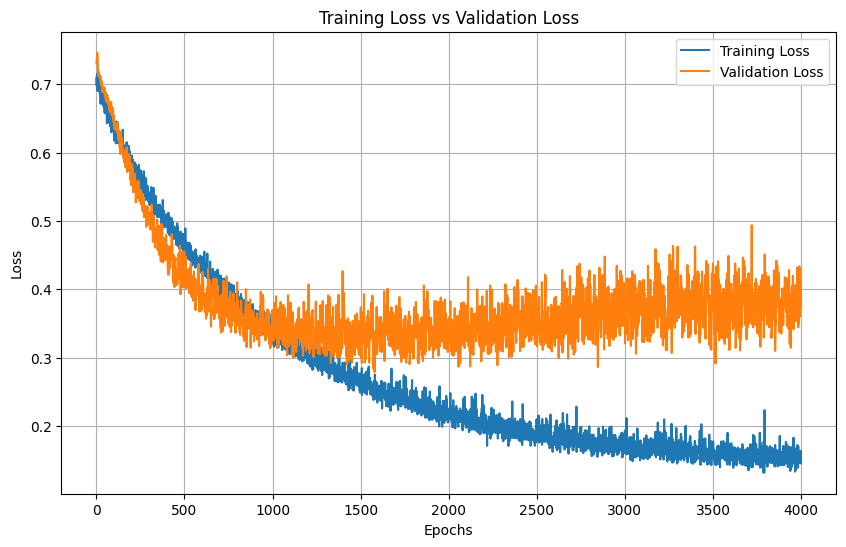

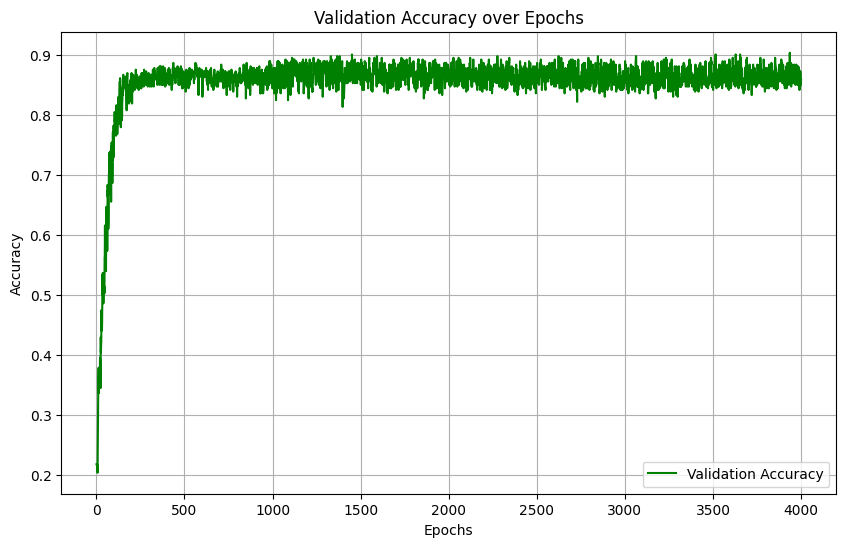

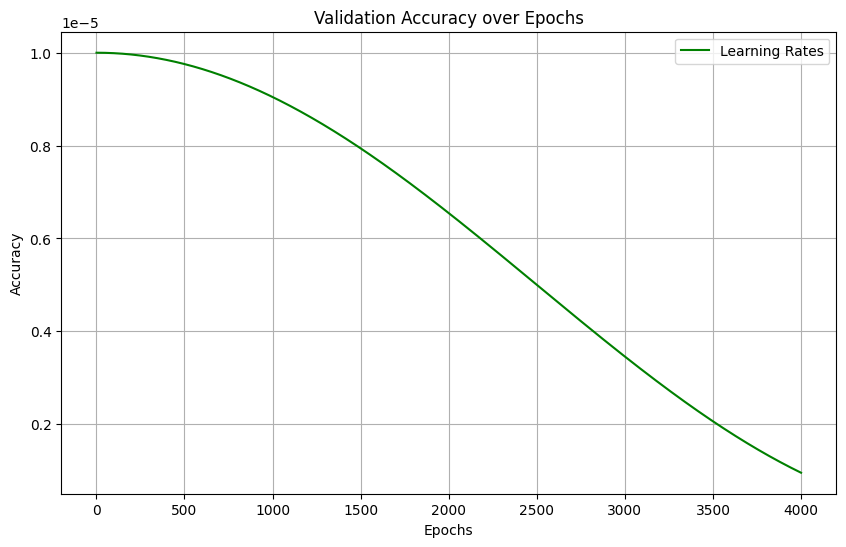

Model for bin 7 saved to GCNModels-5A_exp5/model_bin_7.pth
Training on bin 8/50
Bin 8, Epoch 1/4000, Train Loss: 0.7077, Validation Loss: 0.6939,  Accuracy: 0.2825, LR: 0.000010
Bin 8, Epoch 101/4000, Train Loss: 0.6368, Validation Loss: 0.6553,  Accuracy: 0.7740, LR: 0.000010
Bin 8, Epoch 201/4000, Train Loss: 0.5867, Validation Loss: 0.5805,  Accuracy: 0.8418, LR: 0.000010
Bin 8, Epoch 301/4000, Train Loss: 0.5365, Validation Loss: 0.5103,  Accuracy: 0.8672, LR: 0.000010
Bin 8, Epoch 401/4000, Train Loss: 0.4919, Validation Loss: 0.4378,  Accuracy: 0.8785, LR: 0.000010
Bin 8, Epoch 501/4000, Train Loss: 0.4430, Validation Loss: 0.4211,  Accuracy: 0.8785, LR: 0.000010
Bin 8, Epoch 601/4000, Train Loss: 0.4147, Validation Loss: 0.3858,  Accuracy: 0.8757, LR: 0.000010
Bin 8, Epoch 701/4000, Train Loss: 0.3852, Validation Loss: 0.3528,  Accuracy: 0.8814, LR: 0.000010
Bin 8, Epoch 801/4000, Train Loss: 0.3757, Validation Loss: 0.3185,  Accuracy: 0.8870, LR: 0.000009
Bin 8, Epoch 901/4000,

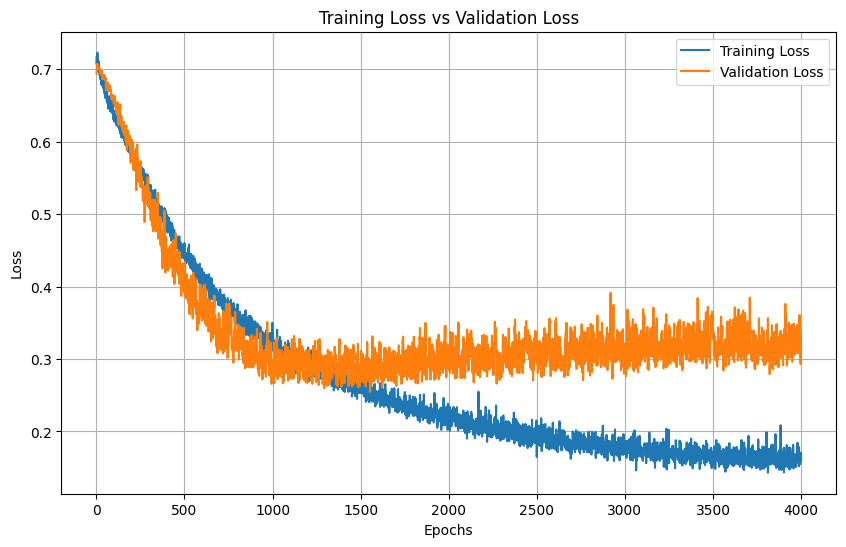

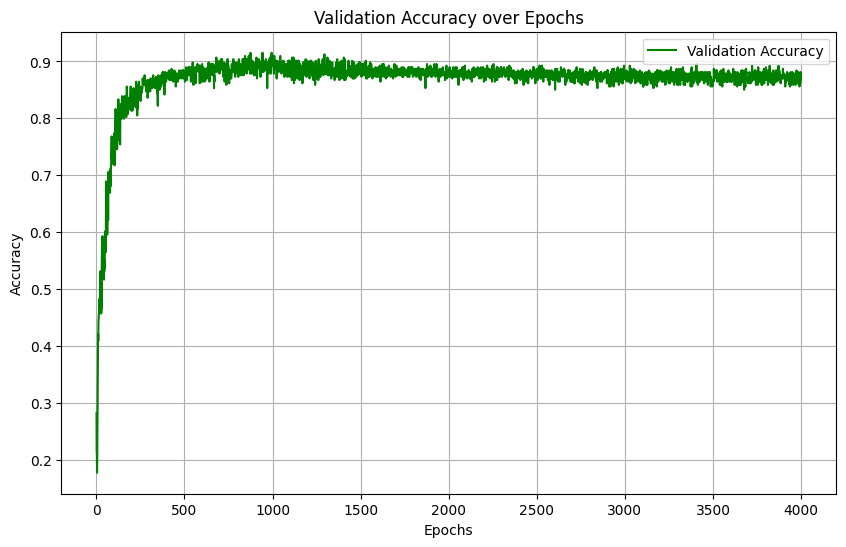

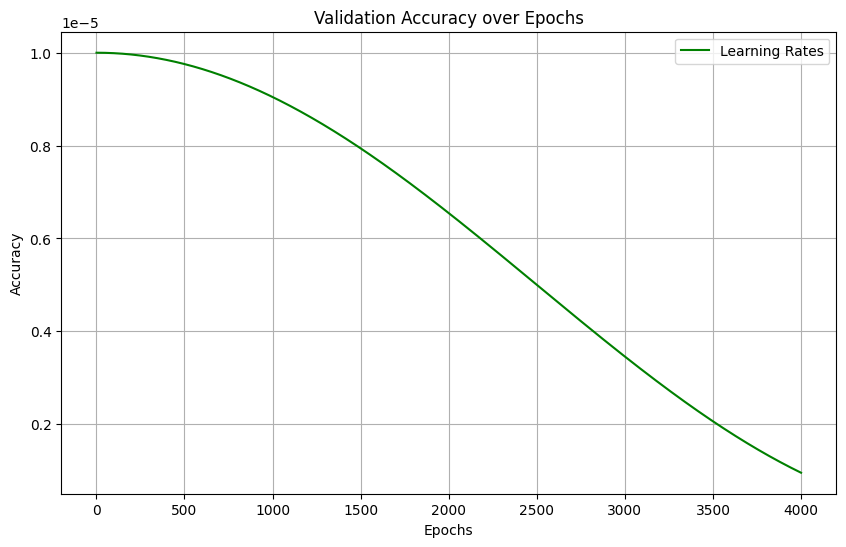

Model for bin 8 saved to GCNModels-5A_exp5/model_bin_8.pth
Training on bin 9/50
Bin 9, Epoch 1/4000, Train Loss: 0.6913, Validation Loss: 0.6912,  Accuracy: 0.7853, LR: 0.000010
Bin 9, Epoch 101/4000, Train Loss: 0.6011, Validation Loss: 0.6822,  Accuracy: 0.6638, LR: 0.000010
Bin 9, Epoch 201/4000, Train Loss: 0.5549, Validation Loss: 0.6240,  Accuracy: 0.8362, LR: 0.000010
Bin 9, Epoch 301/4000, Train Loss: 0.4975, Validation Loss: 0.5532,  Accuracy: 0.8729, LR: 0.000010
Bin 9, Epoch 401/4000, Train Loss: 0.4523, Validation Loss: 0.4937,  Accuracy: 0.8814, LR: 0.000010
Bin 9, Epoch 501/4000, Train Loss: 0.4107, Validation Loss: 0.4560,  Accuracy: 0.8814, LR: 0.000010
Bin 9, Epoch 601/4000, Train Loss: 0.3795, Validation Loss: 0.4706,  Accuracy: 0.8757, LR: 0.000010
Bin 9, Epoch 701/4000, Train Loss: 0.3495, Validation Loss: 0.4368,  Accuracy: 0.8842, LR: 0.000010
Bin 9, Epoch 801/4000, Train Loss: 0.3535, Validation Loss: 0.4251,  Accuracy: 0.8898, LR: 0.000009
Bin 9, Epoch 901/4000,

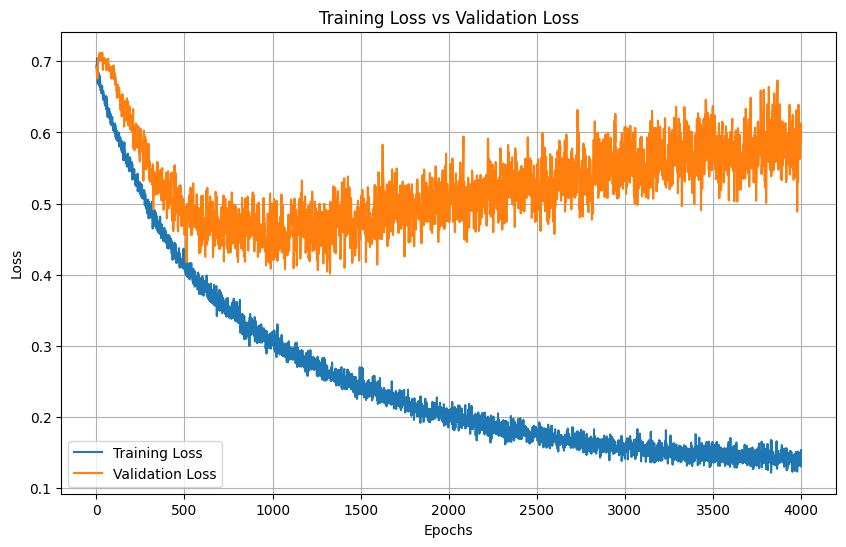

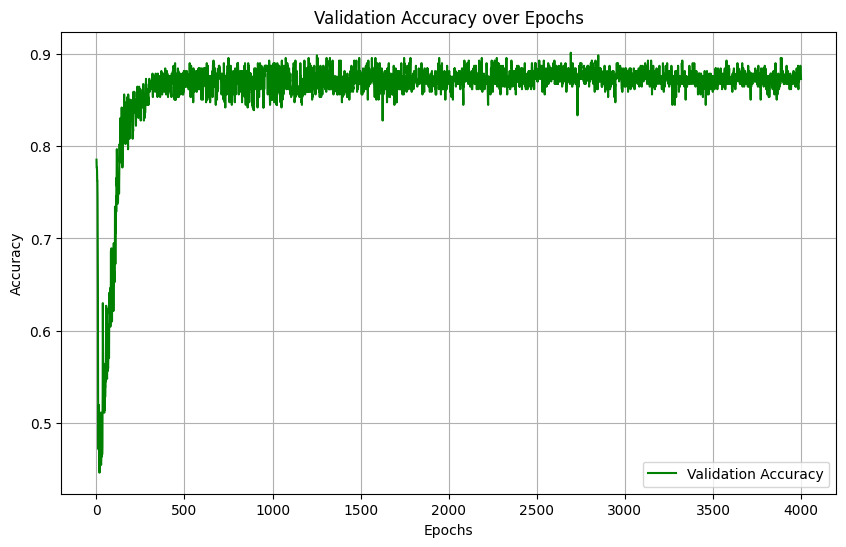

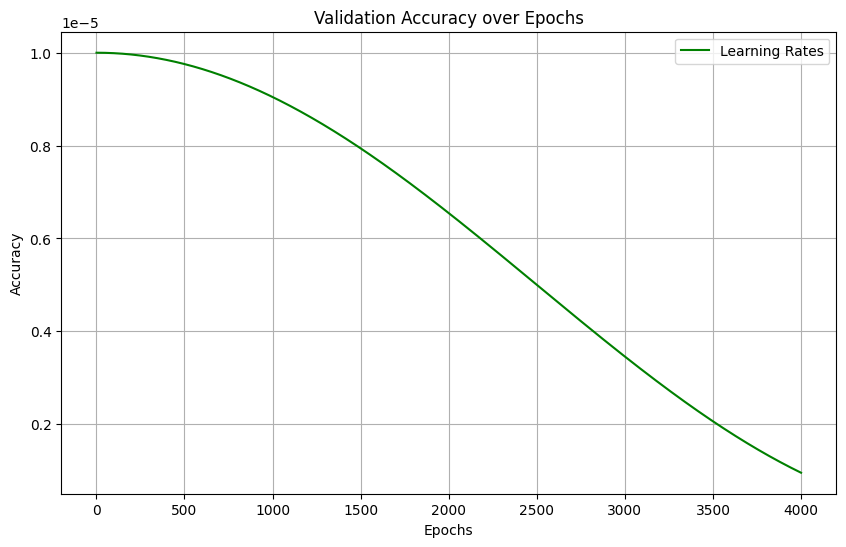

Model for bin 9 saved to GCNModels-5A_exp5/model_bin_9.pth
Training on bin 10/50
Bin 10, Epoch 1/4000, Train Loss: 0.7120, Validation Loss: 0.7252,  Accuracy: 0.2175, LR: 0.000010
Bin 10, Epoch 101/4000, Train Loss: 0.6043, Validation Loss: 0.6497,  Accuracy: 0.7345, LR: 0.000010
Bin 10, Epoch 201/4000, Train Loss: 0.5320, Validation Loss: 0.5986,  Accuracy: 0.7825, LR: 0.000010
Bin 10, Epoch 301/4000, Train Loss: 0.4918, Validation Loss: 0.4801,  Accuracy: 0.8588, LR: 0.000010
Bin 10, Epoch 401/4000, Train Loss: 0.4325, Validation Loss: 0.4564,  Accuracy: 0.8588, LR: 0.000010
Bin 10, Epoch 501/4000, Train Loss: 0.4044, Validation Loss: 0.4342,  Accuracy: 0.8616, LR: 0.000010
Bin 10, Epoch 601/4000, Train Loss: 0.3837, Validation Loss: 0.3871,  Accuracy: 0.8842, LR: 0.000010
Bin 10, Epoch 701/4000, Train Loss: 0.3495, Validation Loss: 0.3951,  Accuracy: 0.8785, LR: 0.000010
Bin 10, Epoch 801/4000, Train Loss: 0.3263, Validation Loss: 0.3906,  Accuracy: 0.8672, LR: 0.000009
Bin 10, Epoc

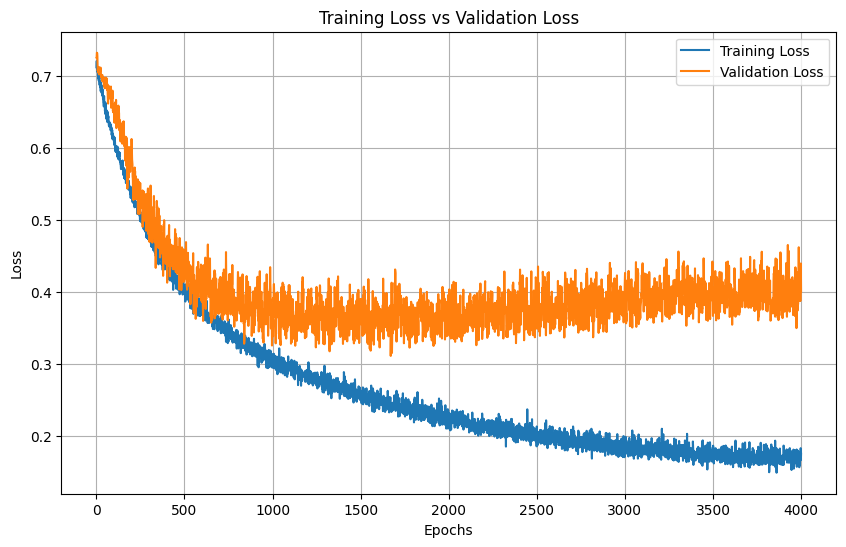

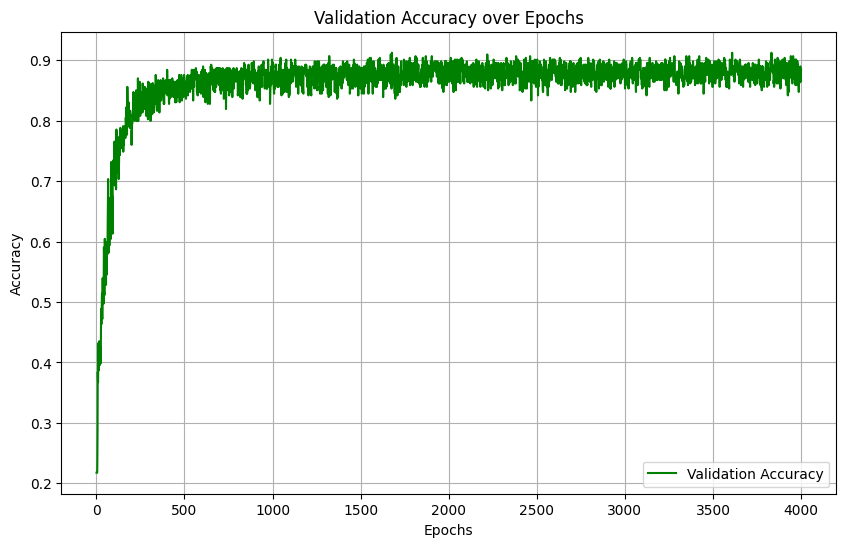

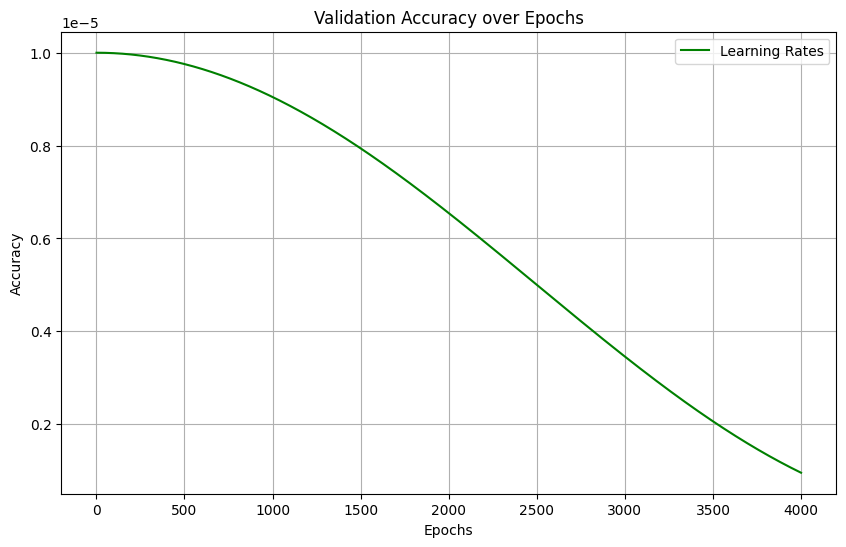

Model for bin 10 saved to GCNModels-5A_exp5/model_bin_10.pth
Training on bin 11/50
Bin 11, Epoch 1/4000, Train Loss: 0.6961, Validation Loss: 0.7201,  Accuracy: 0.2175, LR: 0.000010
Bin 11, Epoch 101/4000, Train Loss: 0.6004, Validation Loss: 0.6385,  Accuracy: 0.7910, LR: 0.000010
Bin 11, Epoch 201/4000, Train Loss: 0.5358, Validation Loss: 0.6291,  Accuracy: 0.7514, LR: 0.000010
Bin 11, Epoch 301/4000, Train Loss: 0.4708, Validation Loss: 0.5138,  Accuracy: 0.8531, LR: 0.000010
Bin 11, Epoch 401/4000, Train Loss: 0.4173, Validation Loss: 0.4487,  Accuracy: 0.8729, LR: 0.000010
Bin 11, Epoch 501/4000, Train Loss: 0.3882, Validation Loss: 0.4181,  Accuracy: 0.8870, LR: 0.000010
Bin 11, Epoch 601/4000, Train Loss: 0.3559, Validation Loss: 0.4002,  Accuracy: 0.8898, LR: 0.000010
Bin 11, Epoch 701/4000, Train Loss: 0.3377, Validation Loss: 0.3867,  Accuracy: 0.8983, LR: 0.000010
Bin 11, Epoch 801/4000, Train Loss: 0.3196, Validation Loss: 0.3983,  Accuracy: 0.8842, LR: 0.000009
Bin 11, Ep

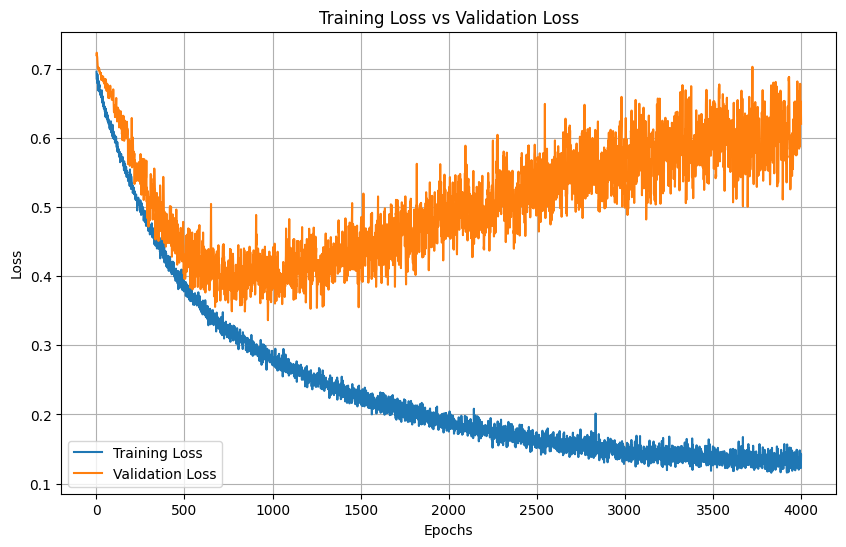

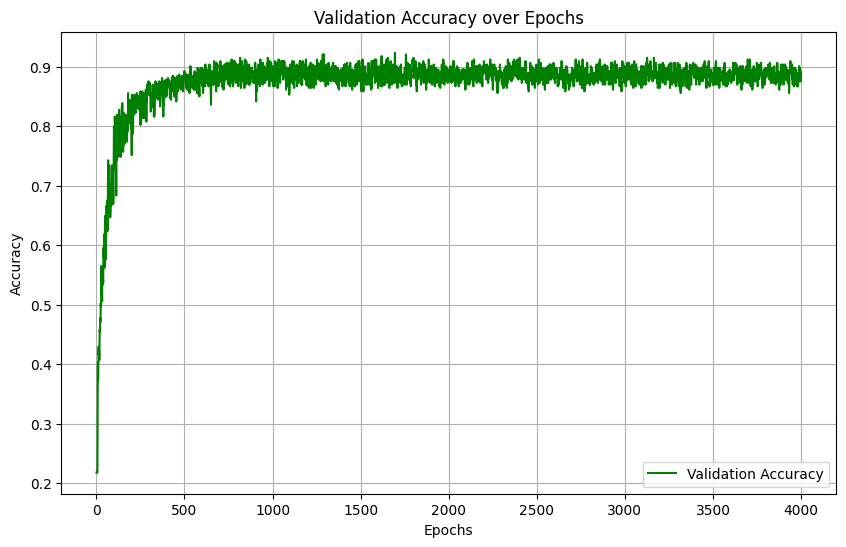

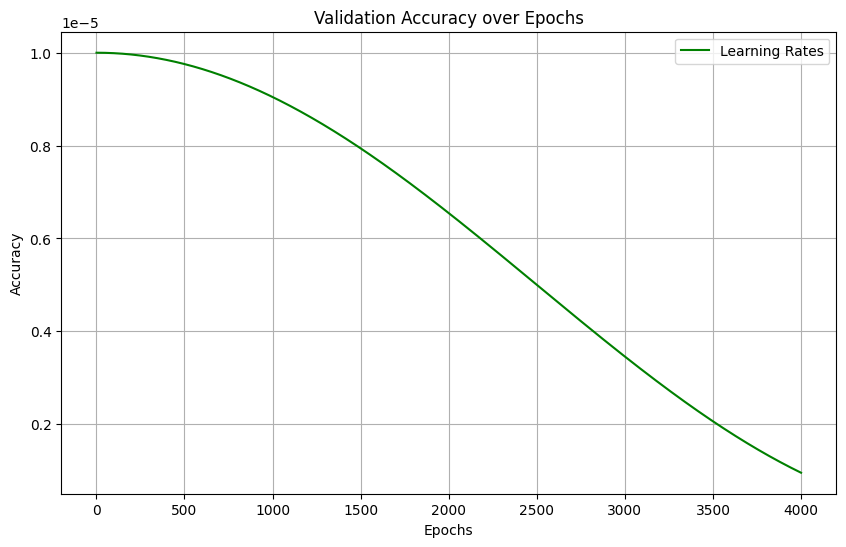

Model for bin 11 saved to GCNModels-5A_exp5/model_bin_11.pth
Training on bin 12/50
Bin 12, Epoch 1/4000, Train Loss: 0.7000, Validation Loss: 0.6808,  Accuracy: 0.7825, LR: 0.000010
Bin 12, Epoch 101/4000, Train Loss: 0.6105, Validation Loss: 0.6023,  Accuracy: 0.8136, LR: 0.000010
Bin 12, Epoch 201/4000, Train Loss: 0.5527, Validation Loss: 0.5106,  Accuracy: 0.8503, LR: 0.000010
Bin 12, Epoch 301/4000, Train Loss: 0.5105, Validation Loss: 0.4320,  Accuracy: 0.8616, LR: 0.000010
Bin 12, Epoch 401/4000, Train Loss: 0.4672, Validation Loss: 0.4105,  Accuracy: 0.8644, LR: 0.000010
Bin 12, Epoch 501/4000, Train Loss: 0.4165, Validation Loss: 0.3676,  Accuracy: 0.8701, LR: 0.000010
Bin 12, Epoch 601/4000, Train Loss: 0.3772, Validation Loss: 0.3542,  Accuracy: 0.8588, LR: 0.000010
Bin 12, Epoch 701/4000, Train Loss: 0.3653, Validation Loss: 0.3291,  Accuracy: 0.8729, LR: 0.000010
Bin 12, Epoch 801/4000, Train Loss: 0.3411, Validation Loss: 0.3319,  Accuracy: 0.8475, LR: 0.000009
Bin 12, Ep

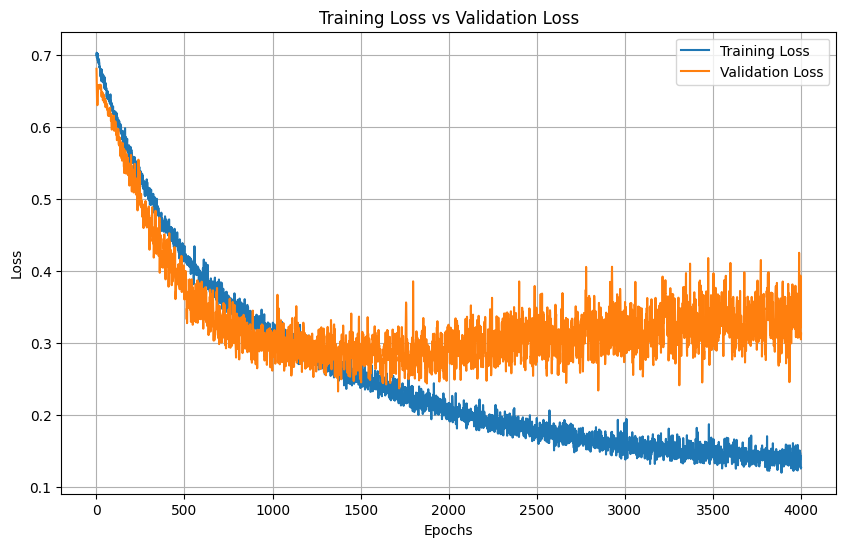

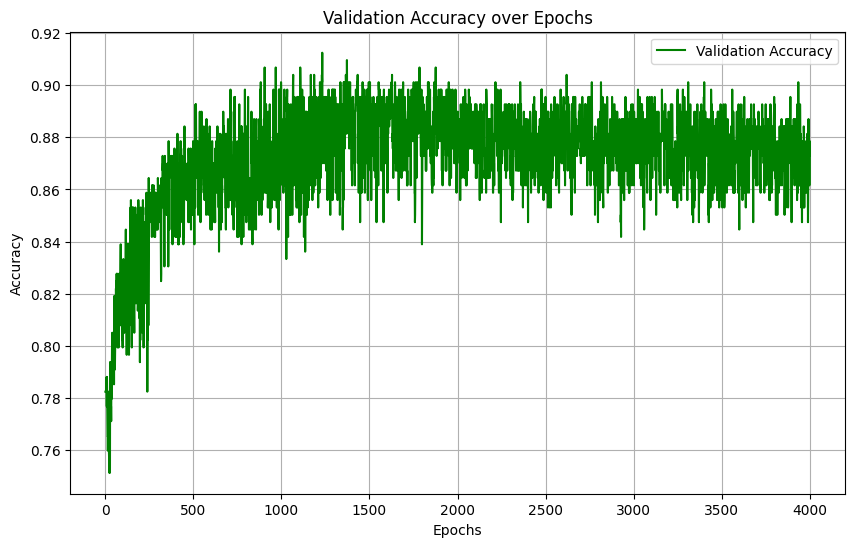

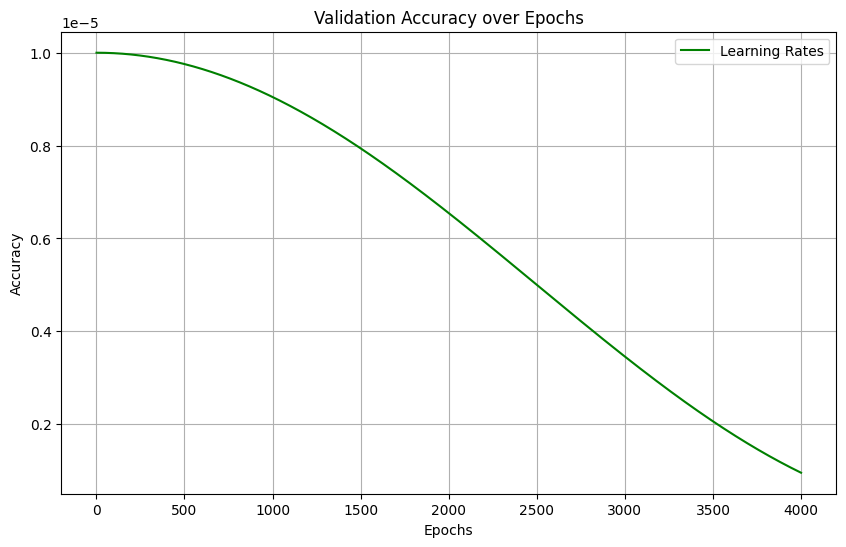

Model for bin 12 saved to GCNModels-5A_exp5/model_bin_12.pth
Training on bin 13/50
Bin 13, Epoch 1/4000, Train Loss: 0.6984, Validation Loss: 0.7116,  Accuracy: 0.2175, LR: 0.000010
Bin 13, Epoch 101/4000, Train Loss: 0.6157, Validation Loss: 0.6438,  Accuracy: 0.7542, LR: 0.000010
Bin 13, Epoch 201/4000, Train Loss: 0.5557, Validation Loss: 0.5765,  Accuracy: 0.8362, LR: 0.000010
Bin 13, Epoch 301/4000, Train Loss: 0.5085, Validation Loss: 0.5072,  Accuracy: 0.8588, LR: 0.000010
Bin 13, Epoch 401/4000, Train Loss: 0.4602, Validation Loss: 0.4678,  Accuracy: 0.8559, LR: 0.000010
Bin 13, Epoch 501/4000, Train Loss: 0.4266, Validation Loss: 0.4654,  Accuracy: 0.8446, LR: 0.000010
Bin 13, Epoch 601/4000, Train Loss: 0.3935, Validation Loss: 0.4351,  Accuracy: 0.8503, LR: 0.000010
Bin 13, Epoch 701/4000, Train Loss: 0.3591, Validation Loss: 0.3842,  Accuracy: 0.8814, LR: 0.000010
Bin 13, Epoch 801/4000, Train Loss: 0.3372, Validation Loss: 0.3435,  Accuracy: 0.8814, LR: 0.000009
Bin 13, Ep

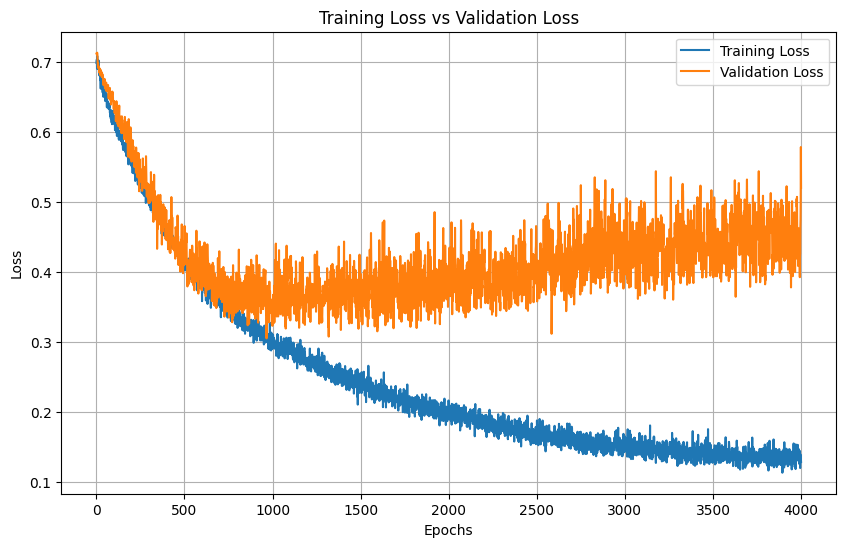

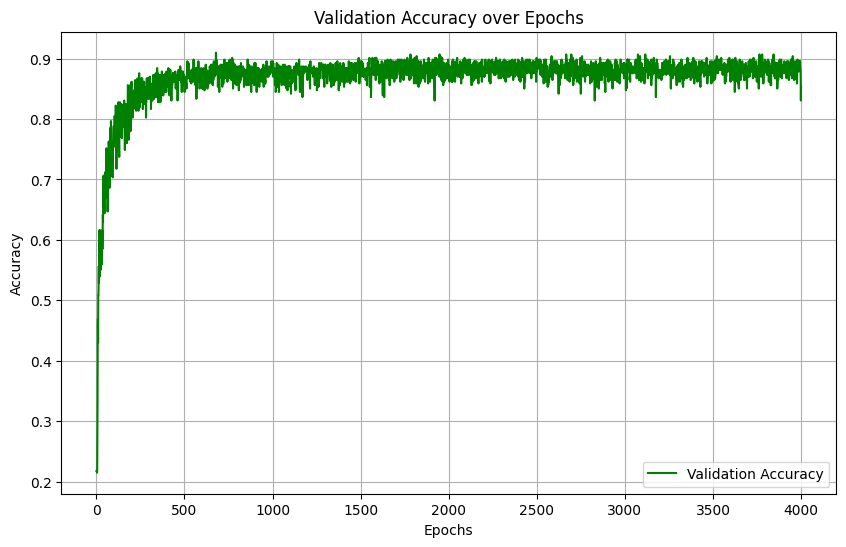

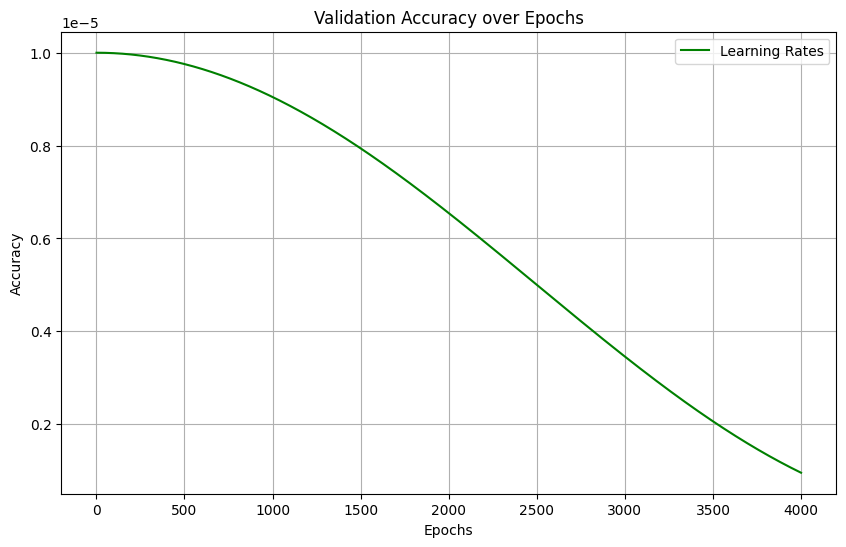

Model for bin 13 saved to GCNModels-5A_exp5/model_bin_13.pth
Training on bin 14/50
Bin 14, Epoch 1/4000, Train Loss: 0.7017, Validation Loss: 0.6778,  Accuracy: 0.7825, LR: 0.000010
Bin 14, Epoch 101/4000, Train Loss: 0.6062, Validation Loss: 0.6230,  Accuracy: 0.8107, LR: 0.000010
Bin 14, Epoch 201/4000, Train Loss: 0.5491, Validation Loss: 0.5532,  Accuracy: 0.8503, LR: 0.000010
Bin 14, Epoch 301/4000, Train Loss: 0.4938, Validation Loss: 0.4724,  Accuracy: 0.8588, LR: 0.000010
Bin 14, Epoch 401/4000, Train Loss: 0.4525, Validation Loss: 0.4301,  Accuracy: 0.8672, LR: 0.000010
Bin 14, Epoch 501/4000, Train Loss: 0.4210, Validation Loss: 0.3763,  Accuracy: 0.8814, LR: 0.000010
Bin 14, Epoch 601/4000, Train Loss: 0.3935, Validation Loss: 0.3663,  Accuracy: 0.8842, LR: 0.000010
Bin 14, Epoch 701/4000, Train Loss: 0.3639, Validation Loss: 0.3579,  Accuracy: 0.8842, LR: 0.000010
Bin 14, Epoch 801/4000, Train Loss: 0.3406, Validation Loss: 0.3604,  Accuracy: 0.8729, LR: 0.000009
Bin 14, Ep

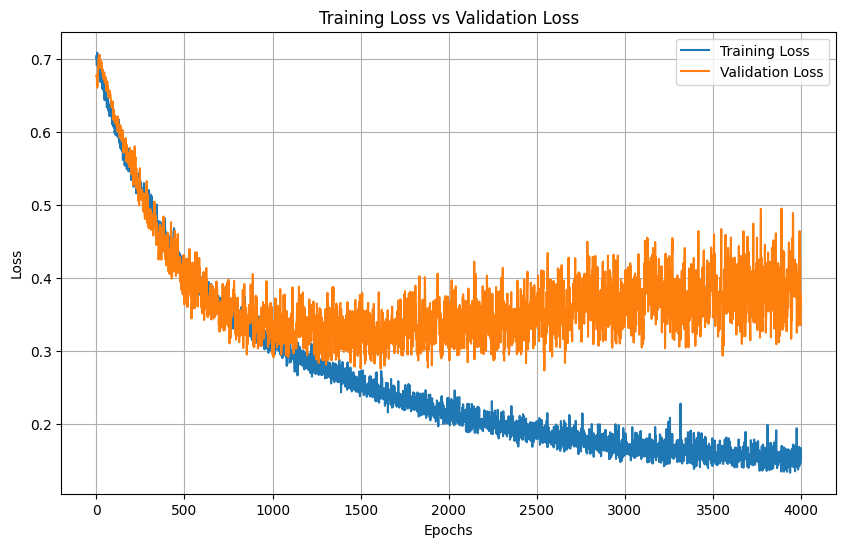

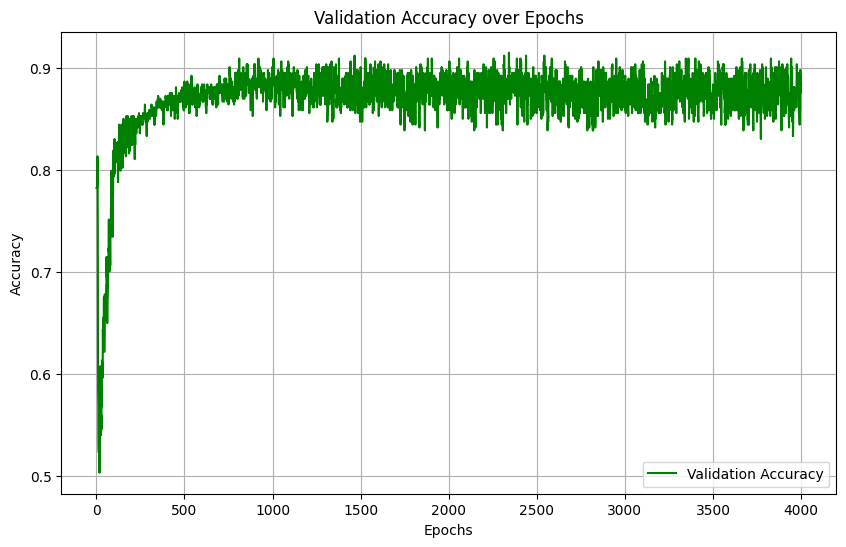

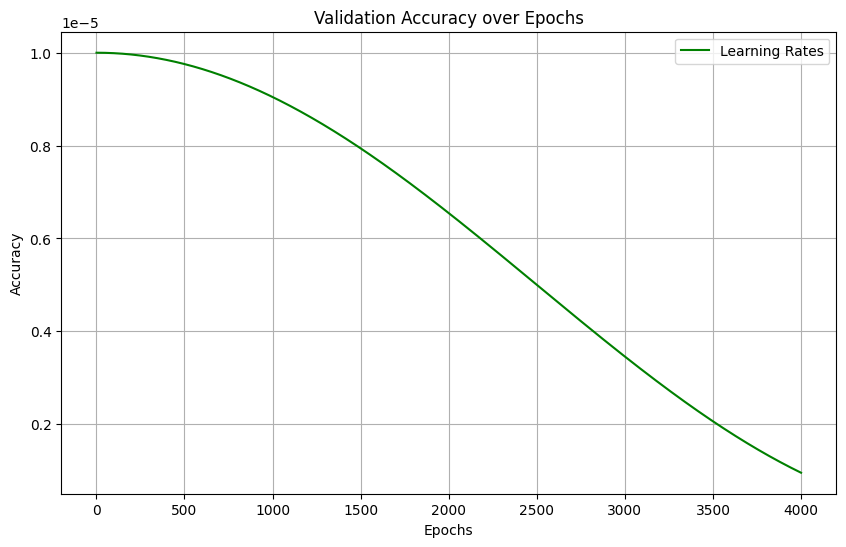

Model for bin 14 saved to GCNModels-5A_exp5/model_bin_14.pth
Training on bin 15/50
Bin 15, Epoch 1/4000, Train Loss: 0.6842, Validation Loss: 0.7143,  Accuracy: 0.2175, LR: 0.000010
Bin 15, Epoch 101/4000, Train Loss: 0.6192, Validation Loss: 0.6689,  Accuracy: 0.7316, LR: 0.000010
Bin 15, Epoch 201/4000, Train Loss: 0.5711, Validation Loss: 0.5988,  Accuracy: 0.8277, LR: 0.000010
Bin 15, Epoch 301/4000, Train Loss: 0.5163, Validation Loss: 0.5151,  Accuracy: 0.8644, LR: 0.000010
Bin 15, Epoch 401/4000, Train Loss: 0.4891, Validation Loss: 0.4826,  Accuracy: 0.8729, LR: 0.000010
Bin 15, Epoch 501/4000, Train Loss: 0.4273, Validation Loss: 0.4642,  Accuracy: 0.8701, LR: 0.000010
Bin 15, Epoch 601/4000, Train Loss: 0.4053, Validation Loss: 0.4120,  Accuracy: 0.8785, LR: 0.000010
Bin 15, Epoch 701/4000, Train Loss: 0.3746, Validation Loss: 0.4007,  Accuracy: 0.8757, LR: 0.000010
Bin 15, Epoch 801/4000, Train Loss: 0.3649, Validation Loss: 0.3894,  Accuracy: 0.8842, LR: 0.000009
Bin 15, Ep

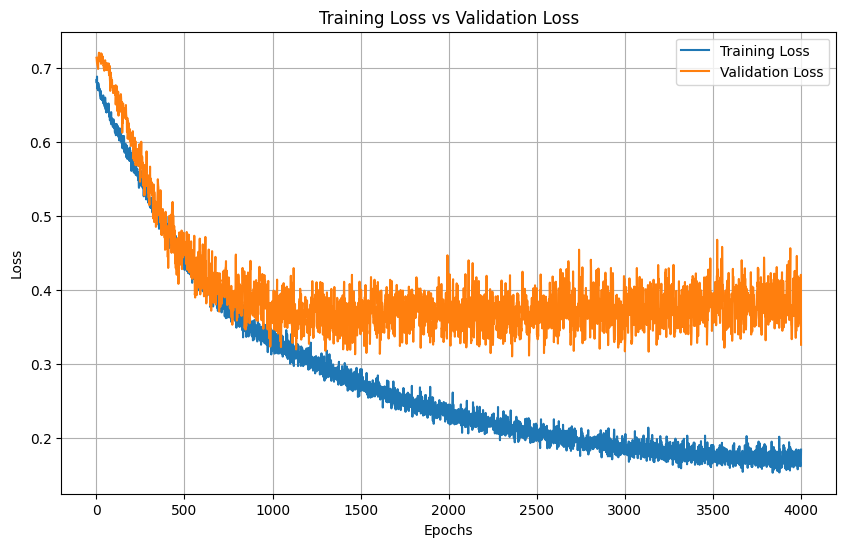

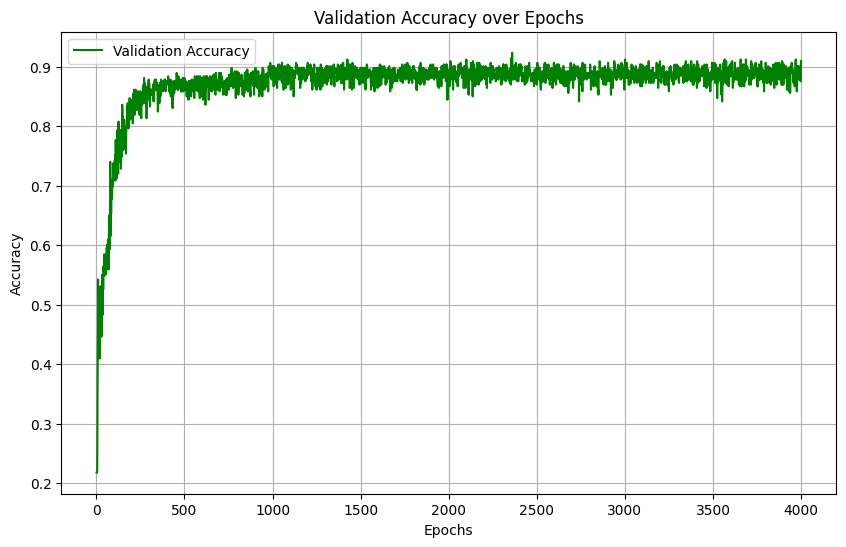

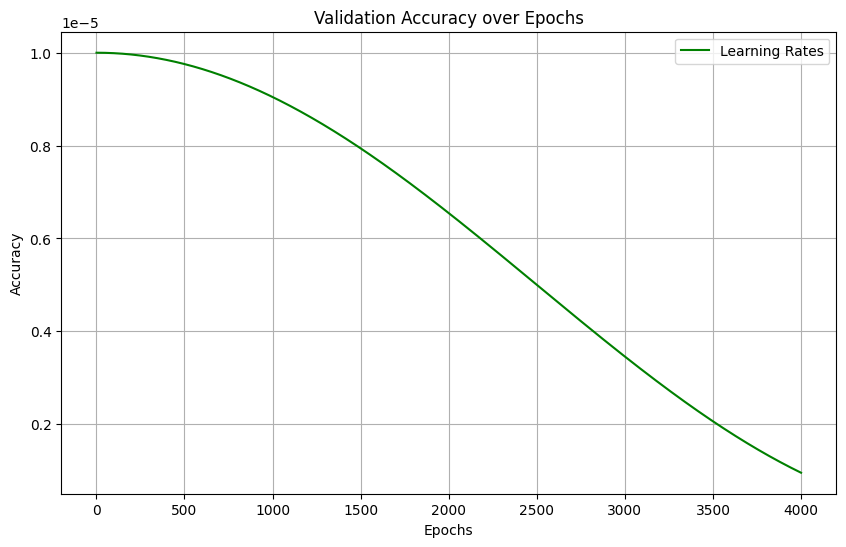

Model for bin 15 saved to GCNModels-5A_exp5/model_bin_15.pth
Training on bin 16/50
Bin 16, Epoch 1/4000, Train Loss: 0.7324, Validation Loss: 0.6708,  Accuracy: 0.7825, LR: 0.000010
Bin 16, Epoch 101/4000, Train Loss: 0.6245, Validation Loss: 0.6105,  Accuracy: 0.8475, LR: 0.000010
Bin 16, Epoch 201/4000, Train Loss: 0.5722, Validation Loss: 0.5404,  Accuracy: 0.8870, LR: 0.000010
Bin 16, Epoch 301/4000, Train Loss: 0.5065, Validation Loss: 0.5295,  Accuracy: 0.8192, LR: 0.000010
Bin 16, Epoch 401/4000, Train Loss: 0.4574, Validation Loss: 0.4100,  Accuracy: 0.8898, LR: 0.000010
Bin 16, Epoch 501/4000, Train Loss: 0.4301, Validation Loss: 0.3824,  Accuracy: 0.8927, LR: 0.000010
Bin 16, Epoch 601/4000, Train Loss: 0.3965, Validation Loss: 0.3814,  Accuracy: 0.8814, LR: 0.000010
Bin 16, Epoch 701/4000, Train Loss: 0.3962, Validation Loss: 0.3436,  Accuracy: 0.8927, LR: 0.000010
Bin 16, Epoch 801/4000, Train Loss: 0.3585, Validation Loss: 0.3363,  Accuracy: 0.8955, LR: 0.000009
Bin 16, Ep

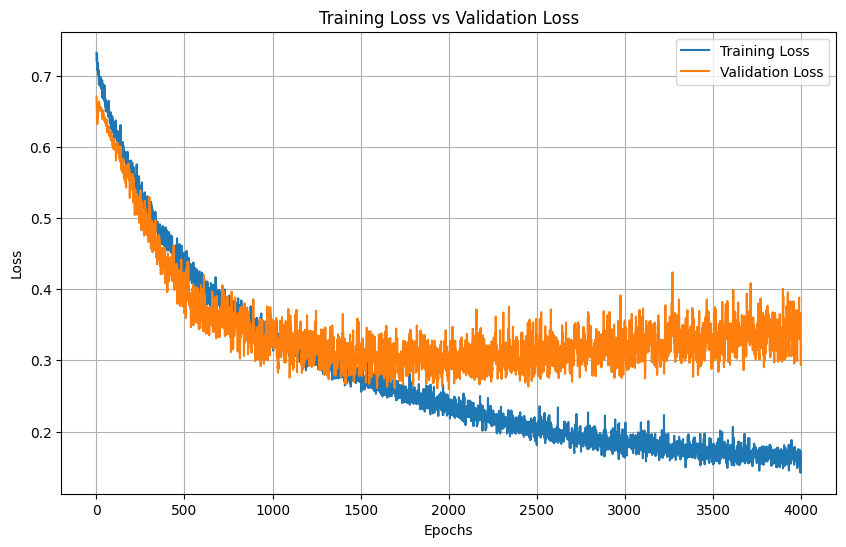

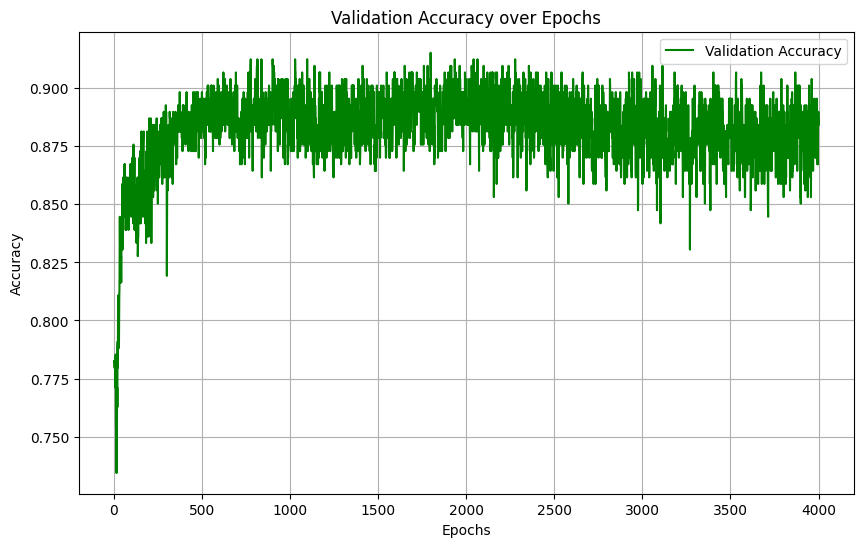

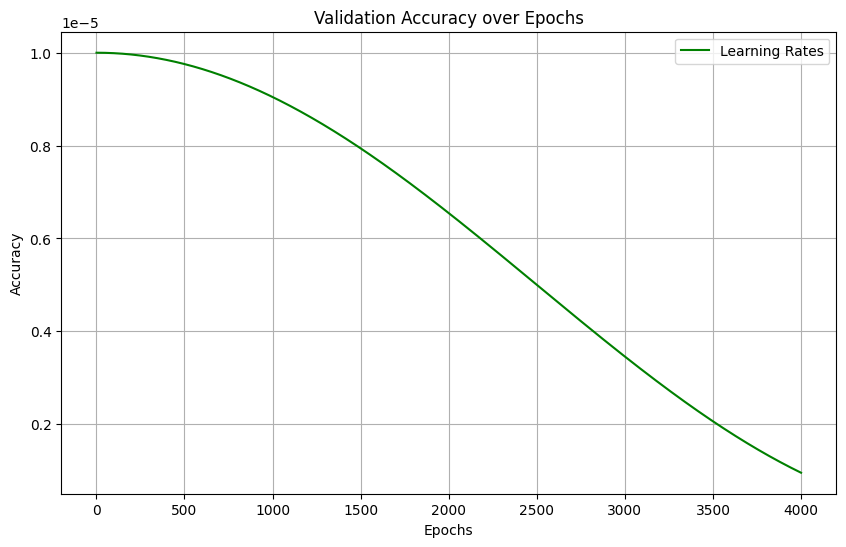

Model for bin 16 saved to GCNModels-5A_exp5/model_bin_16.pth
Training on bin 17/50
Bin 17, Epoch 1/4000, Train Loss: 0.7050, Validation Loss: 0.6741,  Accuracy: 0.7825, LR: 0.000010
Bin 17, Epoch 101/4000, Train Loss: 0.6158, Validation Loss: 0.6147,  Accuracy: 0.8362, LR: 0.000010
Bin 17, Epoch 201/4000, Train Loss: 0.5431, Validation Loss: 0.5647,  Accuracy: 0.8503, LR: 0.000010
Bin 17, Epoch 301/4000, Train Loss: 0.4732, Validation Loss: 0.4864,  Accuracy: 0.8616, LR: 0.000010
Bin 17, Epoch 401/4000, Train Loss: 0.4330, Validation Loss: 0.4421,  Accuracy: 0.8672, LR: 0.000010
Bin 17, Epoch 501/4000, Train Loss: 0.4017, Validation Loss: 0.4309,  Accuracy: 0.8559, LR: 0.000010
Bin 17, Epoch 601/4000, Train Loss: 0.3750, Validation Loss: 0.3842,  Accuracy: 0.8701, LR: 0.000010
Bin 17, Epoch 701/4000, Train Loss: 0.3598, Validation Loss: 0.3275,  Accuracy: 0.8983, LR: 0.000010
Bin 17, Epoch 801/4000, Train Loss: 0.3301, Validation Loss: 0.3424,  Accuracy: 0.8898, LR: 0.000009
Bin 17, Ep

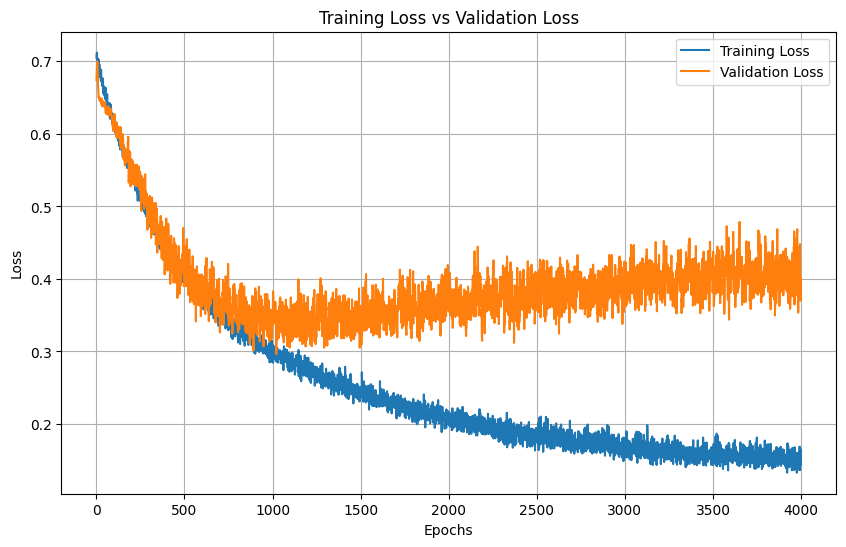

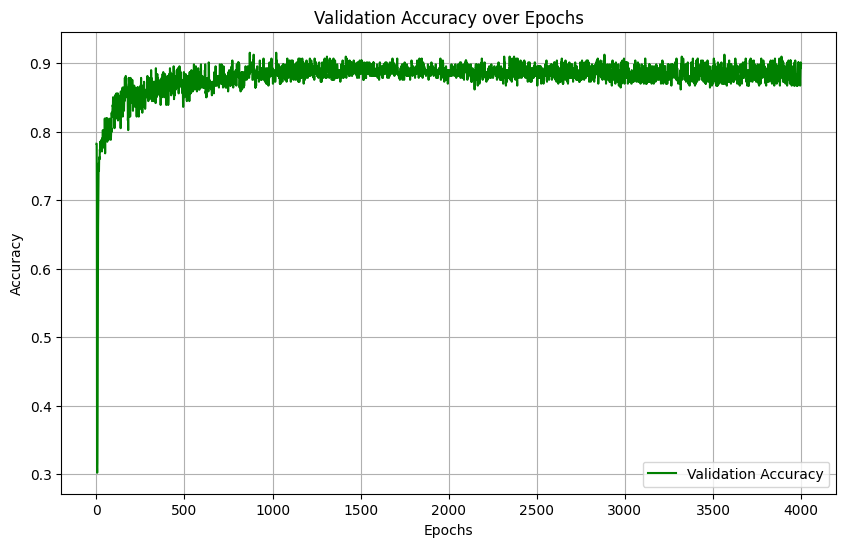

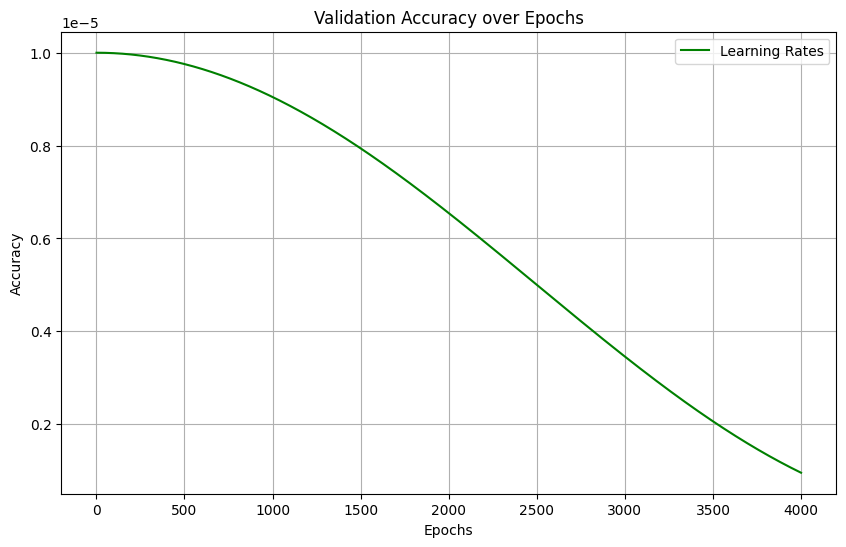

Model for bin 17 saved to GCNModels-5A_exp5/model_bin_17.pth
Training on bin 18/50
Bin 18, Epoch 1/4000, Train Loss: 0.7014, Validation Loss: 0.6879,  Accuracy: 0.7825, LR: 0.000010
Bin 18, Epoch 101/4000, Train Loss: 0.6261, Validation Loss: 0.6222,  Accuracy: 0.8249, LR: 0.000010
Bin 18, Epoch 201/4000, Train Loss: 0.5494, Validation Loss: 0.5590,  Accuracy: 0.8475, LR: 0.000010
Bin 18, Epoch 301/4000, Train Loss: 0.4920, Validation Loss: 0.4636,  Accuracy: 0.8701, LR: 0.000010
Bin 18, Epoch 401/4000, Train Loss: 0.4478, Validation Loss: 0.4445,  Accuracy: 0.8757, LR: 0.000010
Bin 18, Epoch 501/4000, Train Loss: 0.4184, Validation Loss: 0.4224,  Accuracy: 0.8785, LR: 0.000010
Bin 18, Epoch 601/4000, Train Loss: 0.4021, Validation Loss: 0.4155,  Accuracy: 0.8814, LR: 0.000010
Bin 18, Epoch 701/4000, Train Loss: 0.3791, Validation Loss: 0.3718,  Accuracy: 0.8983, LR: 0.000010
Bin 18, Epoch 801/4000, Train Loss: 0.3652, Validation Loss: 0.3688,  Accuracy: 0.8842, LR: 0.000009
Bin 18, Ep

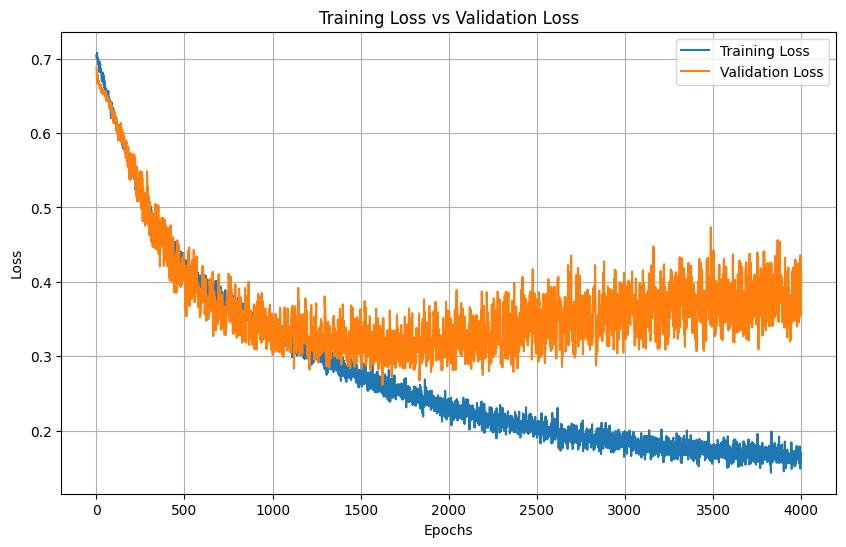

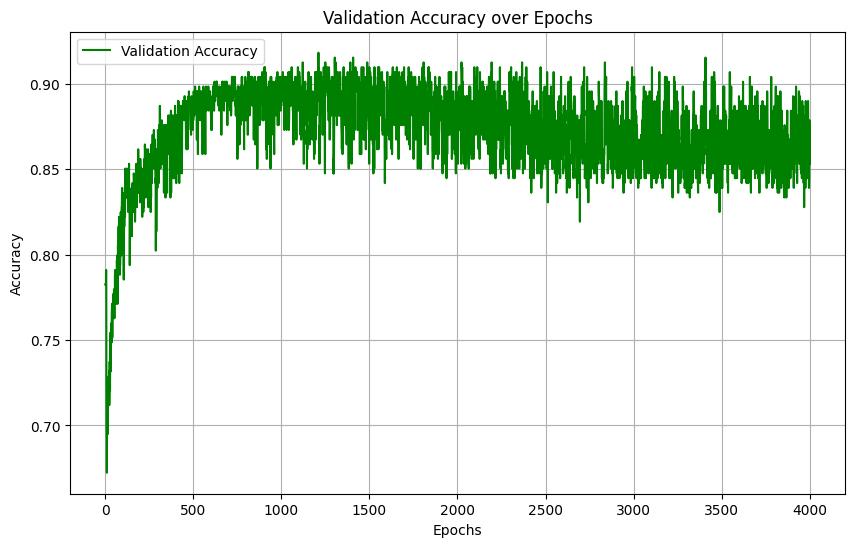

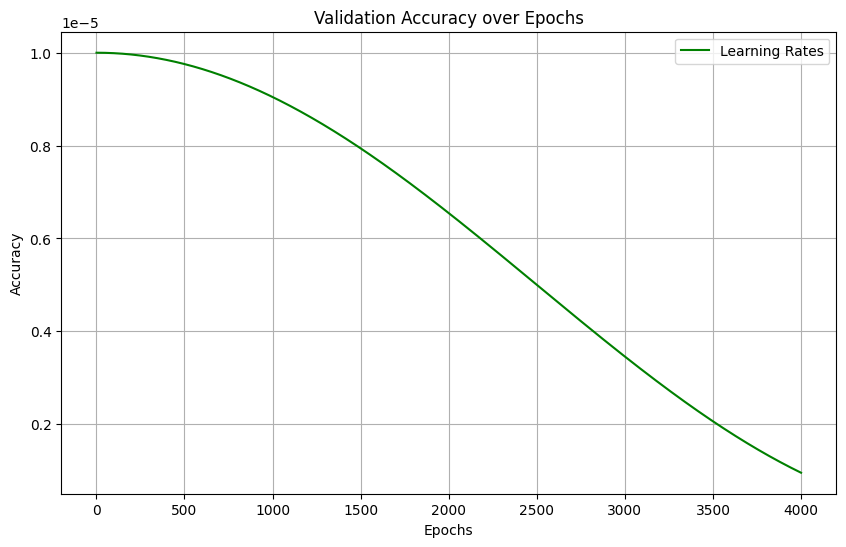

Model for bin 18 saved to GCNModels-5A_exp5/model_bin_18.pth
Training on bin 19/50
Bin 19, Epoch 1/4000, Train Loss: 0.7436, Validation Loss: 0.7120,  Accuracy: 0.2175, LR: 0.000010
Bin 19, Epoch 101/4000, Train Loss: 0.6392, Validation Loss: 0.6049,  Accuracy: 0.8362, LR: 0.000010
Bin 19, Epoch 201/4000, Train Loss: 0.5657, Validation Loss: 0.5269,  Accuracy: 0.8503, LR: 0.000010
Bin 19, Epoch 301/4000, Train Loss: 0.5188, Validation Loss: 0.4688,  Accuracy: 0.8559, LR: 0.000010
Bin 19, Epoch 401/4000, Train Loss: 0.4659, Validation Loss: 0.4222,  Accuracy: 0.8729, LR: 0.000010
Bin 19, Epoch 501/4000, Train Loss: 0.4449, Validation Loss: 0.4188,  Accuracy: 0.8588, LR: 0.000010
Bin 19, Epoch 601/4000, Train Loss: 0.4320, Validation Loss: 0.3521,  Accuracy: 0.8870, LR: 0.000010
Bin 19, Epoch 701/4000, Train Loss: 0.3891, Validation Loss: 0.3197,  Accuracy: 0.8870, LR: 0.000010
Bin 19, Epoch 801/4000, Train Loss: 0.3832, Validation Loss: 0.3291,  Accuracy: 0.8757, LR: 0.000009
Bin 19, Ep

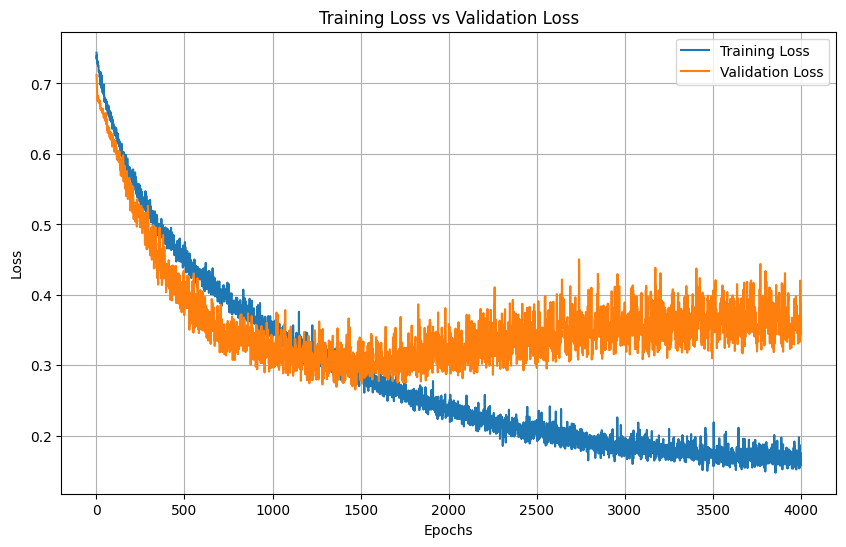

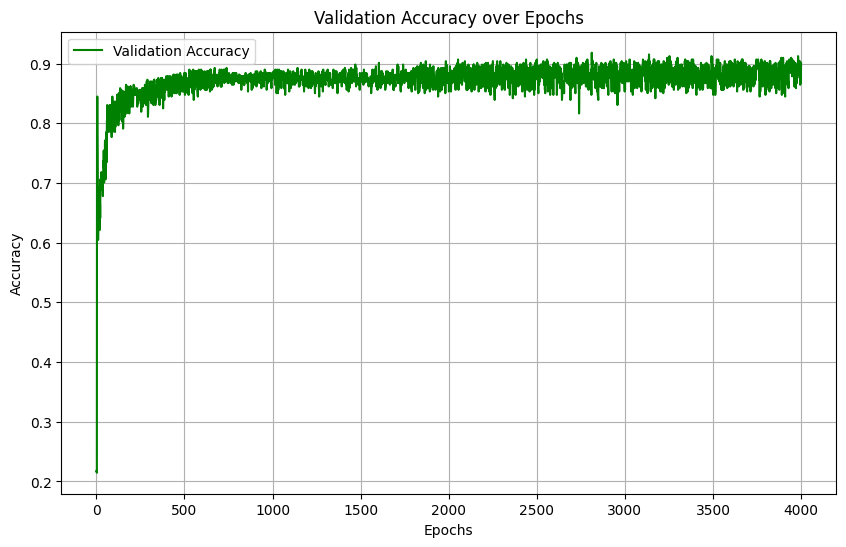

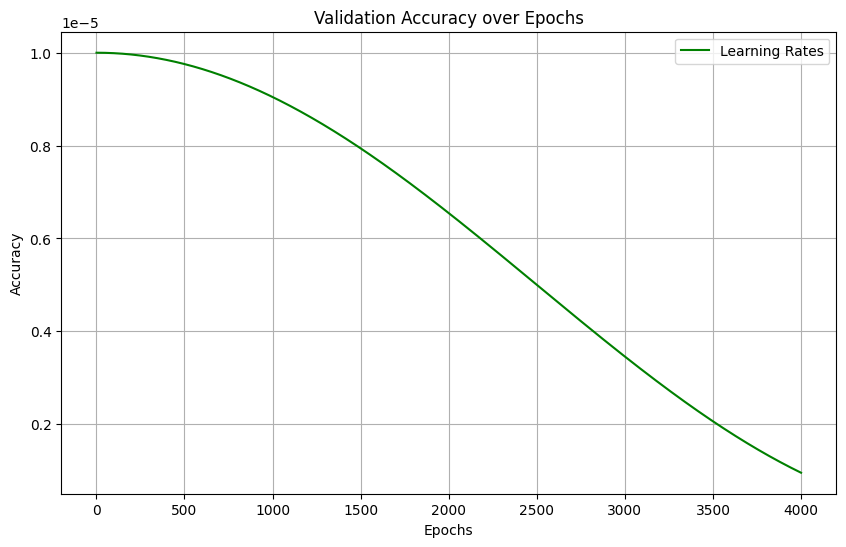

Model for bin 19 saved to GCNModels-5A_exp5/model_bin_19.pth
Training on bin 20/50
Bin 20, Epoch 1/4000, Train Loss: 0.7131, Validation Loss: 0.7220,  Accuracy: 0.2175, LR: 0.000010
Bin 20, Epoch 101/4000, Train Loss: 0.6430, Validation Loss: 0.6729,  Accuracy: 0.7203, LR: 0.000010
Bin 20, Epoch 201/4000, Train Loss: 0.5776, Validation Loss: 0.6251,  Accuracy: 0.7938, LR: 0.000010
Bin 20, Epoch 301/4000, Train Loss: 0.5346, Validation Loss: 0.5431,  Accuracy: 0.8418, LR: 0.000010
Bin 20, Epoch 401/4000, Train Loss: 0.4817, Validation Loss: 0.5001,  Accuracy: 0.8475, LR: 0.000010
Bin 20, Epoch 501/4000, Train Loss: 0.4708, Validation Loss: 0.4455,  Accuracy: 0.8616, LR: 0.000010
Bin 20, Epoch 601/4000, Train Loss: 0.4239, Validation Loss: 0.4115,  Accuracy: 0.8672, LR: 0.000010
Bin 20, Epoch 701/4000, Train Loss: 0.3864, Validation Loss: 0.4593,  Accuracy: 0.8333, LR: 0.000010
Bin 20, Epoch 801/4000, Train Loss: 0.3659, Validation Loss: 0.3779,  Accuracy: 0.8785, LR: 0.000009
Bin 20, Ep

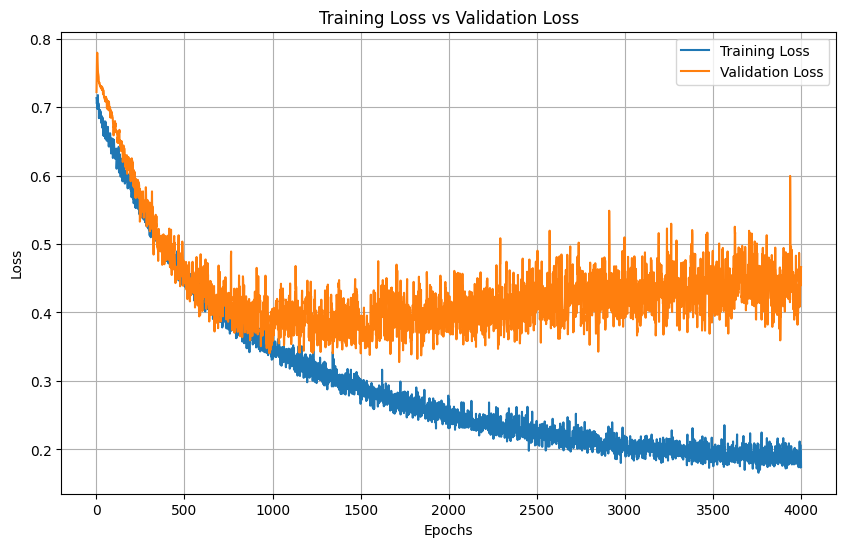

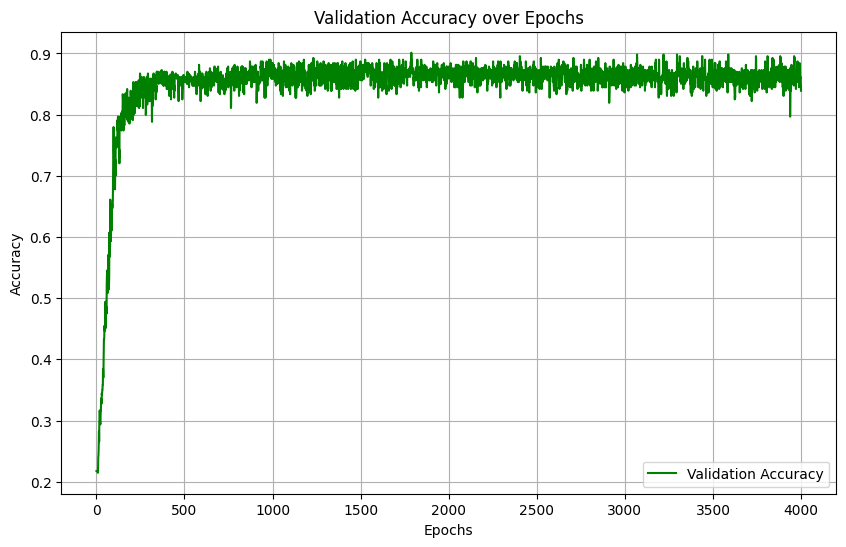

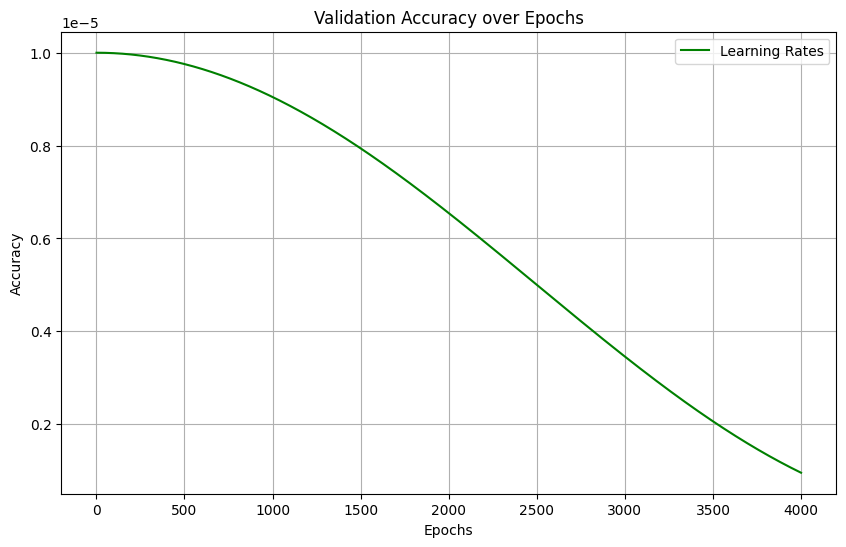

Model for bin 20 saved to GCNModels-5A_exp5/model_bin_20.pth
Training on bin 21/50
Bin 21, Epoch 1/4000, Train Loss: 0.6995, Validation Loss: 0.6703,  Accuracy: 0.7825, LR: 0.000010
Bin 21, Epoch 101/4000, Train Loss: 0.6224, Validation Loss: 0.6337,  Accuracy: 0.7966, LR: 0.000010
Bin 21, Epoch 201/4000, Train Loss: 0.5520, Validation Loss: 0.5700,  Accuracy: 0.8362, LR: 0.000010
Bin 21, Epoch 301/4000, Train Loss: 0.5188, Validation Loss: 0.5092,  Accuracy: 0.8559, LR: 0.000010
Bin 21, Epoch 401/4000, Train Loss: 0.4523, Validation Loss: 0.4759,  Accuracy: 0.8531, LR: 0.000010
Bin 21, Epoch 501/4000, Train Loss: 0.4094, Validation Loss: 0.4370,  Accuracy: 0.8616, LR: 0.000010
Bin 21, Epoch 601/4000, Train Loss: 0.3864, Validation Loss: 0.4364,  Accuracy: 0.8644, LR: 0.000010
Bin 21, Epoch 701/4000, Train Loss: 0.3651, Validation Loss: 0.4170,  Accuracy: 0.8644, LR: 0.000010
Bin 21, Epoch 801/4000, Train Loss: 0.3530, Validation Loss: 0.4412,  Accuracy: 0.8616, LR: 0.000009
Bin 21, Ep

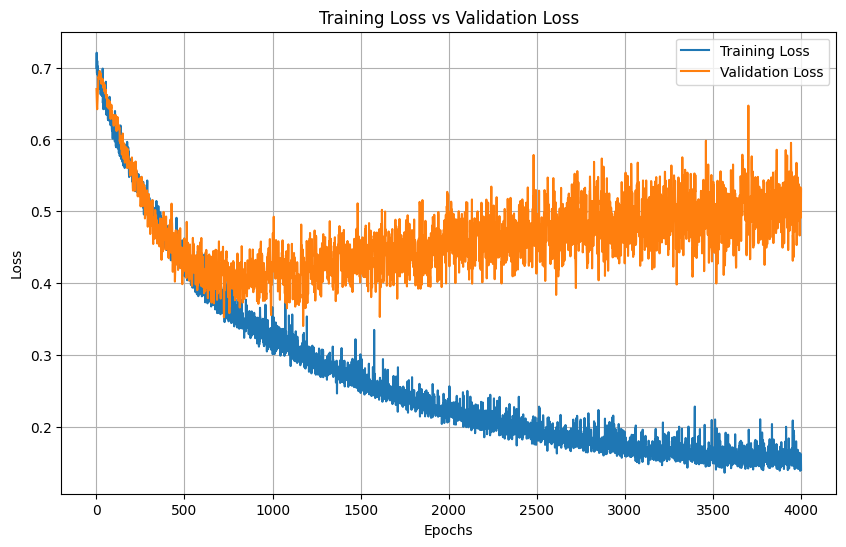

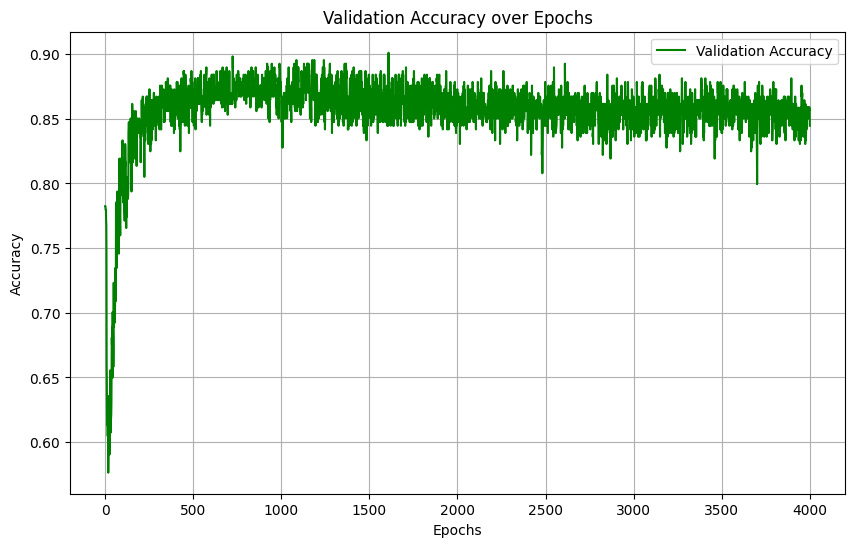

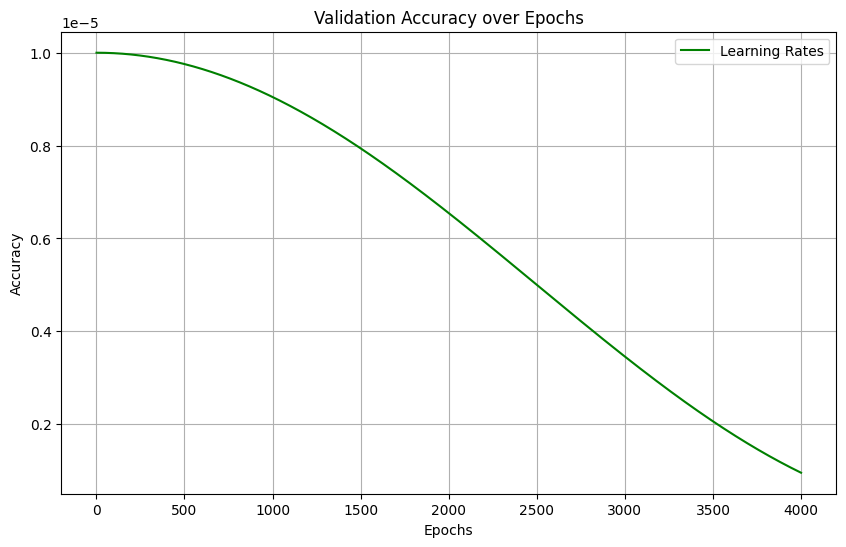

Model for bin 21 saved to GCNModels-5A_exp5/model_bin_21.pth
Training on bin 22/50
Bin 22, Epoch 1/4000, Train Loss: 0.7069, Validation Loss: 0.6811,  Accuracy: 0.7825, LR: 0.000010
Bin 22, Epoch 101/4000, Train Loss: 0.6470, Validation Loss: 0.6307,  Accuracy: 0.8107, LR: 0.000010
Bin 22, Epoch 201/4000, Train Loss: 0.6052, Validation Loss: 0.5585,  Accuracy: 0.8616, LR: 0.000010
Bin 22, Epoch 301/4000, Train Loss: 0.5467, Validation Loss: 0.5055,  Accuracy: 0.8559, LR: 0.000010
Bin 22, Epoch 401/4000, Train Loss: 0.5266, Validation Loss: 0.4448,  Accuracy: 0.8644, LR: 0.000010
Bin 22, Epoch 501/4000, Train Loss: 0.4894, Validation Loss: 0.4068,  Accuracy: 0.8729, LR: 0.000010
Bin 22, Epoch 601/4000, Train Loss: 0.4603, Validation Loss: 0.3719,  Accuracy: 0.8757, LR: 0.000010
Bin 22, Epoch 701/4000, Train Loss: 0.4302, Validation Loss: 0.3428,  Accuracy: 0.8842, LR: 0.000010
Bin 22, Epoch 801/4000, Train Loss: 0.4299, Validation Loss: 0.3291,  Accuracy: 0.8842, LR: 0.000009
Bin 22, Ep

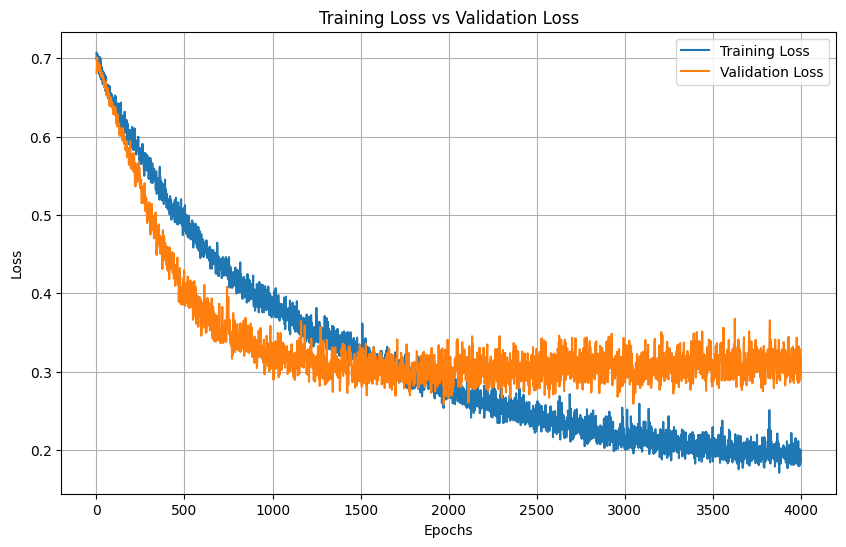

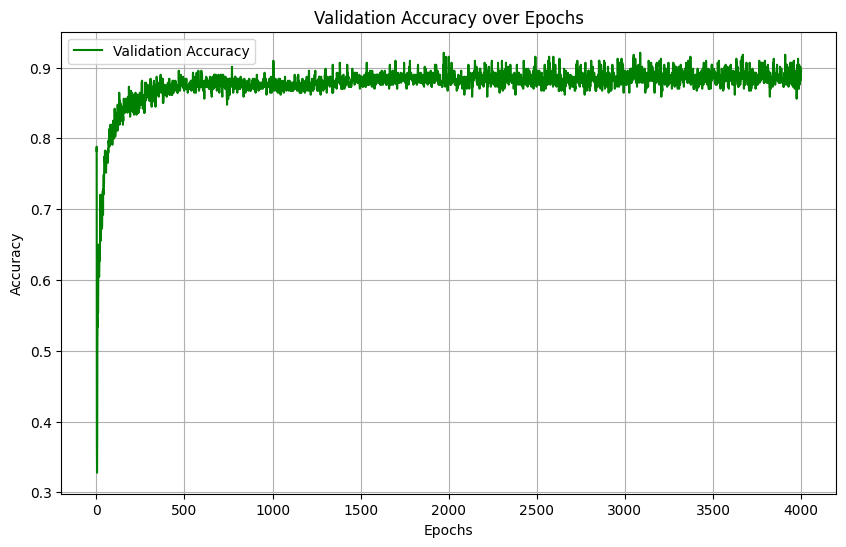

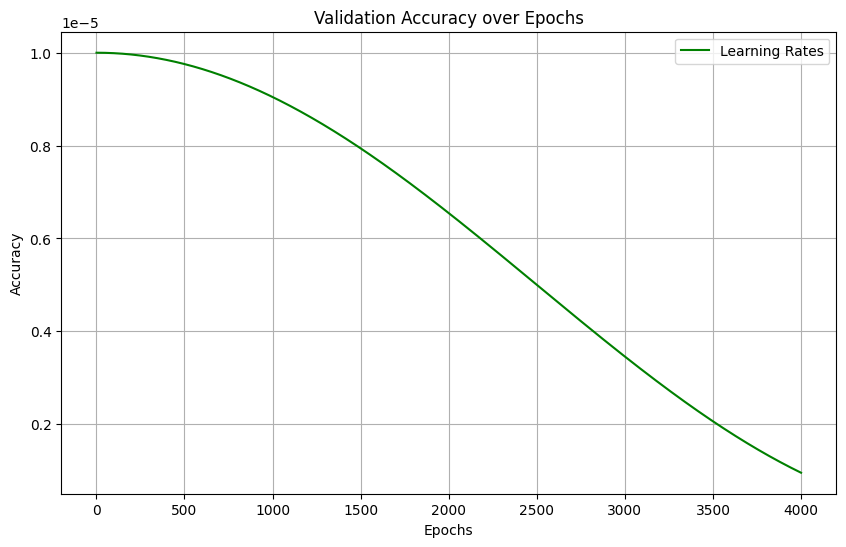

Model for bin 22 saved to GCNModels-5A_exp5/model_bin_22.pth
Training on bin 23/50
Bin 23, Epoch 1/4000, Train Loss: 0.7002, Validation Loss: 0.7011,  Accuracy: 0.2175, LR: 0.000010
Bin 23, Epoch 101/4000, Train Loss: 0.6193, Validation Loss: 0.6759,  Accuracy: 0.6780, LR: 0.000010
Bin 23, Epoch 201/4000, Train Loss: 0.5631, Validation Loss: 0.6183,  Accuracy: 0.8333, LR: 0.000010
Bin 23, Epoch 301/4000, Train Loss: 0.5074, Validation Loss: 0.5127,  Accuracy: 0.8729, LR: 0.000010
Bin 23, Epoch 401/4000, Train Loss: 0.4606, Validation Loss: 0.4766,  Accuracy: 0.8842, LR: 0.000010
Bin 23, Epoch 501/4000, Train Loss: 0.4145, Validation Loss: 0.4358,  Accuracy: 0.8814, LR: 0.000010
Bin 23, Epoch 601/4000, Train Loss: 0.3968, Validation Loss: 0.3621,  Accuracy: 0.8842, LR: 0.000010
Bin 23, Epoch 701/4000, Train Loss: 0.3520, Validation Loss: 0.3641,  Accuracy: 0.8898, LR: 0.000010
Bin 23, Epoch 801/4000, Train Loss: 0.3263, Validation Loss: 0.3386,  Accuracy: 0.8870, LR: 0.000009
Bin 23, Ep

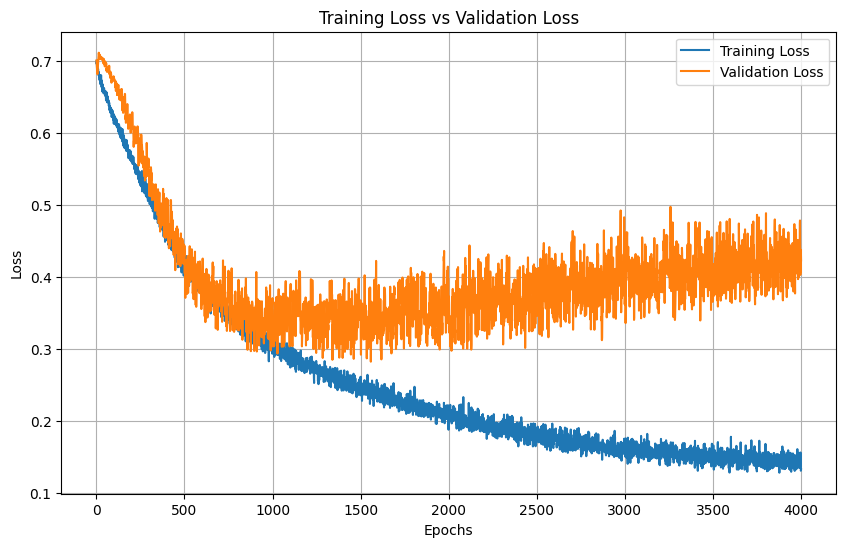

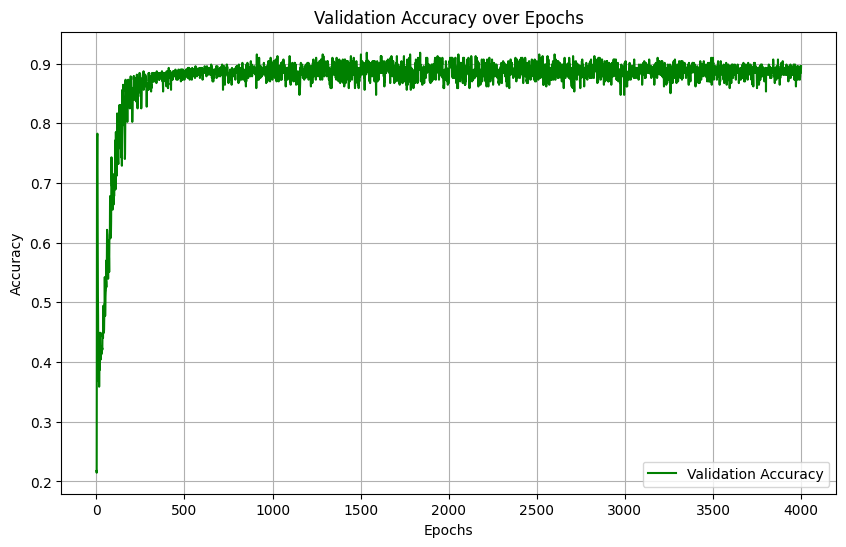

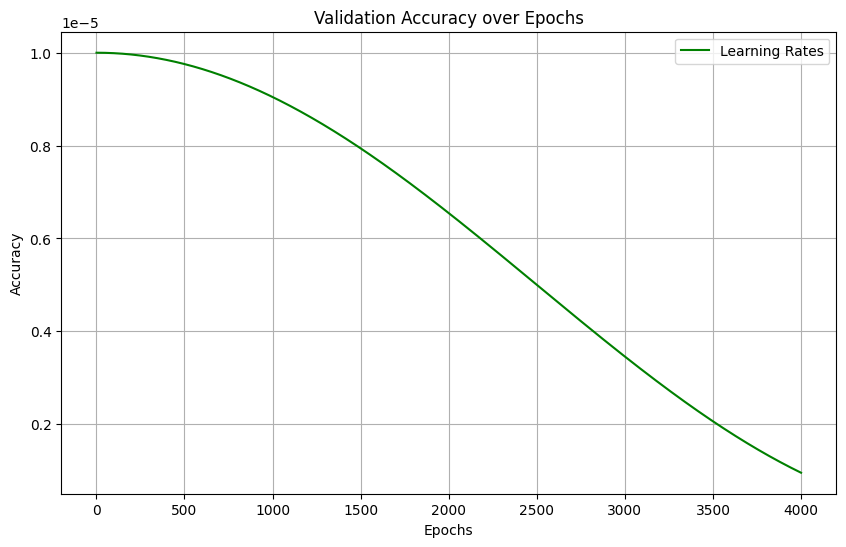

Model for bin 23 saved to GCNModels-5A_exp5/model_bin_23.pth
Training on bin 24/50
Bin 24, Epoch 1/4000, Train Loss: 0.6985, Validation Loss: 0.6679,  Accuracy: 0.7825, LR: 0.000010
Bin 24, Epoch 101/4000, Train Loss: 0.6207, Validation Loss: 0.6445,  Accuracy: 0.8588, LR: 0.000010
Bin 24, Epoch 201/4000, Train Loss: 0.5609, Validation Loss: 0.6031,  Accuracy: 0.8531, LR: 0.000010
Bin 24, Epoch 301/4000, Train Loss: 0.5416, Validation Loss: 0.5579,  Accuracy: 0.8757, LR: 0.000010
Bin 24, Epoch 401/4000, Train Loss: 0.4962, Validation Loss: 0.5314,  Accuracy: 0.8785, LR: 0.000010
Bin 24, Epoch 501/4000, Train Loss: 0.4642, Validation Loss: 0.4803,  Accuracy: 0.9040, LR: 0.000010
Bin 24, Epoch 601/4000, Train Loss: 0.4277, Validation Loss: 0.4154,  Accuracy: 0.9068, LR: 0.000010
Bin 24, Epoch 701/4000, Train Loss: 0.4077, Validation Loss: 0.4365,  Accuracy: 0.8983, LR: 0.000010
Bin 24, Epoch 801/4000, Train Loss: 0.3783, Validation Loss: 0.4260,  Accuracy: 0.9068, LR: 0.000009
Bin 24, Ep

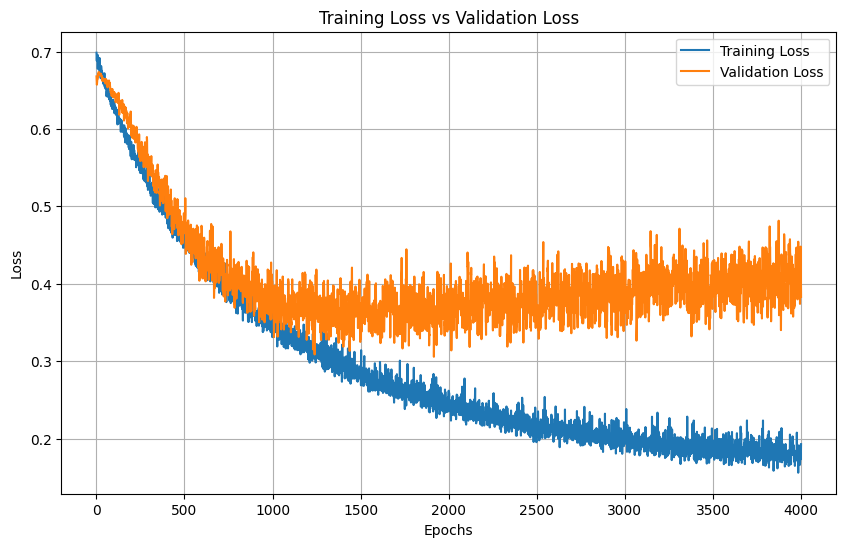

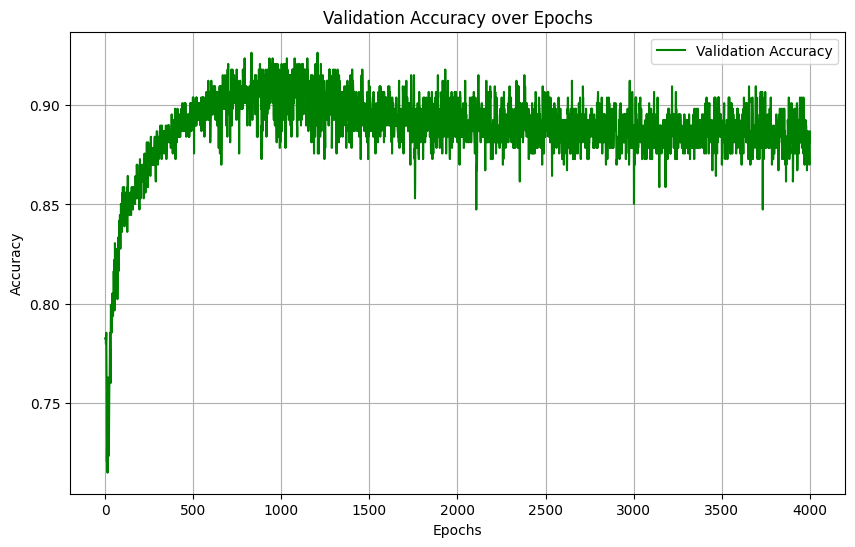

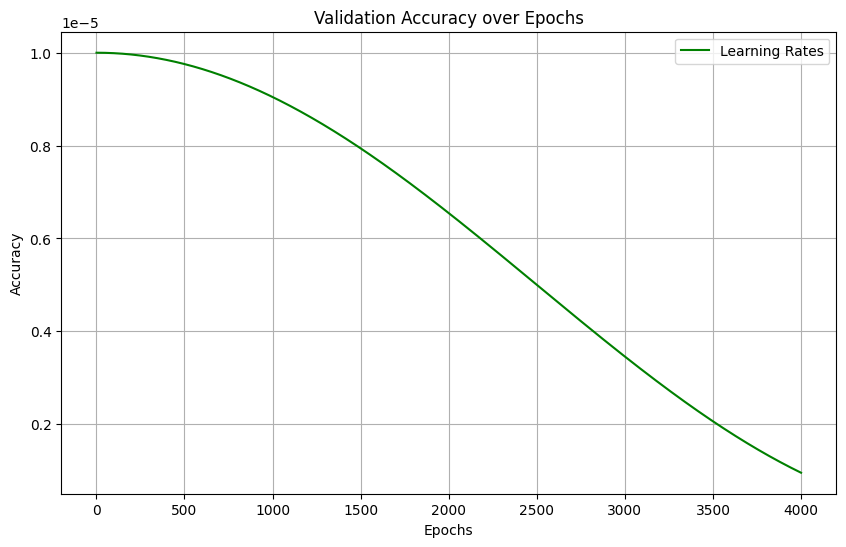

Model for bin 24 saved to GCNModels-5A_exp5/model_bin_24.pth
Training on bin 25/50
Bin 25, Epoch 1/4000, Train Loss: 0.6922, Validation Loss: 0.6657,  Accuracy: 0.7825, LR: 0.000010
Bin 25, Epoch 101/4000, Train Loss: 0.6287, Validation Loss: 0.6551,  Accuracy: 0.7825, LR: 0.000010
Bin 25, Epoch 201/4000, Train Loss: 0.5827, Validation Loss: 0.6020,  Accuracy: 0.8277, LR: 0.000010
Bin 25, Epoch 301/4000, Train Loss: 0.5301, Validation Loss: 0.5270,  Accuracy: 0.8446, LR: 0.000010
Bin 25, Epoch 401/4000, Train Loss: 0.5043, Validation Loss: 0.4564,  Accuracy: 0.8559, LR: 0.000010
Bin 25, Epoch 501/4000, Train Loss: 0.4625, Validation Loss: 0.4706,  Accuracy: 0.8559, LR: 0.000010
Bin 25, Epoch 601/4000, Train Loss: 0.4366, Validation Loss: 0.4308,  Accuracy: 0.8531, LR: 0.000010
Bin 25, Epoch 701/4000, Train Loss: 0.4155, Validation Loss: 0.4099,  Accuracy: 0.8672, LR: 0.000010
Bin 25, Epoch 801/4000, Train Loss: 0.3817, Validation Loss: 0.3887,  Accuracy: 0.8701, LR: 0.000009
Bin 25, Ep

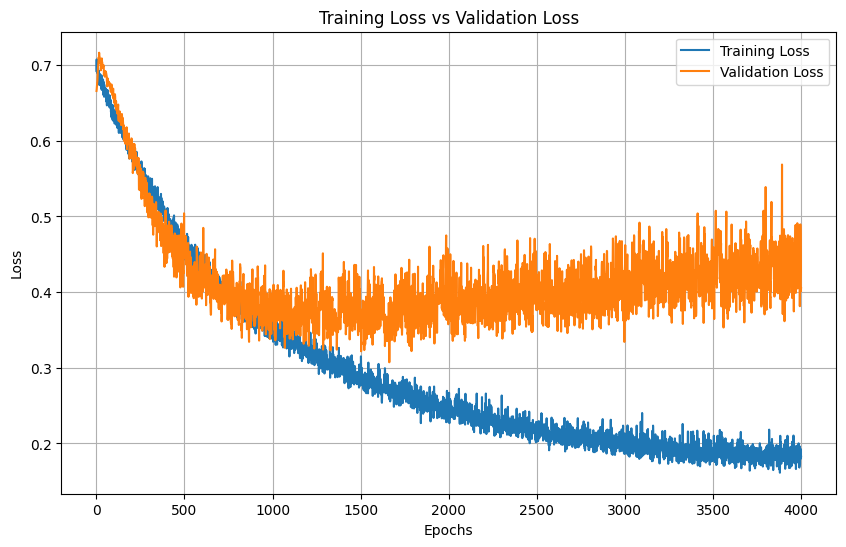

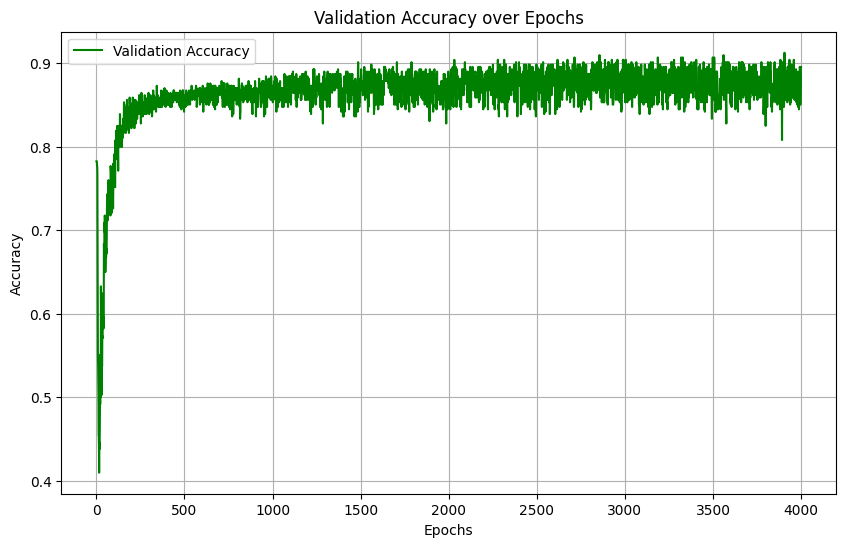

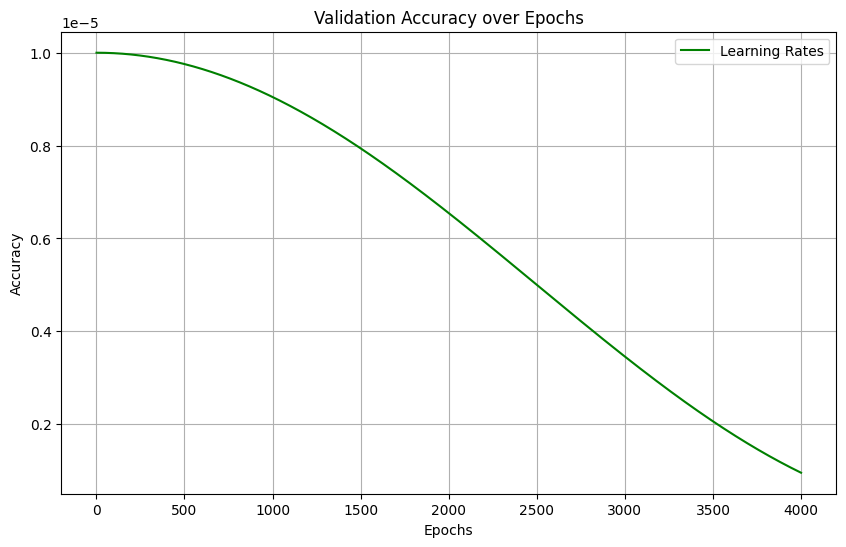

Model for bin 25 saved to GCNModels-5A_exp5/model_bin_25.pth
Training on bin 26/50
Bin 26, Epoch 1/4000, Train Loss: 0.6950, Validation Loss: 0.7066,  Accuracy: 0.2175, LR: 0.000010
Bin 26, Epoch 101/4000, Train Loss: 0.5983, Validation Loss: 0.6122,  Accuracy: 0.8418, LR: 0.000010
Bin 26, Epoch 201/4000, Train Loss: 0.5434, Validation Loss: 0.5407,  Accuracy: 0.8701, LR: 0.000010
Bin 26, Epoch 301/4000, Train Loss: 0.4939, Validation Loss: 0.5124,  Accuracy: 0.8616, LR: 0.000010
Bin 26, Epoch 401/4000, Train Loss: 0.4397, Validation Loss: 0.4599,  Accuracy: 0.8814, LR: 0.000010
Bin 26, Epoch 501/4000, Train Loss: 0.4304, Validation Loss: 0.4177,  Accuracy: 0.8814, LR: 0.000010
Bin 26, Epoch 601/4000, Train Loss: 0.3930, Validation Loss: 0.3872,  Accuracy: 0.8955, LR: 0.000010
Bin 26, Epoch 701/4000, Train Loss: 0.3690, Validation Loss: 0.3882,  Accuracy: 0.8870, LR: 0.000010
Bin 26, Epoch 801/4000, Train Loss: 0.3704, Validation Loss: 0.3898,  Accuracy: 0.8672, LR: 0.000009
Bin 26, Ep

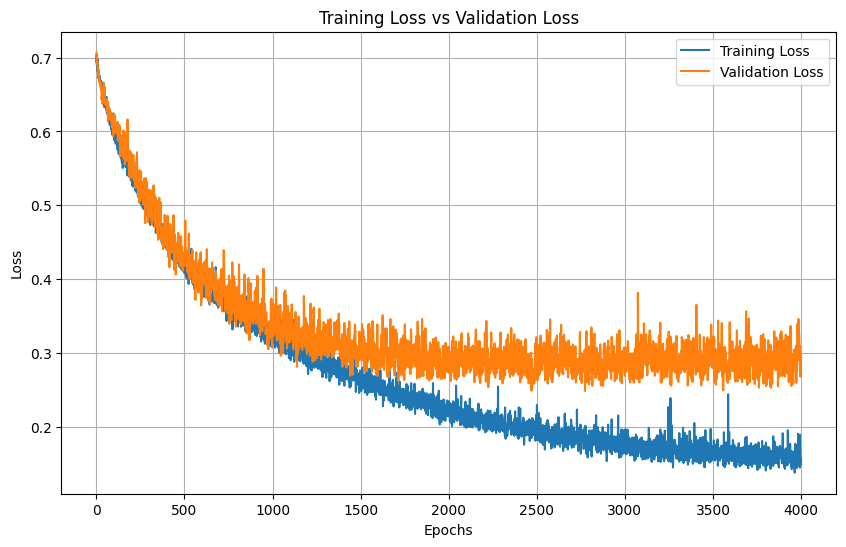

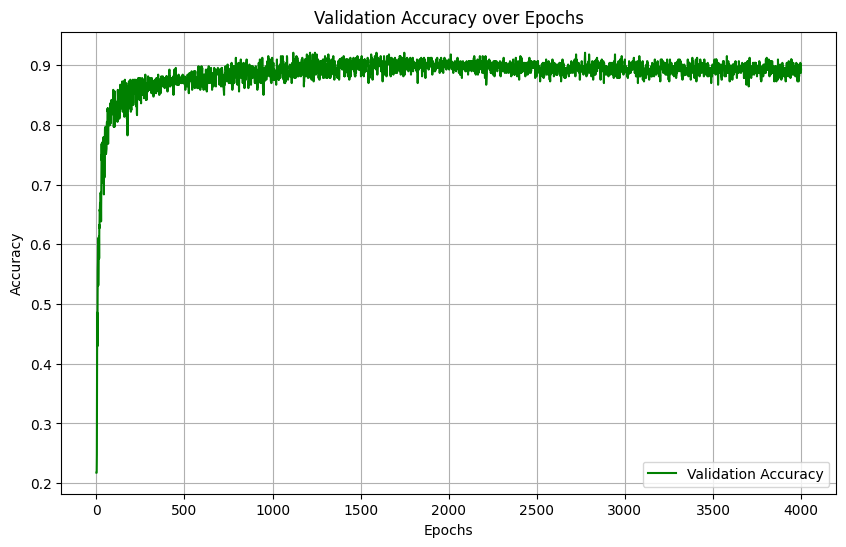

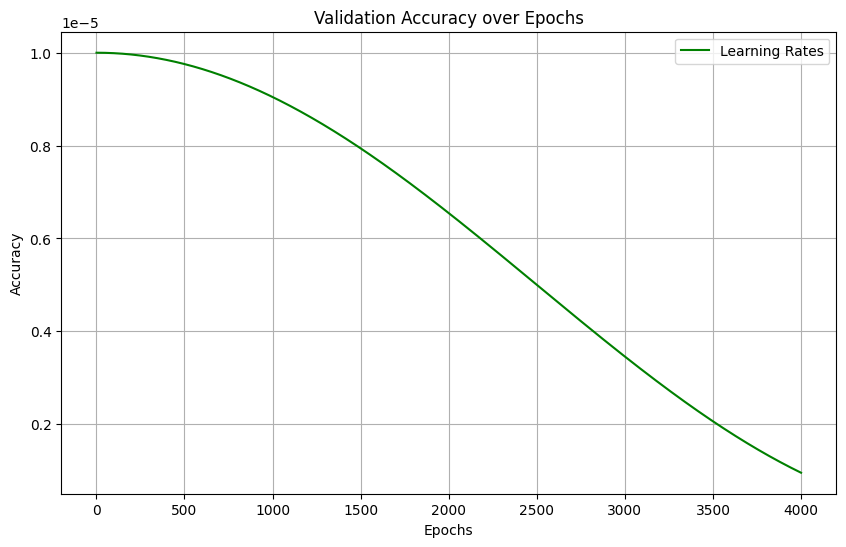

Model for bin 26 saved to GCNModels-5A_exp5/model_bin_26.pth
Training on bin 27/50
Bin 27, Epoch 1/4000, Train Loss: 0.6928, Validation Loss: 0.7133,  Accuracy: 0.2175, LR: 0.000010
Bin 27, Epoch 101/4000, Train Loss: 0.6215, Validation Loss: 0.6685,  Accuracy: 0.7232, LR: 0.000010
Bin 27, Epoch 201/4000, Train Loss: 0.5729, Validation Loss: 0.6002,  Accuracy: 0.8249, LR: 0.000010
Bin 27, Epoch 301/4000, Train Loss: 0.5035, Validation Loss: 0.5251,  Accuracy: 0.8559, LR: 0.000010
Bin 27, Epoch 401/4000, Train Loss: 0.4663, Validation Loss: 0.5080,  Accuracy: 0.8446, LR: 0.000010
Bin 27, Epoch 501/4000, Train Loss: 0.4522, Validation Loss: 0.4706,  Accuracy: 0.8475, LR: 0.000010
Bin 27, Epoch 601/4000, Train Loss: 0.4043, Validation Loss: 0.3738,  Accuracy: 0.8757, LR: 0.000010
Bin 27, Epoch 701/4000, Train Loss: 0.3761, Validation Loss: 0.4015,  Accuracy: 0.8616, LR: 0.000010
Bin 27, Epoch 801/4000, Train Loss: 0.3659, Validation Loss: 0.3954,  Accuracy: 0.8588, LR: 0.000009
Bin 27, Ep

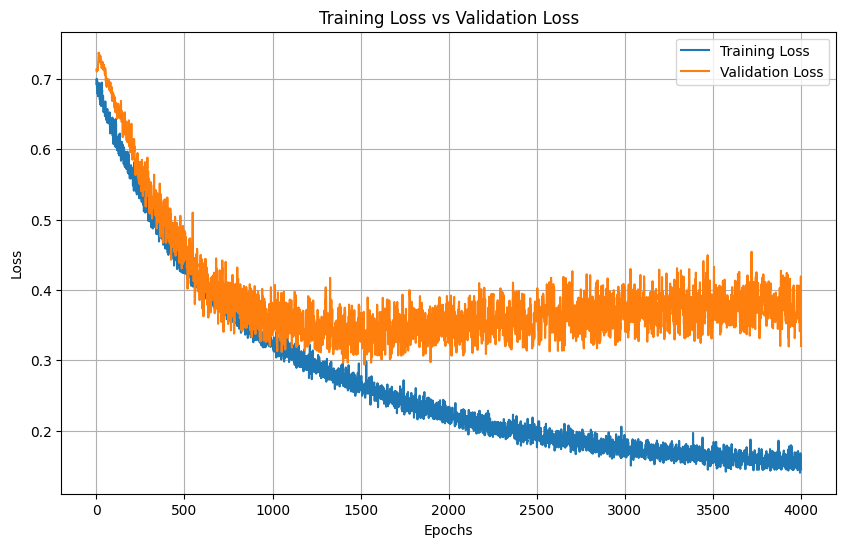

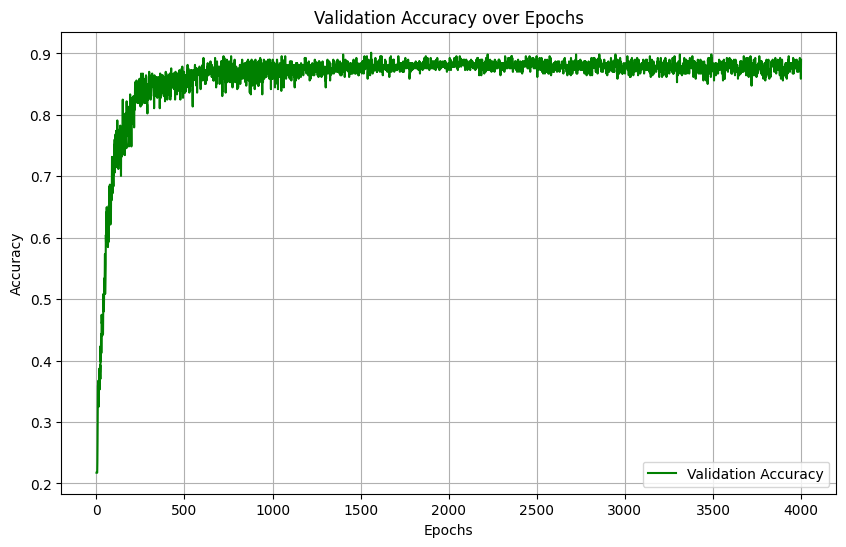

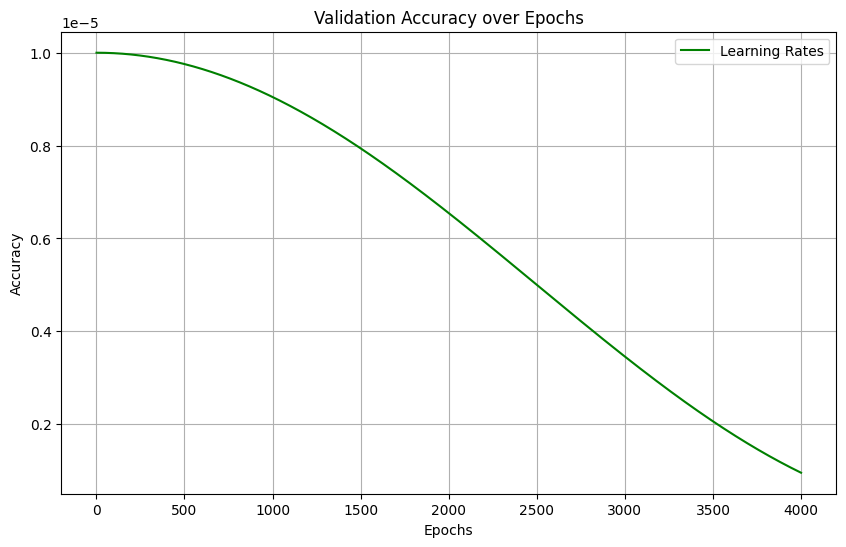

Model for bin 27 saved to GCNModels-5A_exp5/model_bin_27.pth
Training on bin 28/50
Bin 28, Epoch 1/4000, Train Loss: 0.7428, Validation Loss: 0.6972,  Accuracy: 0.2175, LR: 0.000010
Bin 28, Epoch 101/4000, Train Loss: 0.6088, Validation Loss: 0.6055,  Accuracy: 0.8192, LR: 0.000010
Bin 28, Epoch 201/4000, Train Loss: 0.5306, Validation Loss: 0.5484,  Accuracy: 0.8164, LR: 0.000010
Bin 28, Epoch 301/4000, Train Loss: 0.4704, Validation Loss: 0.4570,  Accuracy: 0.8644, LR: 0.000010
Bin 28, Epoch 401/4000, Train Loss: 0.4110, Validation Loss: 0.4358,  Accuracy: 0.8672, LR: 0.000010
Bin 28, Epoch 501/4000, Train Loss: 0.3889, Validation Loss: 0.4010,  Accuracy: 0.8616, LR: 0.000010
Bin 28, Epoch 601/4000, Train Loss: 0.3572, Validation Loss: 0.4058,  Accuracy: 0.8644, LR: 0.000010
Bin 28, Epoch 701/4000, Train Loss: 0.3478, Validation Loss: 0.3892,  Accuracy: 0.8729, LR: 0.000010
Bin 28, Epoch 801/4000, Train Loss: 0.3085, Validation Loss: 0.3780,  Accuracy: 0.8729, LR: 0.000009
Bin 28, Ep

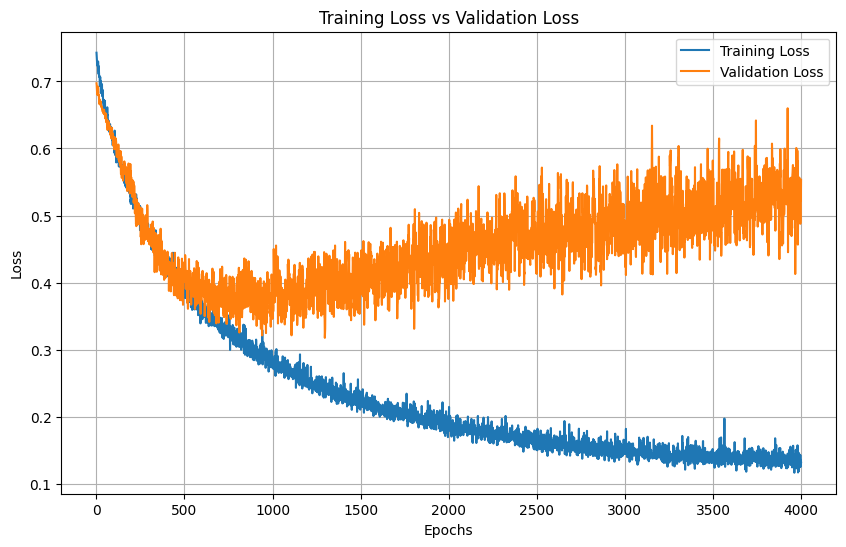

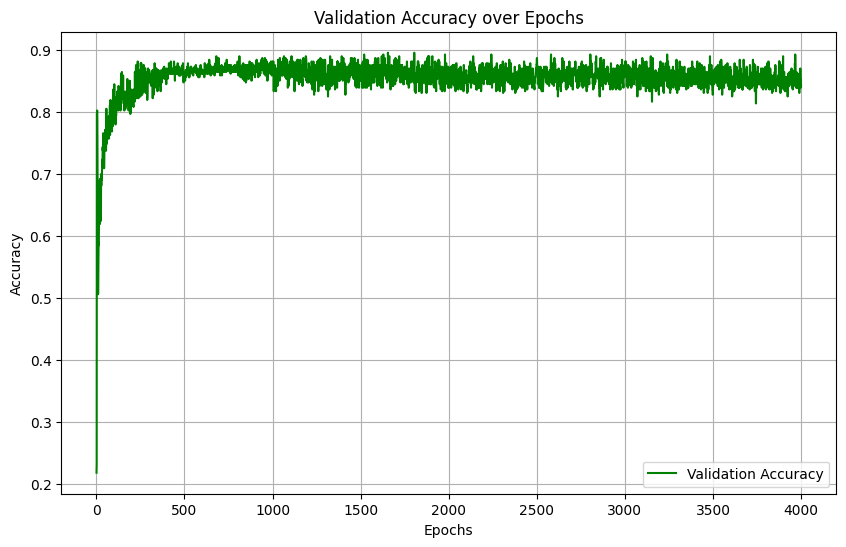

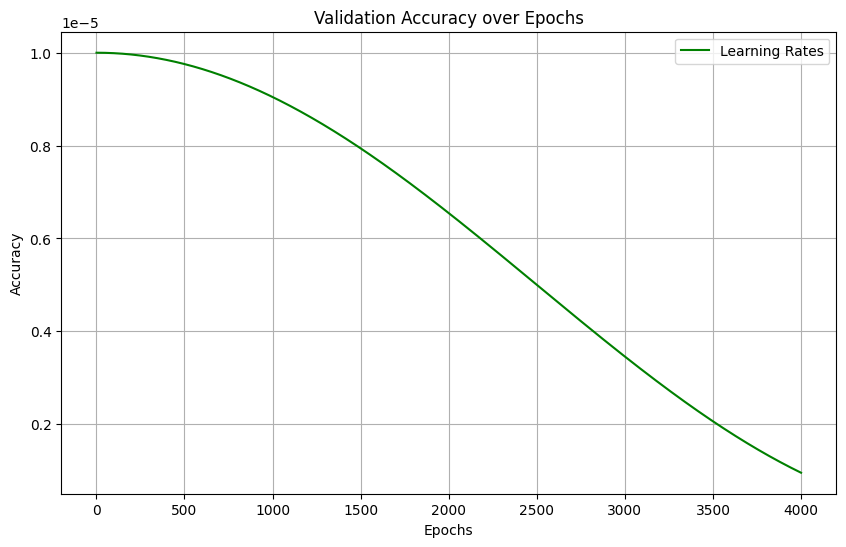

Model for bin 28 saved to GCNModels-5A_exp5/model_bin_28.pth
Training on bin 29/50
Bin 29, Epoch 1/4000, Train Loss: 0.7297, Validation Loss: 0.6924,  Accuracy: 0.7740, LR: 0.000010
Bin 29, Epoch 101/4000, Train Loss: 0.6286, Validation Loss: 0.6332,  Accuracy: 0.8192, LR: 0.000010
Bin 29, Epoch 201/4000, Train Loss: 0.5633, Validation Loss: 0.5724,  Accuracy: 0.8588, LR: 0.000010
Bin 29, Epoch 301/4000, Train Loss: 0.5254, Validation Loss: 0.4758,  Accuracy: 0.8814, LR: 0.000010
Bin 29, Epoch 401/4000, Train Loss: 0.4727, Validation Loss: 0.4380,  Accuracy: 0.8729, LR: 0.000010
Bin 29, Epoch 501/4000, Train Loss: 0.4407, Validation Loss: 0.4371,  Accuracy: 0.8644, LR: 0.000010
Bin 29, Epoch 601/4000, Train Loss: 0.4052, Validation Loss: 0.3940,  Accuracy: 0.8757, LR: 0.000010
Bin 29, Epoch 701/4000, Train Loss: 0.3831, Validation Loss: 0.3494,  Accuracy: 0.8870, LR: 0.000010
Bin 29, Epoch 801/4000, Train Loss: 0.3857, Validation Loss: 0.3232,  Accuracy: 0.9068, LR: 0.000009
Bin 29, Ep

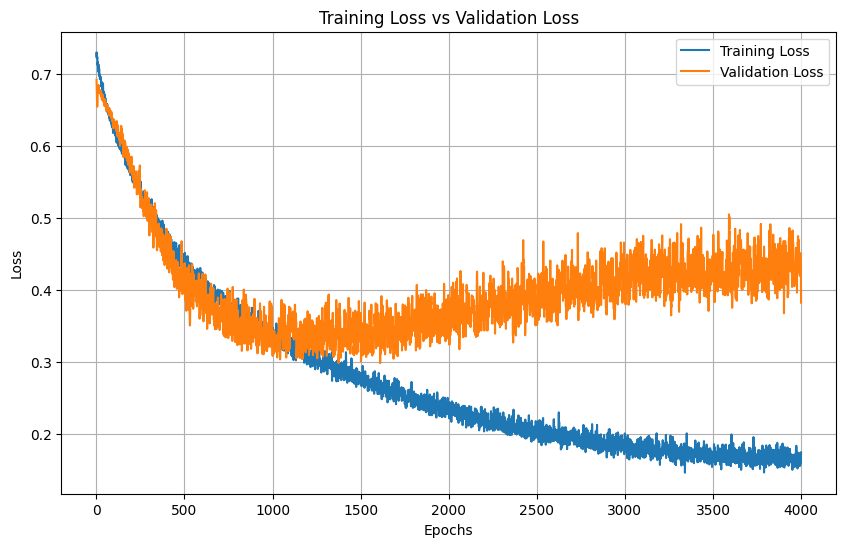

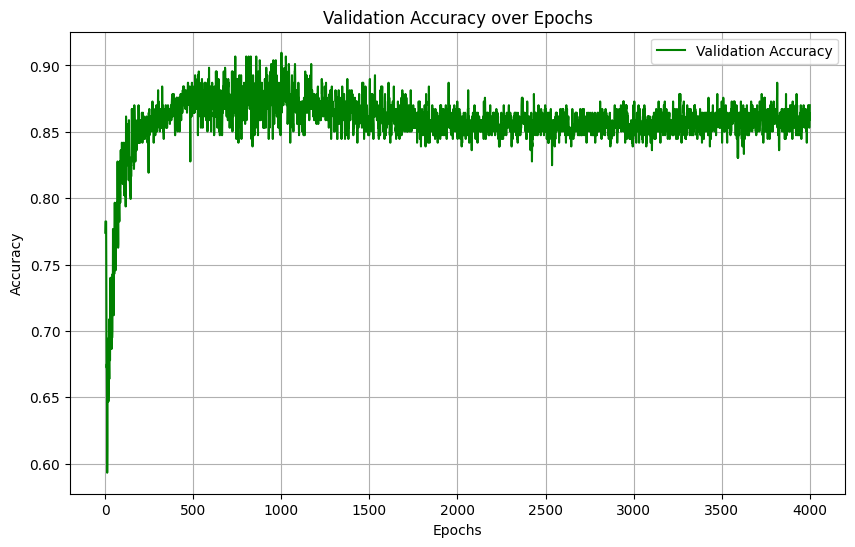

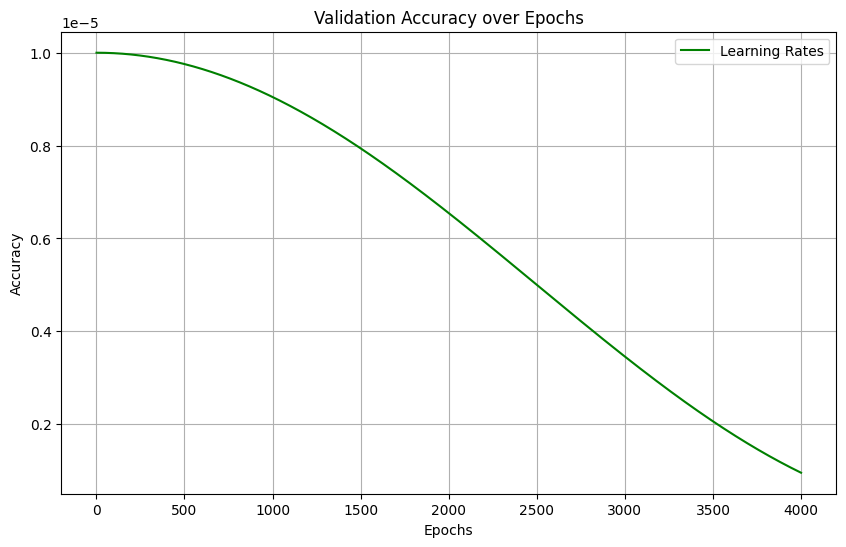

Model for bin 29 saved to GCNModels-5A_exp5/model_bin_29.pth
Training on bin 30/50
Bin 30, Epoch 1/4000, Train Loss: 0.6921, Validation Loss: 0.6772,  Accuracy: 0.7825, LR: 0.000010
Bin 30, Epoch 101/4000, Train Loss: 0.6249, Validation Loss: 0.6412,  Accuracy: 0.7797, LR: 0.000010
Bin 30, Epoch 201/4000, Train Loss: 0.5528, Validation Loss: 0.5929,  Accuracy: 0.8079, LR: 0.000010
Bin 30, Epoch 301/4000, Train Loss: 0.5118, Validation Loss: 0.5480,  Accuracy: 0.8192, LR: 0.000010
Bin 30, Epoch 401/4000, Train Loss: 0.4761, Validation Loss: 0.4709,  Accuracy: 0.8588, LR: 0.000010
Bin 30, Epoch 501/4000, Train Loss: 0.4365, Validation Loss: 0.4356,  Accuracy: 0.8842, LR: 0.000010
Bin 30, Epoch 601/4000, Train Loss: 0.4154, Validation Loss: 0.4741,  Accuracy: 0.8446, LR: 0.000010
Bin 30, Epoch 701/4000, Train Loss: 0.3813, Validation Loss: 0.4300,  Accuracy: 0.8588, LR: 0.000010
Bin 30, Epoch 801/4000, Train Loss: 0.3974, Validation Loss: 0.4602,  Accuracy: 0.8559, LR: 0.000009
Bin 30, Ep

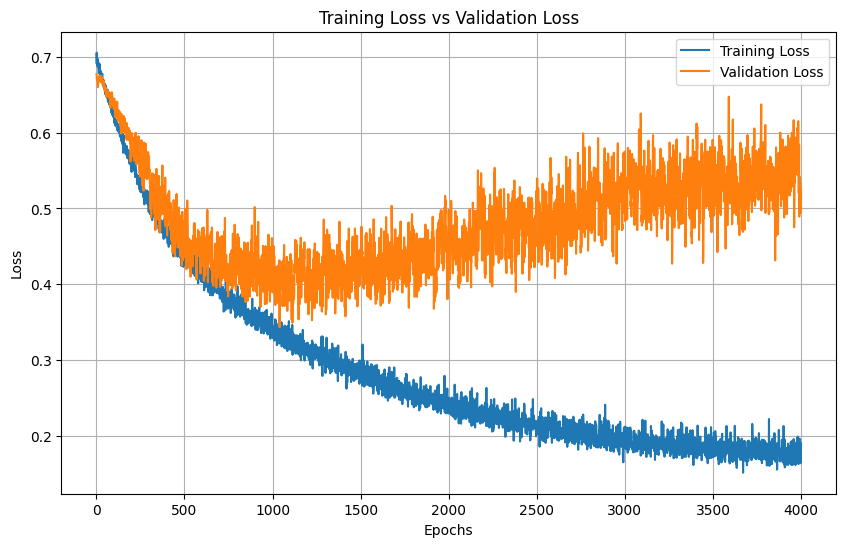

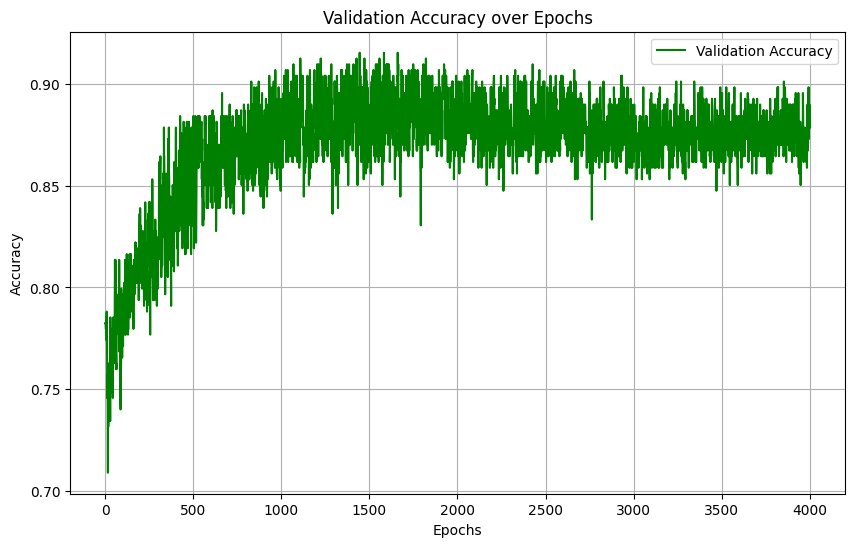

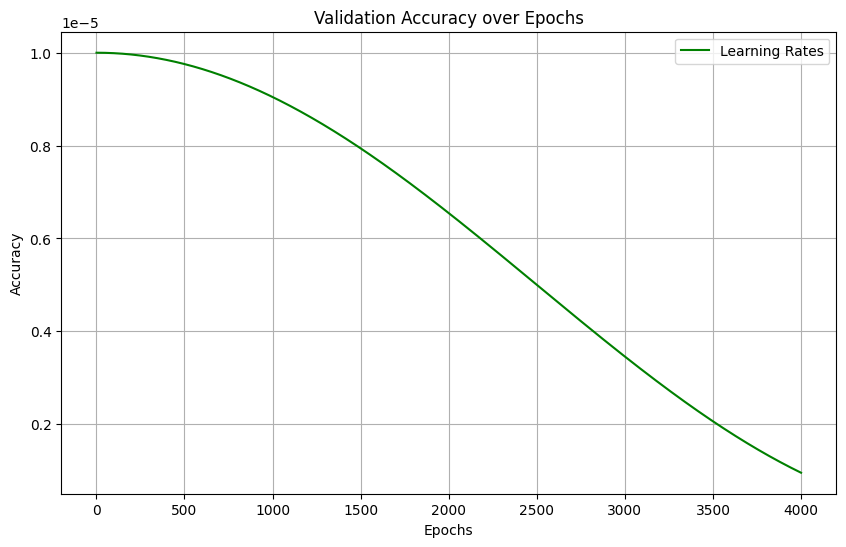

Model for bin 30 saved to GCNModels-5A_exp5/model_bin_30.pth
Training on bin 31/50
Bin 31, Epoch 1/4000, Train Loss: 0.6919, Validation Loss: 0.6726,  Accuracy: 0.7825, LR: 0.000010
Bin 31, Epoch 101/4000, Train Loss: 0.6149, Validation Loss: 0.6052,  Accuracy: 0.8023, LR: 0.000010
Bin 31, Epoch 201/4000, Train Loss: 0.5474, Validation Loss: 0.5283,  Accuracy: 0.8531, LR: 0.000010
Bin 31, Epoch 301/4000, Train Loss: 0.5012, Validation Loss: 0.4836,  Accuracy: 0.8588, LR: 0.000010
Bin 31, Epoch 401/4000, Train Loss: 0.4628, Validation Loss: 0.4526,  Accuracy: 0.8588, LR: 0.000010
Bin 31, Epoch 501/4000, Train Loss: 0.4264, Validation Loss: 0.3669,  Accuracy: 0.8927, LR: 0.000010
Bin 31, Epoch 601/4000, Train Loss: 0.3877, Validation Loss: 0.3807,  Accuracy: 0.8672, LR: 0.000010
Bin 31, Epoch 701/4000, Train Loss: 0.3763, Validation Loss: 0.3476,  Accuracy: 0.8927, LR: 0.000010
Bin 31, Epoch 801/4000, Train Loss: 0.3486, Validation Loss: 0.3914,  Accuracy: 0.8644, LR: 0.000009
Bin 31, Ep

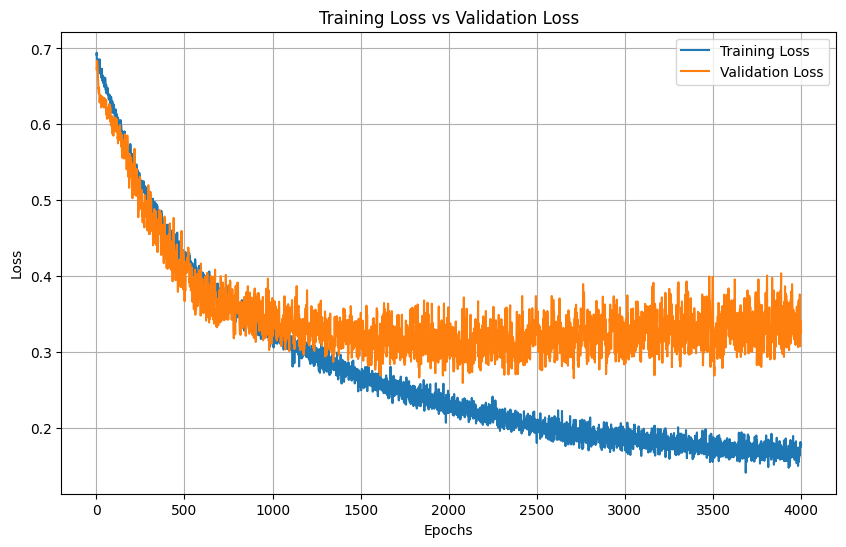

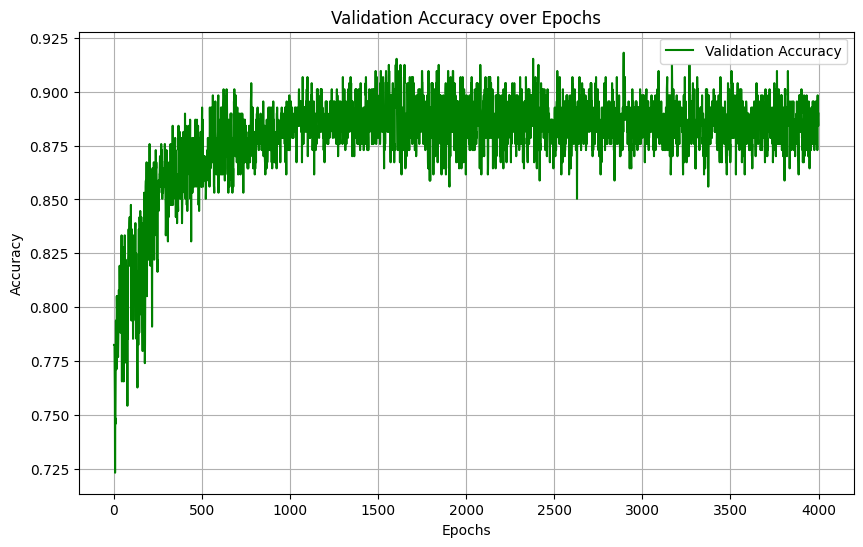

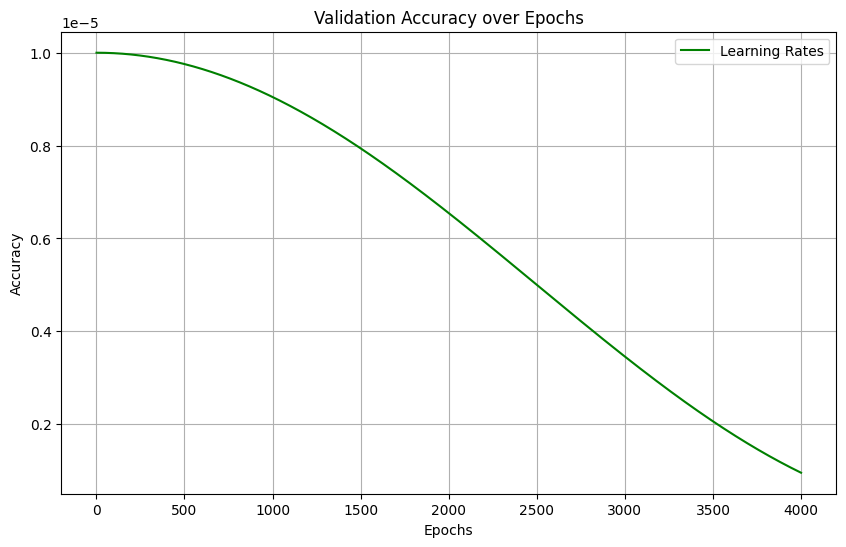

Model for bin 31 saved to GCNModels-5A_exp5/model_bin_31.pth
Training on bin 32/50
Bin 32, Epoch 1/4000, Train Loss: 0.6880, Validation Loss: 0.7150,  Accuracy: 0.2175, LR: 0.000010
Bin 32, Epoch 101/4000, Train Loss: 0.6083, Validation Loss: 0.6386,  Accuracy: 0.7486, LR: 0.000010
Bin 32, Epoch 201/4000, Train Loss: 0.5478, Validation Loss: 0.5627,  Accuracy: 0.8107, LR: 0.000010
Bin 32, Epoch 301/4000, Train Loss: 0.5110, Validation Loss: 0.4948,  Accuracy: 0.8418, LR: 0.000010
Bin 32, Epoch 401/4000, Train Loss: 0.4664, Validation Loss: 0.4382,  Accuracy: 0.8559, LR: 0.000010
Bin 32, Epoch 501/4000, Train Loss: 0.4413, Validation Loss: 0.4026,  Accuracy: 0.8672, LR: 0.000010
Bin 32, Epoch 601/4000, Train Loss: 0.4229, Validation Loss: 0.4127,  Accuracy: 0.8644, LR: 0.000010
Bin 32, Epoch 701/4000, Train Loss: 0.3862, Validation Loss: 0.3854,  Accuracy: 0.8701, LR: 0.000010
Bin 32, Epoch 801/4000, Train Loss: 0.3633, Validation Loss: 0.3710,  Accuracy: 0.8870, LR: 0.000009
Bin 32, Ep

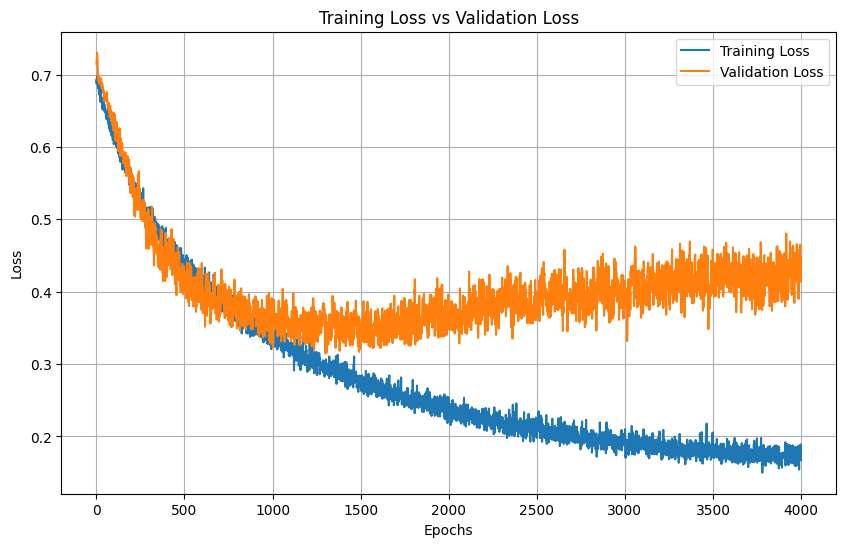

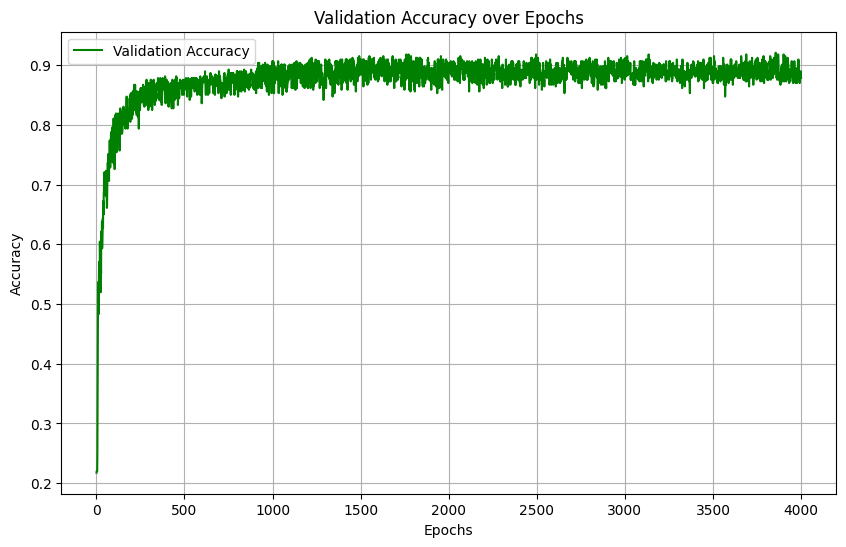

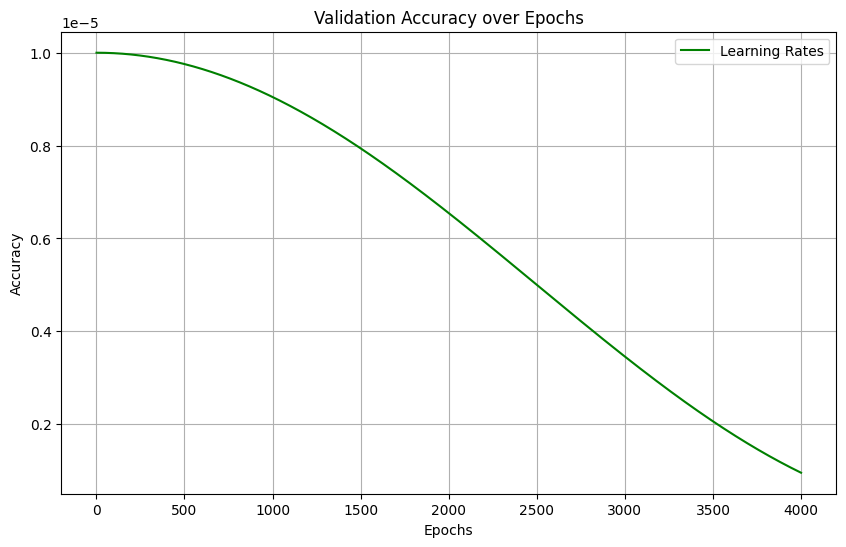

Model for bin 32 saved to GCNModels-5A_exp5/model_bin_32.pth
Training on bin 33/50
Bin 33, Epoch 1/4000, Train Loss: 0.7074, Validation Loss: 0.7432,  Accuracy: 0.2175, LR: 0.000010
Bin 33, Epoch 101/4000, Train Loss: 0.6297, Validation Loss: 0.6668,  Accuracy: 0.6893, LR: 0.000010
Bin 33, Epoch 201/4000, Train Loss: 0.5708, Validation Loss: 0.5797,  Accuracy: 0.8192, LR: 0.000010
Bin 33, Epoch 301/4000, Train Loss: 0.5320, Validation Loss: 0.5288,  Accuracy: 0.8362, LR: 0.000010
Bin 33, Epoch 401/4000, Train Loss: 0.4716, Validation Loss: 0.4917,  Accuracy: 0.8277, LR: 0.000010
Bin 33, Epoch 501/4000, Train Loss: 0.4620, Validation Loss: 0.4094,  Accuracy: 0.8616, LR: 0.000010
Bin 33, Epoch 601/4000, Train Loss: 0.4298, Validation Loss: 0.3729,  Accuracy: 0.8616, LR: 0.000010
Bin 33, Epoch 701/4000, Train Loss: 0.4009, Validation Loss: 0.3717,  Accuracy: 0.8475, LR: 0.000010
Bin 33, Epoch 801/4000, Train Loss: 0.3857, Validation Loss: 0.3573,  Accuracy: 0.8475, LR: 0.000009
Bin 33, Ep

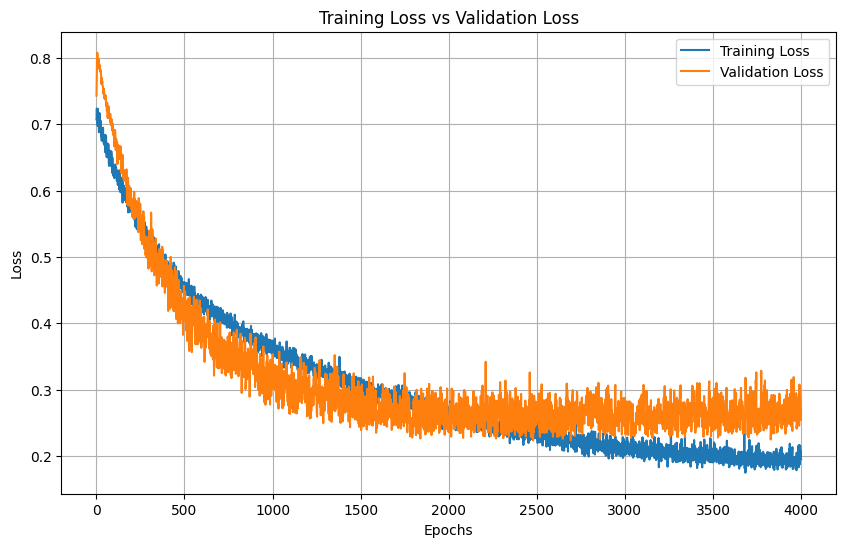

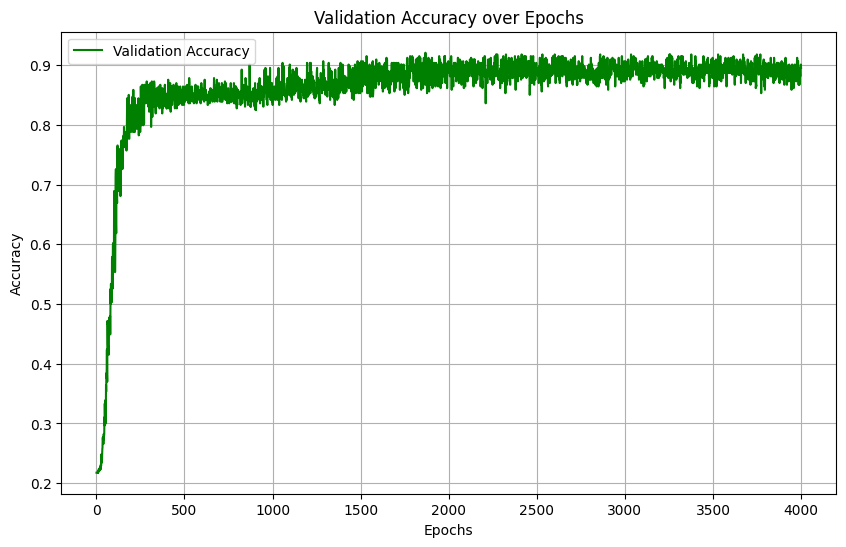

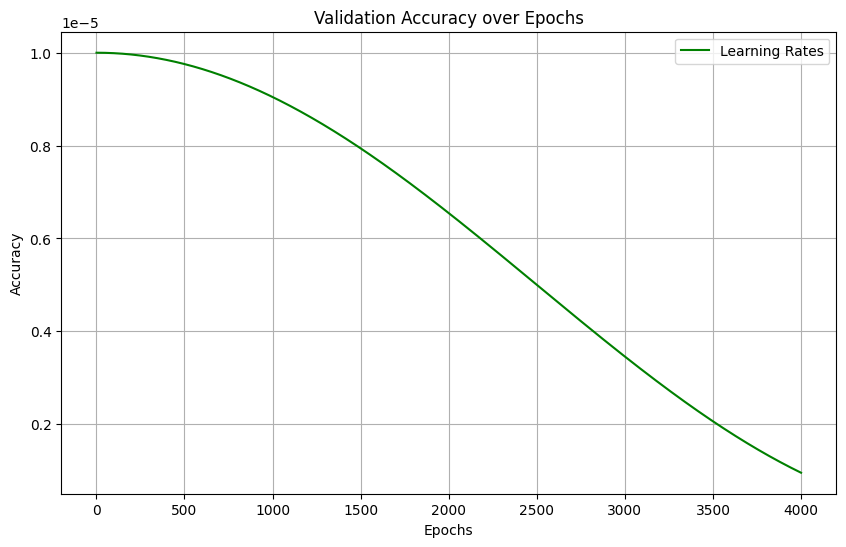

Model for bin 33 saved to GCNModels-5A_exp5/model_bin_33.pth
Training on bin 34/50
Bin 34, Epoch 1/4000, Train Loss: 0.7098, Validation Loss: 0.6551,  Accuracy: 0.7825, LR: 0.000010
Bin 34, Epoch 101/4000, Train Loss: 0.6212, Validation Loss: 0.5984,  Accuracy: 0.8503, LR: 0.000010
Bin 34, Epoch 201/4000, Train Loss: 0.5688, Validation Loss: 0.5481,  Accuracy: 0.8333, LR: 0.000010
Bin 34, Epoch 301/4000, Train Loss: 0.5116, Validation Loss: 0.4888,  Accuracy: 0.8475, LR: 0.000010
Bin 34, Epoch 401/4000, Train Loss: 0.4719, Validation Loss: 0.4318,  Accuracy: 0.8531, LR: 0.000010
Bin 34, Epoch 501/4000, Train Loss: 0.4410, Validation Loss: 0.3724,  Accuracy: 0.8672, LR: 0.000010
Bin 34, Epoch 601/4000, Train Loss: 0.4152, Validation Loss: 0.3428,  Accuracy: 0.8898, LR: 0.000010
Bin 34, Epoch 701/4000, Train Loss: 0.3983, Validation Loss: 0.3511,  Accuracy: 0.8729, LR: 0.000010
Bin 34, Epoch 801/4000, Train Loss: 0.3748, Validation Loss: 0.2878,  Accuracy: 0.8927, LR: 0.000009
Bin 34, Ep

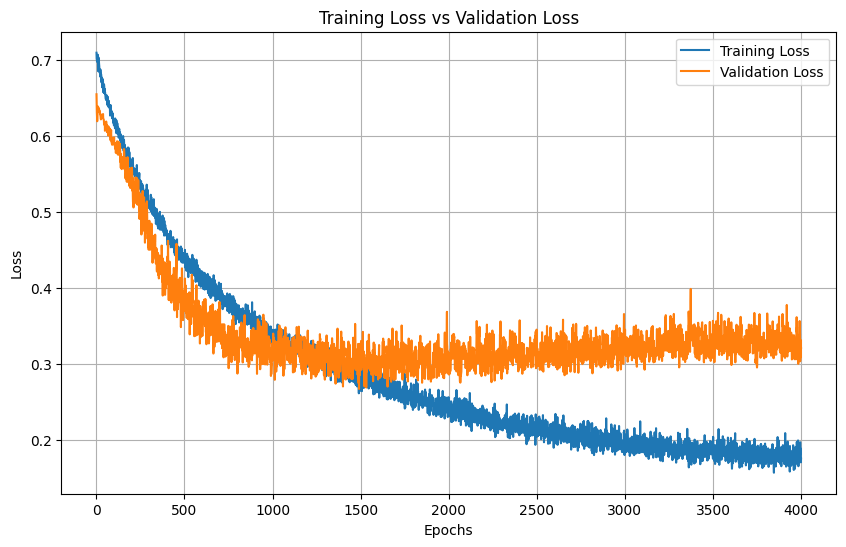

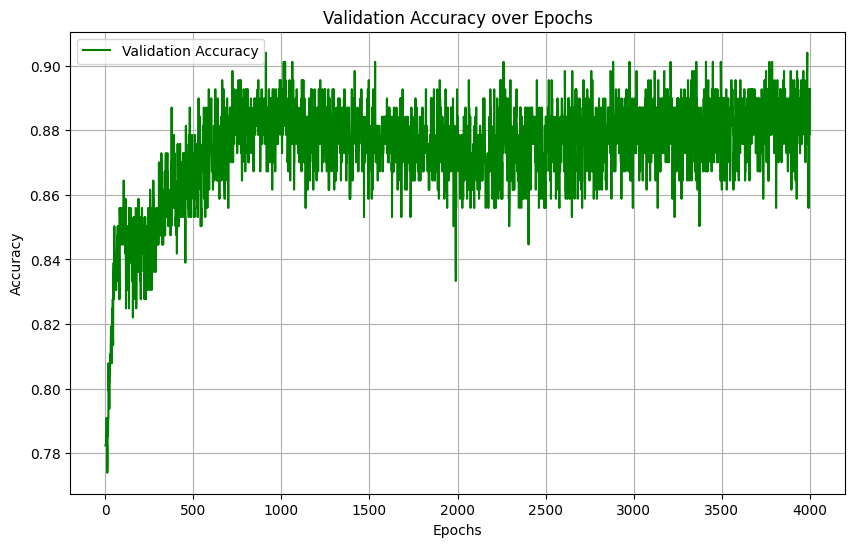

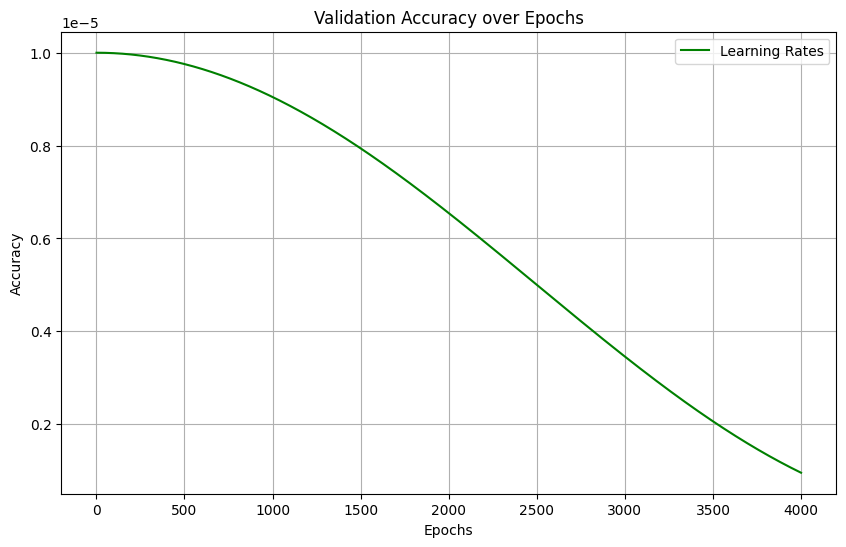

Model for bin 34 saved to GCNModels-5A_exp5/model_bin_34.pth
Training on bin 35/50
Bin 35, Epoch 1/4000, Train Loss: 0.7108, Validation Loss: 0.7105,  Accuracy: 0.2175, LR: 0.000010
Bin 35, Epoch 101/4000, Train Loss: 0.6497, Validation Loss: 0.6657,  Accuracy: 0.6808, LR: 0.000010
Bin 35, Epoch 201/4000, Train Loss: 0.5816, Validation Loss: 0.5925,  Accuracy: 0.8249, LR: 0.000010
Bin 35, Epoch 301/4000, Train Loss: 0.5393, Validation Loss: 0.5484,  Accuracy: 0.8220, LR: 0.000010
Bin 35, Epoch 401/4000, Train Loss: 0.4892, Validation Loss: 0.4951,  Accuracy: 0.8531, LR: 0.000010
Bin 35, Epoch 501/4000, Train Loss: 0.4874, Validation Loss: 0.4434,  Accuracy: 0.8588, LR: 0.000010
Bin 35, Epoch 601/4000, Train Loss: 0.4383, Validation Loss: 0.3915,  Accuracy: 0.8672, LR: 0.000010
Bin 35, Epoch 701/4000, Train Loss: 0.4098, Validation Loss: 0.3644,  Accuracy: 0.8701, LR: 0.000010
Bin 35, Epoch 801/4000, Train Loss: 0.3878, Validation Loss: 0.3737,  Accuracy: 0.8588, LR: 0.000009
Bin 35, Ep

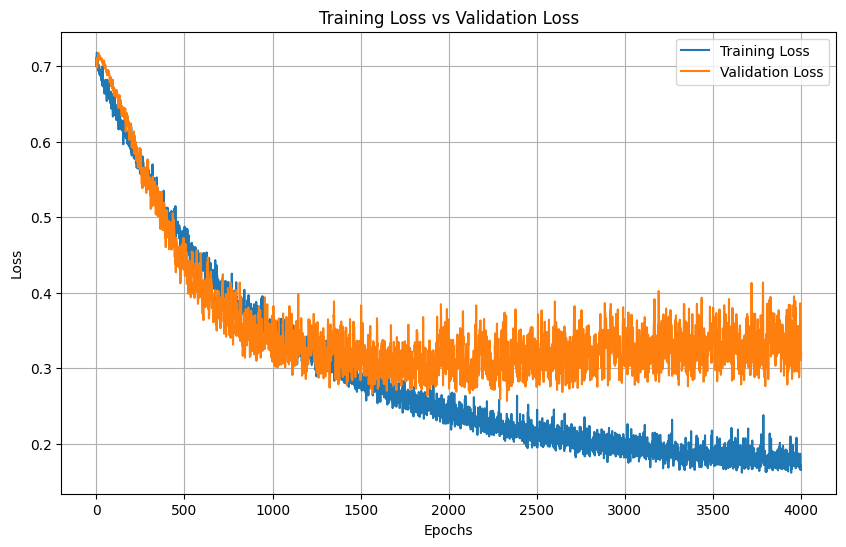

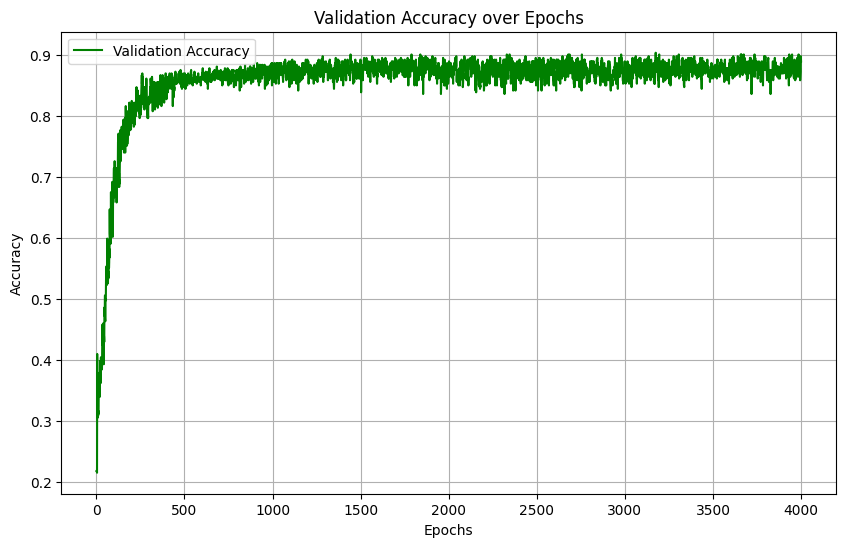

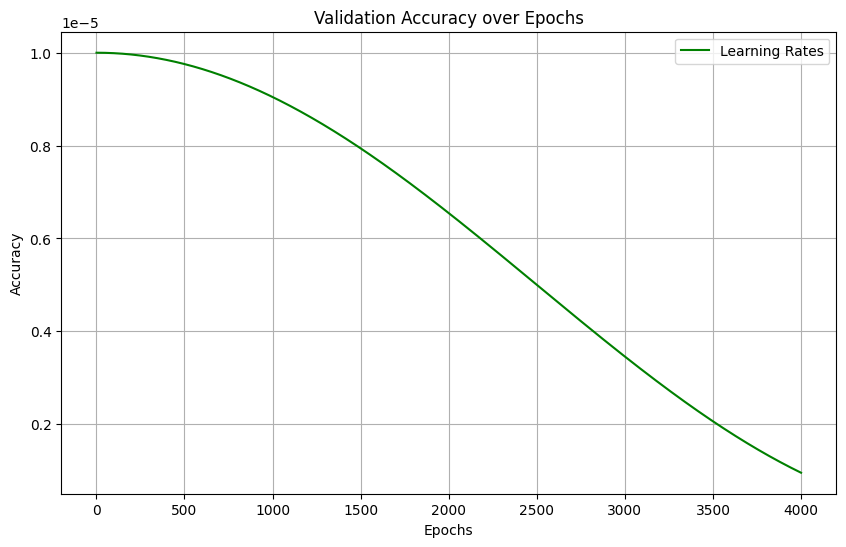

Model for bin 35 saved to GCNModels-5A_exp5/model_bin_35.pth
Training on bin 36/50
Bin 36, Epoch 1/4000, Train Loss: 0.7169, Validation Loss: 0.6765,  Accuracy: 0.7825, LR: 0.000010
Bin 36, Epoch 101/4000, Train Loss: 0.6232, Validation Loss: 0.6238,  Accuracy: 0.8192, LR: 0.000010
Bin 36, Epoch 201/4000, Train Loss: 0.5740, Validation Loss: 0.5539,  Accuracy: 0.8531, LR: 0.000010
Bin 36, Epoch 301/4000, Train Loss: 0.5343, Validation Loss: 0.5113,  Accuracy: 0.8644, LR: 0.000010
Bin 36, Epoch 401/4000, Train Loss: 0.4816, Validation Loss: 0.4563,  Accuracy: 0.8672, LR: 0.000010
Bin 36, Epoch 501/4000, Train Loss: 0.4585, Validation Loss: 0.4379,  Accuracy: 0.8616, LR: 0.000010
Bin 36, Epoch 601/4000, Train Loss: 0.4292, Validation Loss: 0.3980,  Accuracy: 0.8616, LR: 0.000010
Bin 36, Epoch 701/4000, Train Loss: 0.4045, Validation Loss: 0.3554,  Accuracy: 0.8672, LR: 0.000010
Bin 36, Epoch 801/4000, Train Loss: 0.3720, Validation Loss: 0.3160,  Accuracy: 0.8757, LR: 0.000009
Bin 36, Ep

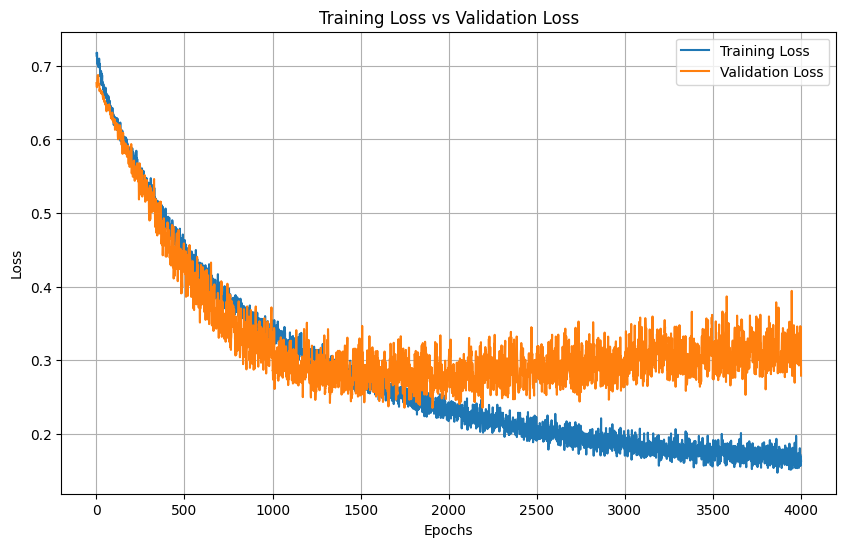

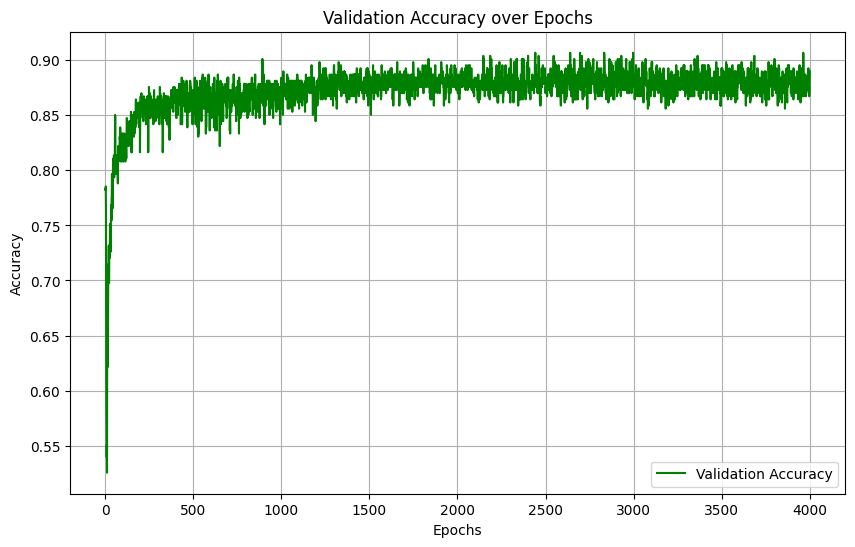

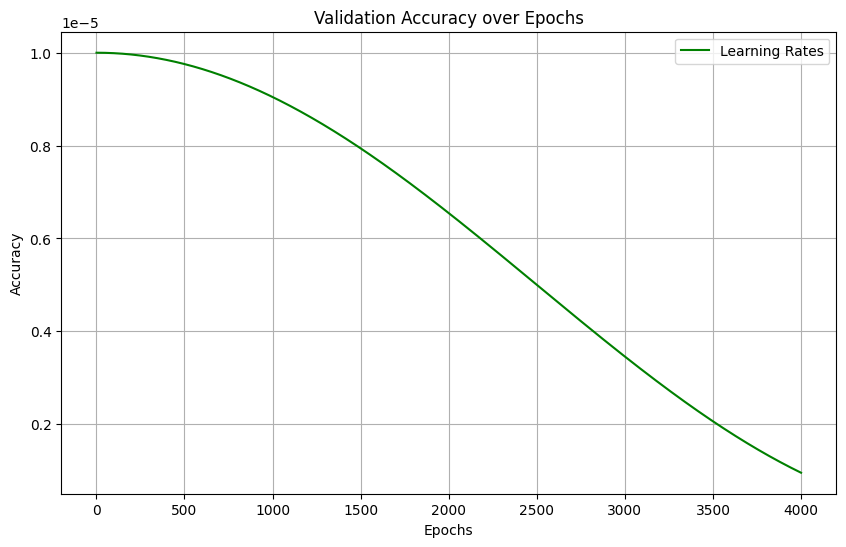

Model for bin 36 saved to GCNModels-5A_exp5/model_bin_36.pth
Training on bin 37/50
Bin 37, Epoch 1/4000, Train Loss: 0.7030, Validation Loss: 0.6945,  Accuracy: 0.2203, LR: 0.000010
Bin 37, Epoch 101/4000, Train Loss: 0.6332, Validation Loss: 0.6240,  Accuracy: 0.8023, LR: 0.000010
Bin 37, Epoch 201/4000, Train Loss: 0.5592, Validation Loss: 0.5485,  Accuracy: 0.8333, LR: 0.000010
Bin 37, Epoch 301/4000, Train Loss: 0.4956, Validation Loss: 0.4929,  Accuracy: 0.8362, LR: 0.000010
Bin 37, Epoch 401/4000, Train Loss: 0.4443, Validation Loss: 0.4181,  Accuracy: 0.8559, LR: 0.000010
Bin 37, Epoch 501/4000, Train Loss: 0.4281, Validation Loss: 0.4142,  Accuracy: 0.8446, LR: 0.000010
Bin 37, Epoch 601/4000, Train Loss: 0.4070, Validation Loss: 0.4239,  Accuracy: 0.8277, LR: 0.000010
Bin 37, Epoch 701/4000, Train Loss: 0.3607, Validation Loss: 0.3803,  Accuracy: 0.8531, LR: 0.000010
Bin 37, Epoch 801/4000, Train Loss: 0.3367, Validation Loss: 0.3751,  Accuracy: 0.8559, LR: 0.000009
Bin 37, Ep

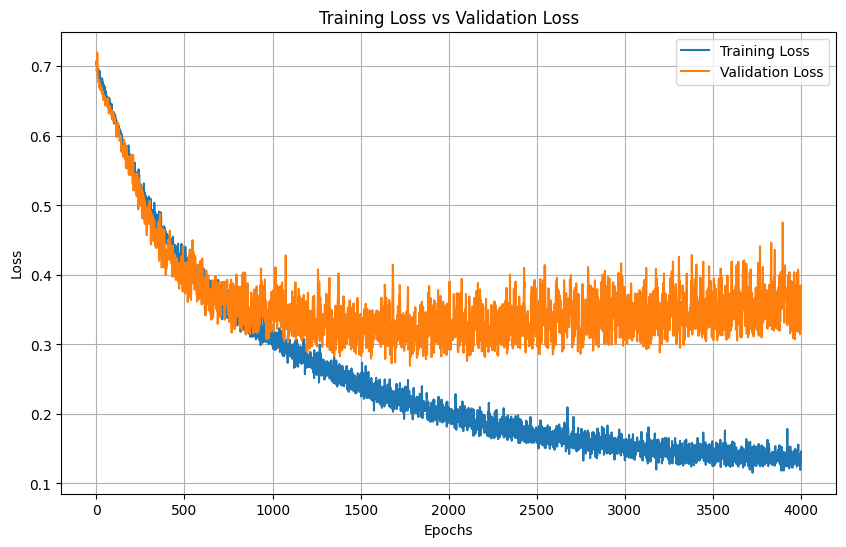

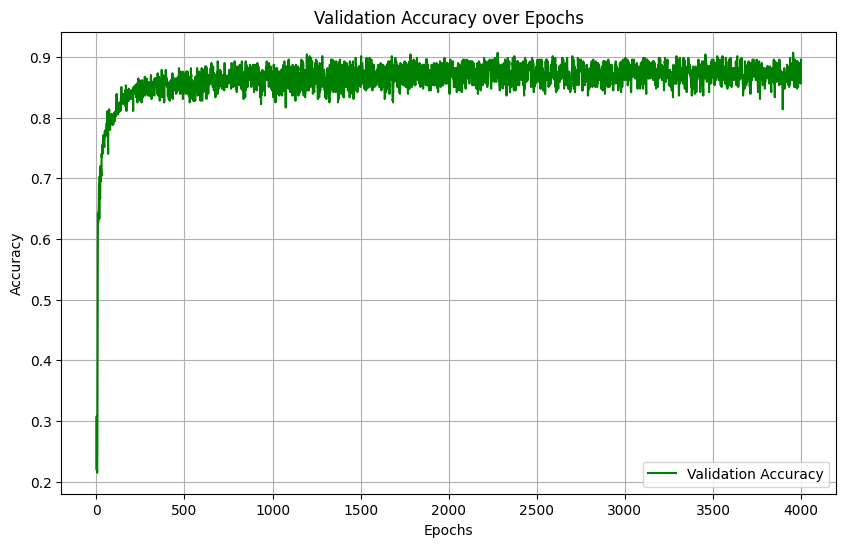

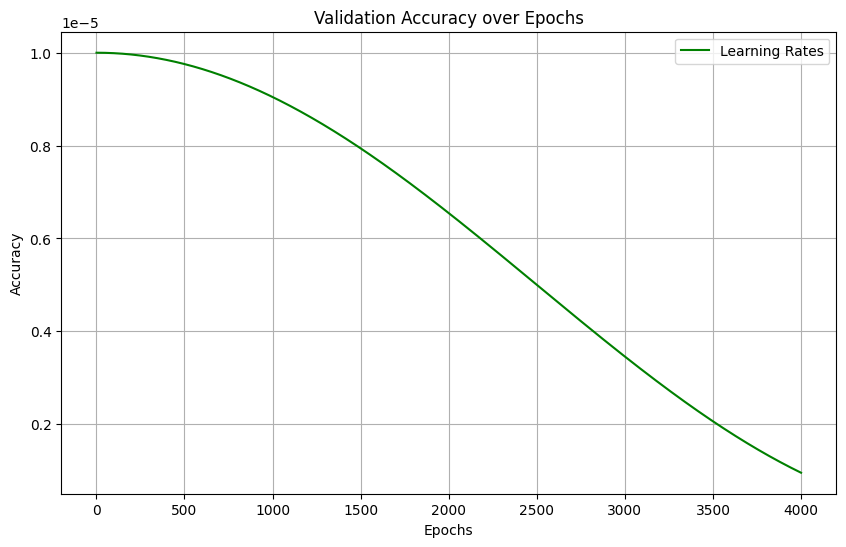

Model for bin 37 saved to GCNModels-5A_exp5/model_bin_37.pth
Training on bin 38/50
Bin 38, Epoch 1/4000, Train Loss: 0.7262, Validation Loss: 0.7104,  Accuracy: 0.2175, LR: 0.000010
Bin 38, Epoch 101/4000, Train Loss: 0.6346, Validation Loss: 0.6428,  Accuracy: 0.7486, LR: 0.000010
Bin 38, Epoch 201/4000, Train Loss: 0.5759, Validation Loss: 0.5921,  Accuracy: 0.7966, LR: 0.000010
Bin 38, Epoch 301/4000, Train Loss: 0.5276, Validation Loss: 0.5056,  Accuracy: 0.8475, LR: 0.000010
Bin 38, Epoch 401/4000, Train Loss: 0.4768, Validation Loss: 0.4449,  Accuracy: 0.8616, LR: 0.000010
Bin 38, Epoch 501/4000, Train Loss: 0.4362, Validation Loss: 0.3893,  Accuracy: 0.8814, LR: 0.000010
Bin 38, Epoch 601/4000, Train Loss: 0.4048, Validation Loss: 0.4002,  Accuracy: 0.8588, LR: 0.000010
Bin 38, Epoch 701/4000, Train Loss: 0.3943, Validation Loss: 0.3486,  Accuracy: 0.8757, LR: 0.000010
Bin 38, Epoch 801/4000, Train Loss: 0.3871, Validation Loss: 0.3246,  Accuracy: 0.8927, LR: 0.000009
Bin 38, Ep

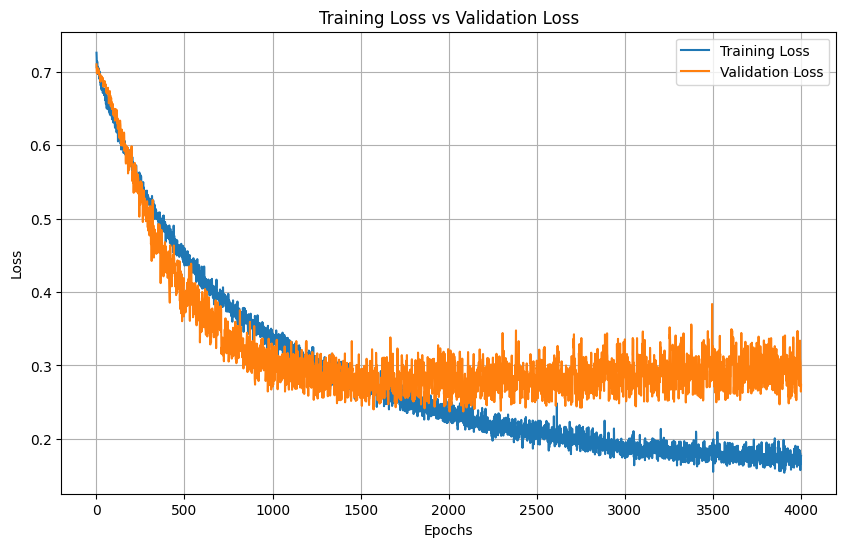

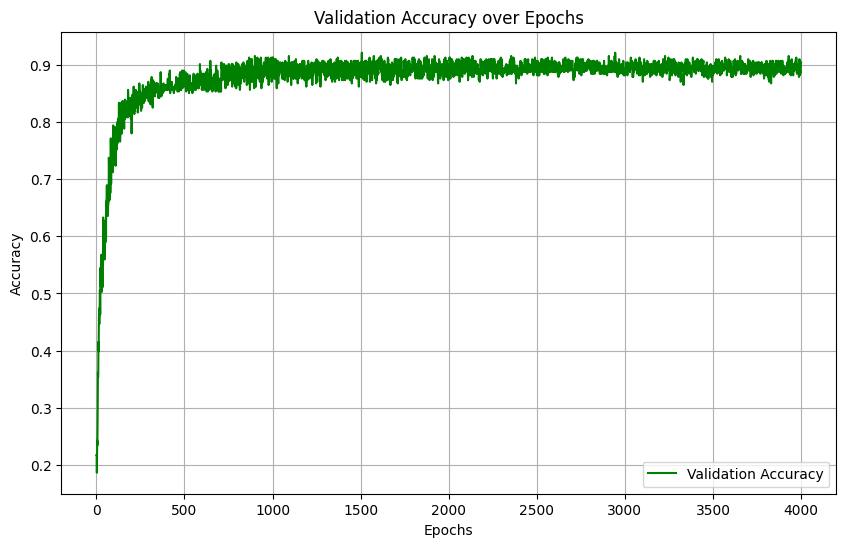

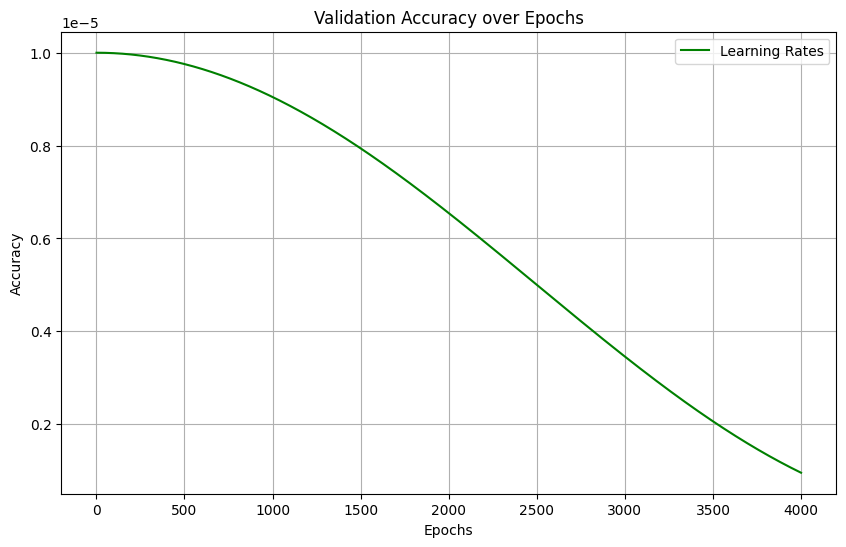

Model for bin 38 saved to GCNModels-5A_exp5/model_bin_38.pth
Training on bin 39/50
Bin 39, Epoch 1/4000, Train Loss: 0.7102, Validation Loss: 0.7037,  Accuracy: 0.2175, LR: 0.000010
Bin 39, Epoch 101/4000, Train Loss: 0.6144, Validation Loss: 0.6416,  Accuracy: 0.7966, LR: 0.000010
Bin 39, Epoch 201/4000, Train Loss: 0.5619, Validation Loss: 0.5688,  Accuracy: 0.8220, LR: 0.000010
Bin 39, Epoch 301/4000, Train Loss: 0.5079, Validation Loss: 0.5138,  Accuracy: 0.8475, LR: 0.000010
Bin 39, Epoch 401/4000, Train Loss: 0.4412, Validation Loss: 0.4877,  Accuracy: 0.8418, LR: 0.000010
Bin 39, Epoch 501/4000, Train Loss: 0.4045, Validation Loss: 0.4033,  Accuracy: 0.8616, LR: 0.000010
Bin 39, Epoch 601/4000, Train Loss: 0.4101, Validation Loss: 0.3918,  Accuracy: 0.8616, LR: 0.000010
Bin 39, Epoch 701/4000, Train Loss: 0.3623, Validation Loss: 0.3734,  Accuracy: 0.8644, LR: 0.000010
Bin 39, Epoch 801/4000, Train Loss: 0.3323, Validation Loss: 0.3277,  Accuracy: 0.8785, LR: 0.000009
Bin 39, Ep

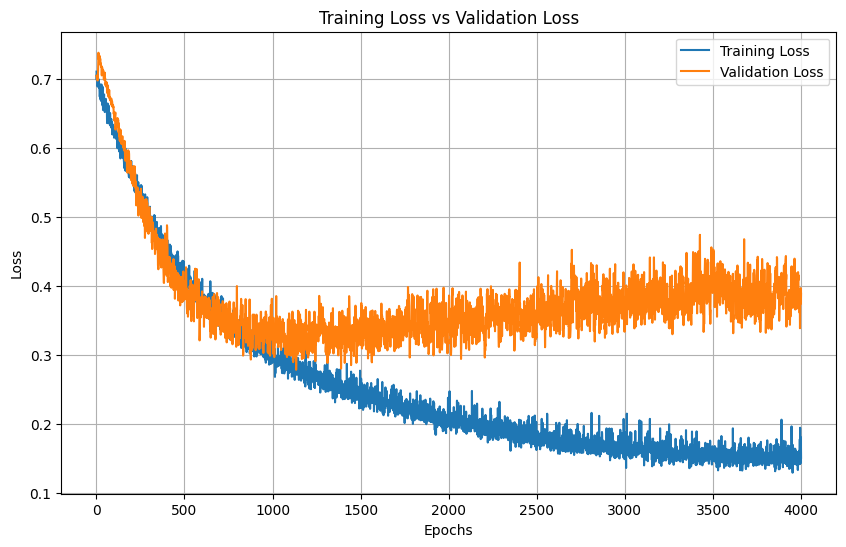

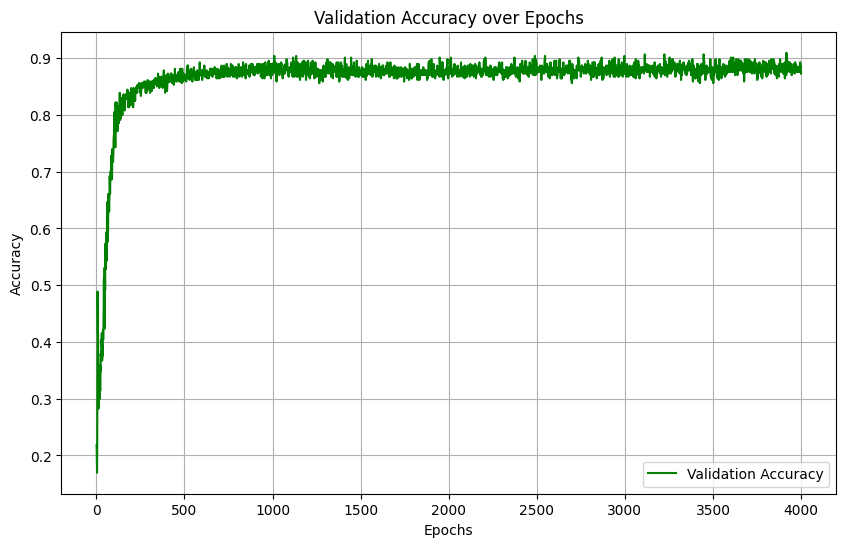

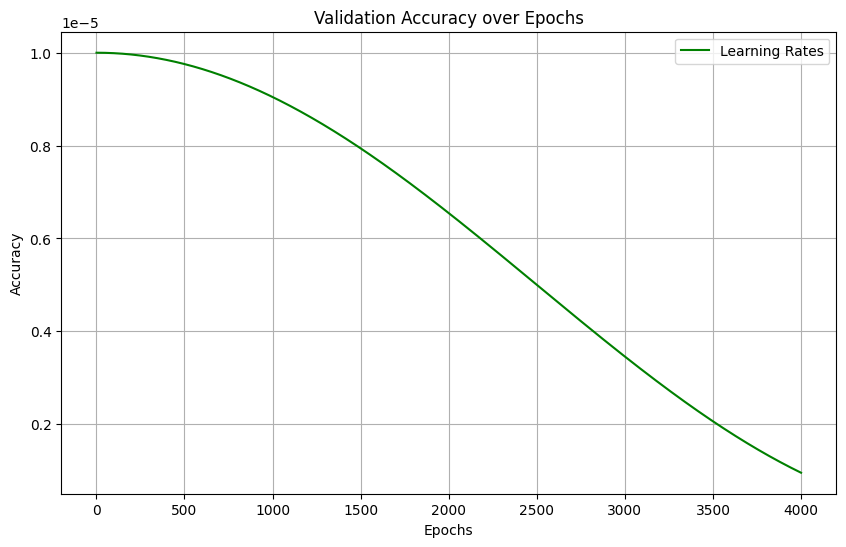

Model for bin 39 saved to GCNModels-5A_exp5/model_bin_39.pth
Training on bin 40/50
Bin 40, Epoch 1/4000, Train Loss: 0.6945, Validation Loss: 0.6908,  Accuracy: 0.7881, LR: 0.000010
Bin 40, Epoch 101/4000, Train Loss: 0.6120, Validation Loss: 0.6851,  Accuracy: 0.7119, LR: 0.000010
Bin 40, Epoch 201/4000, Train Loss: 0.5478, Validation Loss: 0.5928,  Accuracy: 0.8559, LR: 0.000010
Bin 40, Epoch 301/4000, Train Loss: 0.5002, Validation Loss: 0.5557,  Accuracy: 0.8588, LR: 0.000010
Bin 40, Epoch 401/4000, Train Loss: 0.4520, Validation Loss: 0.5200,  Accuracy: 0.8531, LR: 0.000010
Bin 40, Epoch 501/4000, Train Loss: 0.4325, Validation Loss: 0.4986,  Accuracy: 0.8418, LR: 0.000010
Bin 40, Epoch 601/4000, Train Loss: 0.3992, Validation Loss: 0.4658,  Accuracy: 0.8559, LR: 0.000010
Bin 40, Epoch 701/4000, Train Loss: 0.3751, Validation Loss: 0.4098,  Accuracy: 0.8927, LR: 0.000010
Bin 40, Epoch 801/4000, Train Loss: 0.3548, Validation Loss: 0.4114,  Accuracy: 0.8842, LR: 0.000009
Bin 40, Ep

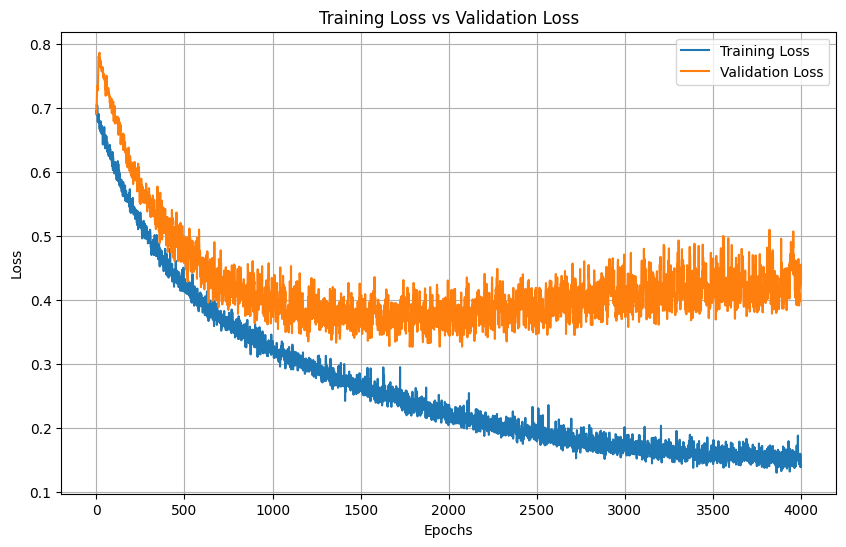

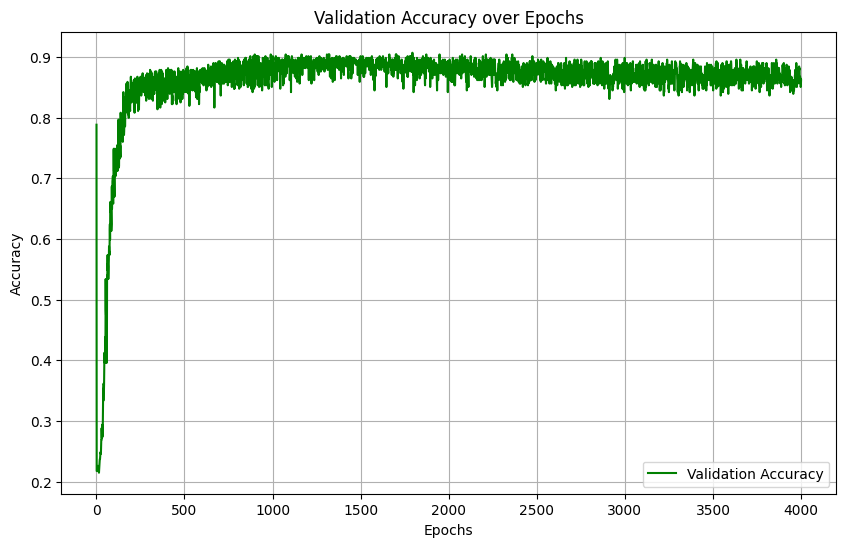

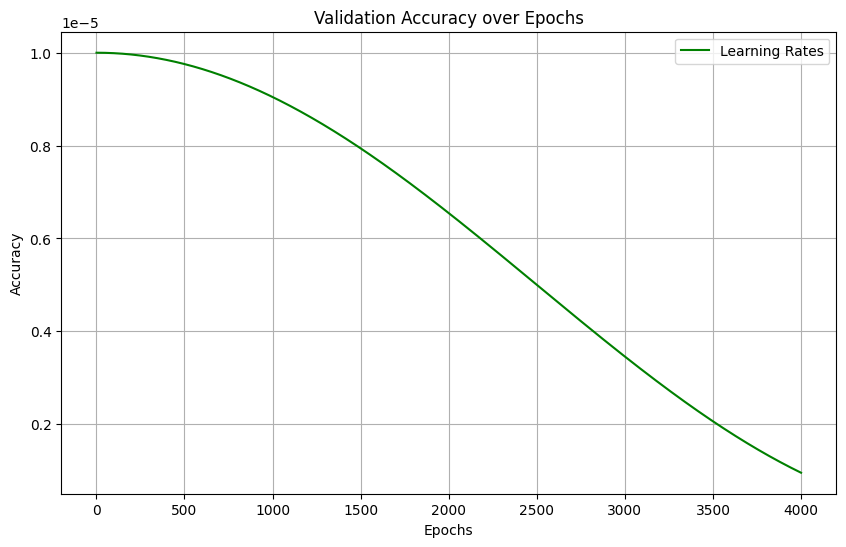

Model for bin 40 saved to GCNModels-5A_exp5/model_bin_40.pth
Training on bin 41/50
Bin 41, Epoch 1/4000, Train Loss: 0.6972, Validation Loss: 0.6939,  Accuracy: 0.2175, LR: 0.000010
Bin 41, Epoch 101/4000, Train Loss: 0.6055, Validation Loss: 0.6464,  Accuracy: 0.7655, LR: 0.000010
Bin 41, Epoch 201/4000, Train Loss: 0.5393, Validation Loss: 0.5949,  Accuracy: 0.8305, LR: 0.000010
Bin 41, Epoch 301/4000, Train Loss: 0.4812, Validation Loss: 0.5244,  Accuracy: 0.8616, LR: 0.000010
Bin 41, Epoch 401/4000, Train Loss: 0.4558, Validation Loss: 0.4679,  Accuracy: 0.8701, LR: 0.000010
Bin 41, Epoch 501/4000, Train Loss: 0.4223, Validation Loss: 0.4406,  Accuracy: 0.8757, LR: 0.000010
Bin 41, Epoch 601/4000, Train Loss: 0.4032, Validation Loss: 0.4252,  Accuracy: 0.8757, LR: 0.000010
Bin 41, Epoch 701/4000, Train Loss: 0.3801, Validation Loss: 0.4053,  Accuracy: 0.8757, LR: 0.000010
Bin 41, Epoch 801/4000, Train Loss: 0.3616, Validation Loss: 0.4006,  Accuracy: 0.8842, LR: 0.000009
Bin 41, Ep

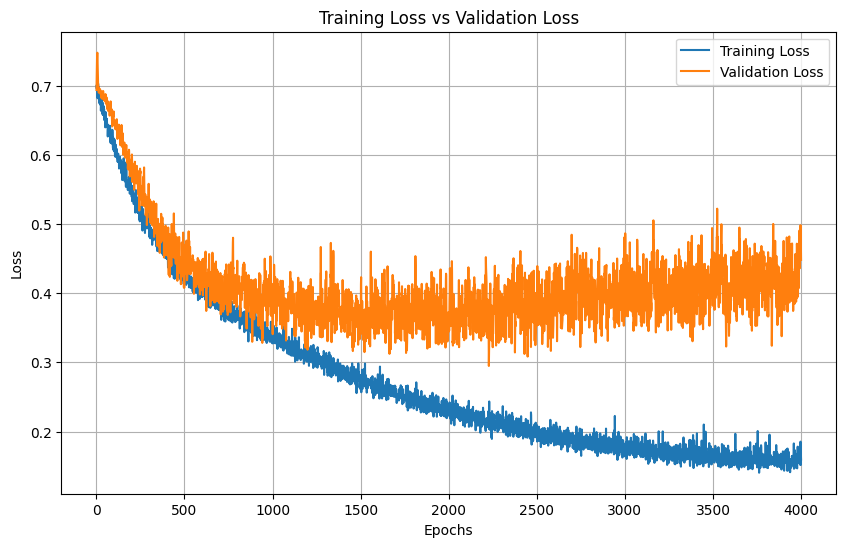

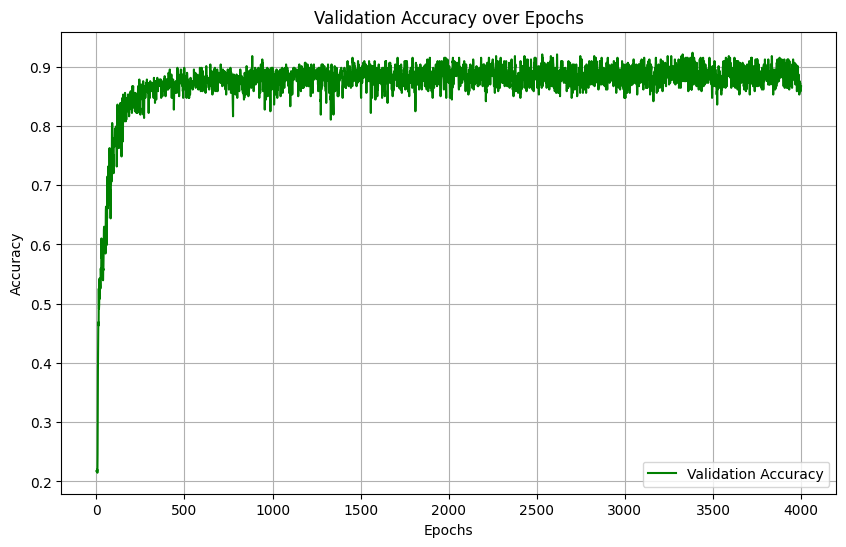

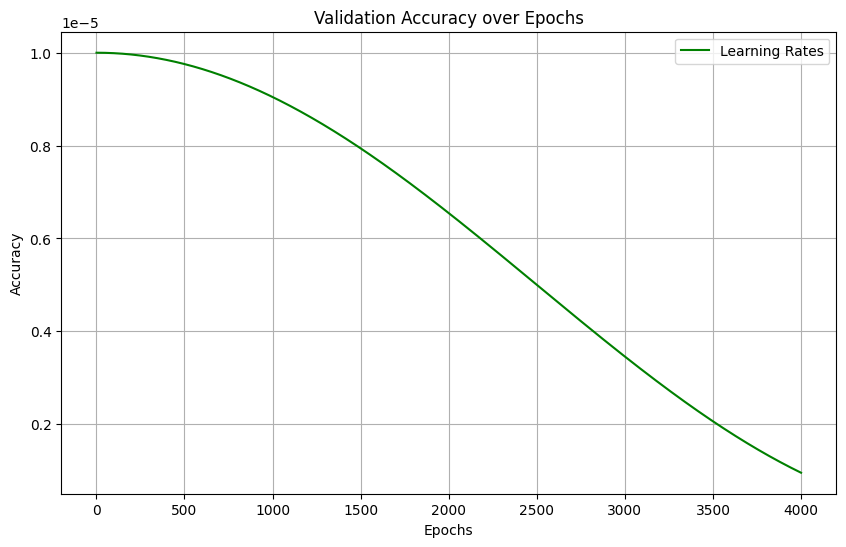

Model for bin 41 saved to GCNModels-5A_exp5/model_bin_41.pth
Training on bin 42/50
Bin 42, Epoch 1/4000, Train Loss: 0.7266, Validation Loss: 0.6998,  Accuracy: 0.2175, LR: 0.000010
Bin 42, Epoch 101/4000, Train Loss: 0.6300, Validation Loss: 0.6812,  Accuracy: 0.6977, LR: 0.000010
Bin 42, Epoch 201/4000, Train Loss: 0.5672, Validation Loss: 0.6236,  Accuracy: 0.8136, LR: 0.000010
Bin 42, Epoch 301/4000, Train Loss: 0.5115, Validation Loss: 0.5385,  Accuracy: 0.8616, LR: 0.000010
Bin 42, Epoch 401/4000, Train Loss: 0.4672, Validation Loss: 0.5144,  Accuracy: 0.8503, LR: 0.000010
Bin 42, Epoch 501/4000, Train Loss: 0.4435, Validation Loss: 0.4842,  Accuracy: 0.8503, LR: 0.000010
Bin 42, Epoch 601/4000, Train Loss: 0.4049, Validation Loss: 0.3870,  Accuracy: 0.8898, LR: 0.000010
Bin 42, Epoch 701/4000, Train Loss: 0.3905, Validation Loss: 0.3985,  Accuracy: 0.8814, LR: 0.000010
Bin 42, Epoch 801/4000, Train Loss: 0.3700, Validation Loss: 0.3902,  Accuracy: 0.8644, LR: 0.000009
Bin 42, Ep

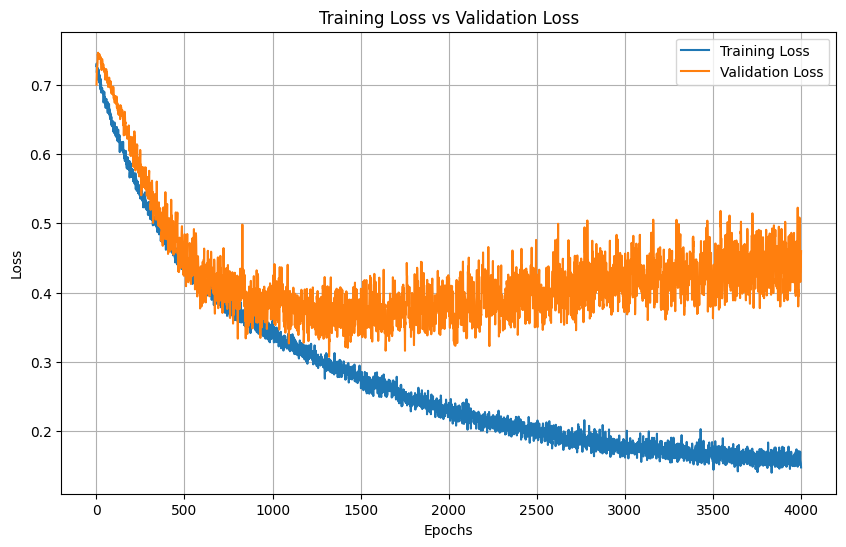

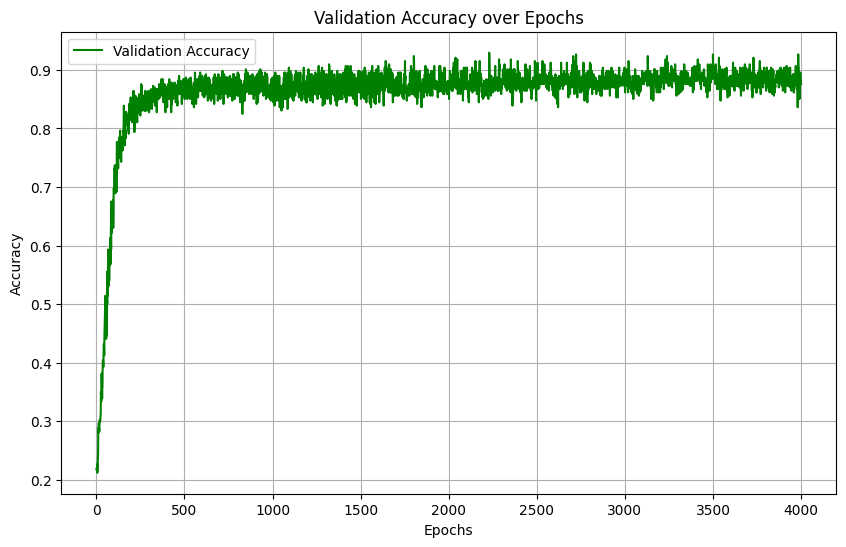

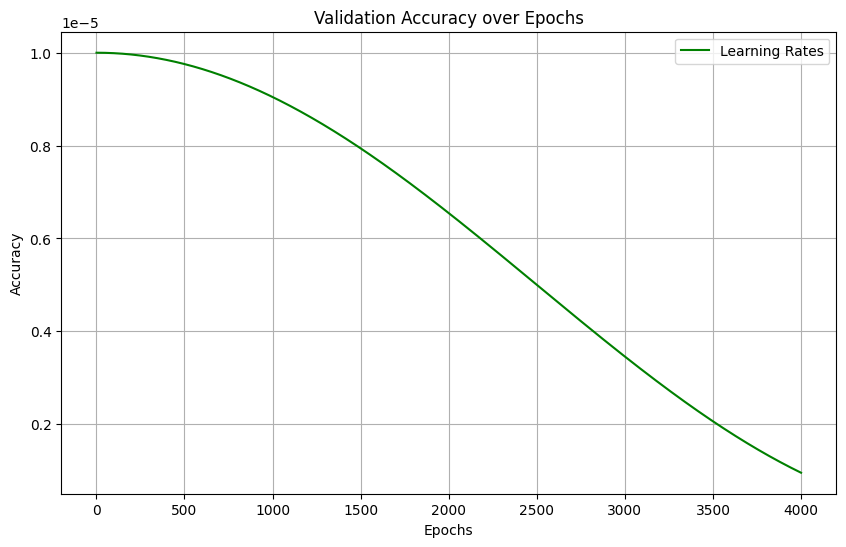

Model for bin 42 saved to GCNModels-5A_exp5/model_bin_42.pth
Training on bin 43/50
Bin 43, Epoch 1/4000, Train Loss: 0.6912, Validation Loss: 0.7170,  Accuracy: 0.2175, LR: 0.000010
Bin 43, Epoch 101/4000, Train Loss: 0.6246, Validation Loss: 0.6515,  Accuracy: 0.6921, LR: 0.000010
Bin 43, Epoch 201/4000, Train Loss: 0.5654, Validation Loss: 0.5771,  Accuracy: 0.7994, LR: 0.000010
Bin 43, Epoch 301/4000, Train Loss: 0.5074, Validation Loss: 0.4901,  Accuracy: 0.8616, LR: 0.000010
Bin 43, Epoch 401/4000, Train Loss: 0.4538, Validation Loss: 0.4433,  Accuracy: 0.8644, LR: 0.000010
Bin 43, Epoch 501/4000, Train Loss: 0.4263, Validation Loss: 0.3849,  Accuracy: 0.8701, LR: 0.000010
Bin 43, Epoch 601/4000, Train Loss: 0.3889, Validation Loss: 0.4119,  Accuracy: 0.8672, LR: 0.000010
Bin 43, Epoch 701/4000, Train Loss: 0.3653, Validation Loss: 0.4111,  Accuracy: 0.8672, LR: 0.000010
Bin 43, Epoch 801/4000, Train Loss: 0.3447, Validation Loss: 0.3875,  Accuracy: 0.8729, LR: 0.000009
Bin 43, Ep

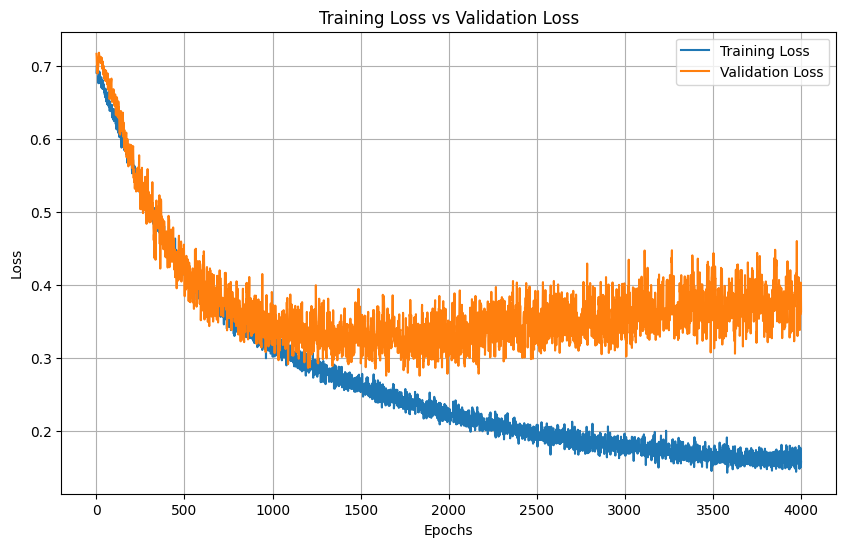

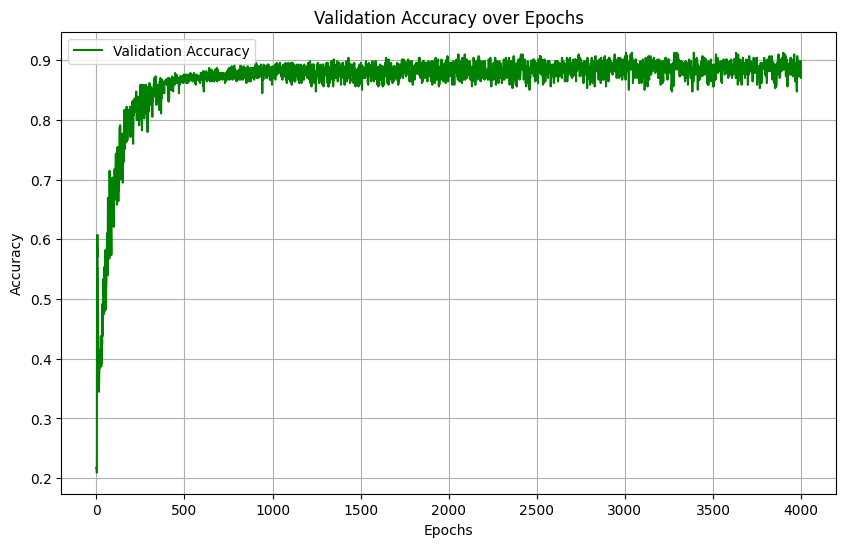

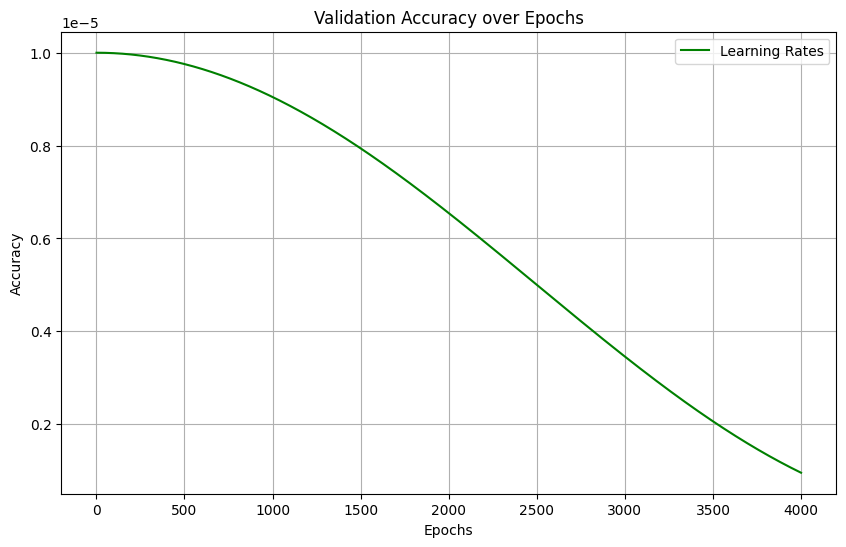

Model for bin 43 saved to GCNModels-5A_exp5/model_bin_43.pth
Training on bin 44/50
Bin 44, Epoch 1/4000, Train Loss: 0.6934, Validation Loss: 0.7232,  Accuracy: 0.2175, LR: 0.000010
Bin 44, Epoch 101/4000, Train Loss: 0.6332, Validation Loss: 0.6813,  Accuracy: 0.6525, LR: 0.000010
Bin 44, Epoch 201/4000, Train Loss: 0.5742, Validation Loss: 0.6287,  Accuracy: 0.7655, LR: 0.000010
Bin 44, Epoch 301/4000, Train Loss: 0.5278, Validation Loss: 0.5614,  Accuracy: 0.8023, LR: 0.000010
Bin 44, Epoch 401/4000, Train Loss: 0.4860, Validation Loss: 0.4967,  Accuracy: 0.8446, LR: 0.000010
Bin 44, Epoch 501/4000, Train Loss: 0.4660, Validation Loss: 0.4866,  Accuracy: 0.8475, LR: 0.000010
Bin 44, Epoch 601/4000, Train Loss: 0.4204, Validation Loss: 0.4513,  Accuracy: 0.8503, LR: 0.000010
Bin 44, Epoch 701/4000, Train Loss: 0.4170, Validation Loss: 0.4197,  Accuracy: 0.8644, LR: 0.000010
Bin 44, Epoch 801/4000, Train Loss: 0.3722, Validation Loss: 0.4436,  Accuracy: 0.8616, LR: 0.000009
Bin 44, Ep

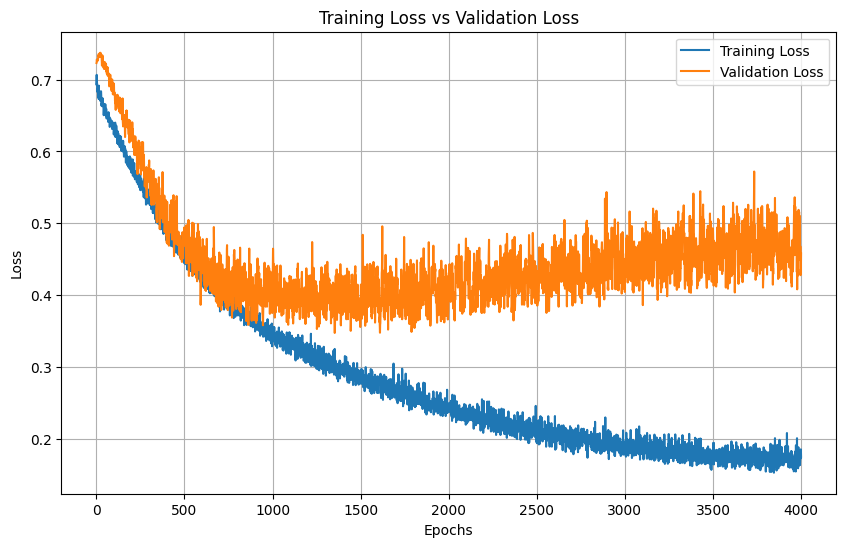

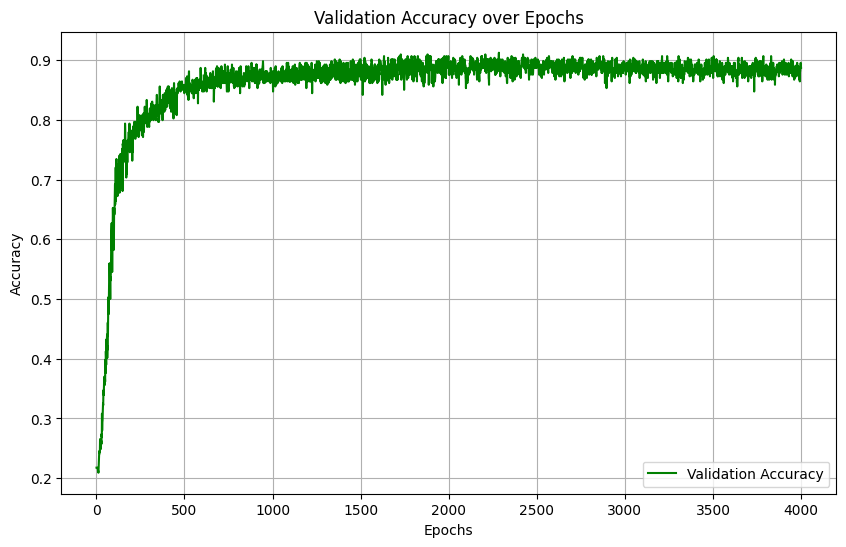

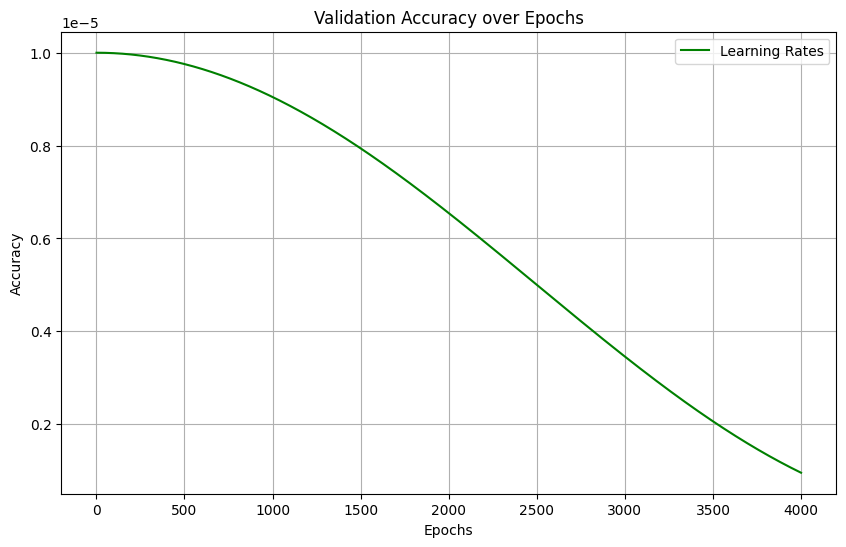

Model for bin 44 saved to GCNModels-5A_exp5/model_bin_44.pth
Training on bin 45/50
Bin 45, Epoch 1/4000, Train Loss: 0.6902, Validation Loss: 0.6891,  Accuracy: 0.7825, LR: 0.000010
Bin 45, Epoch 101/4000, Train Loss: 0.6392, Validation Loss: 0.6236,  Accuracy: 0.7740, LR: 0.000010
Bin 45, Epoch 201/4000, Train Loss: 0.5778, Validation Loss: 0.5530,  Accuracy: 0.8079, LR: 0.000010
Bin 45, Epoch 301/4000, Train Loss: 0.5529, Validation Loss: 0.4739,  Accuracy: 0.8588, LR: 0.000010
Bin 45, Epoch 401/4000, Train Loss: 0.5209, Validation Loss: 0.4311,  Accuracy: 0.8531, LR: 0.000010
Bin 45, Epoch 501/4000, Train Loss: 0.4833, Validation Loss: 0.4282,  Accuracy: 0.8531, LR: 0.000010
Bin 45, Epoch 601/4000, Train Loss: 0.4620, Validation Loss: 0.3541,  Accuracy: 0.8701, LR: 0.000010
Bin 45, Epoch 701/4000, Train Loss: 0.4299, Validation Loss: 0.3763,  Accuracy: 0.8729, LR: 0.000010
Bin 45, Epoch 801/4000, Train Loss: 0.4155, Validation Loss: 0.3237,  Accuracy: 0.8757, LR: 0.000009
Bin 45, Ep

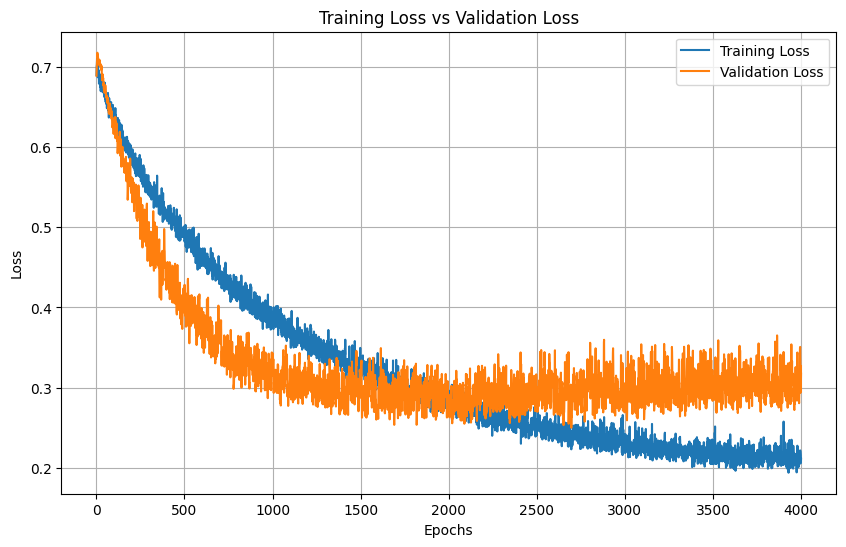

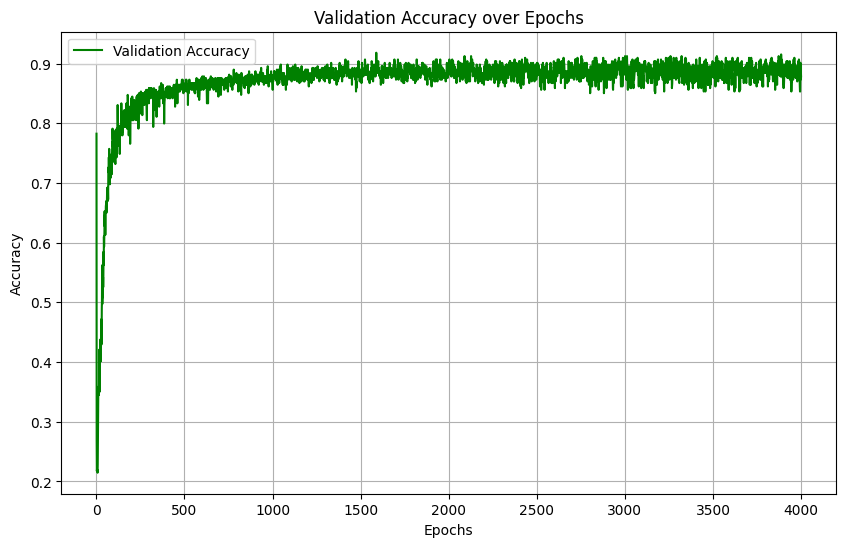

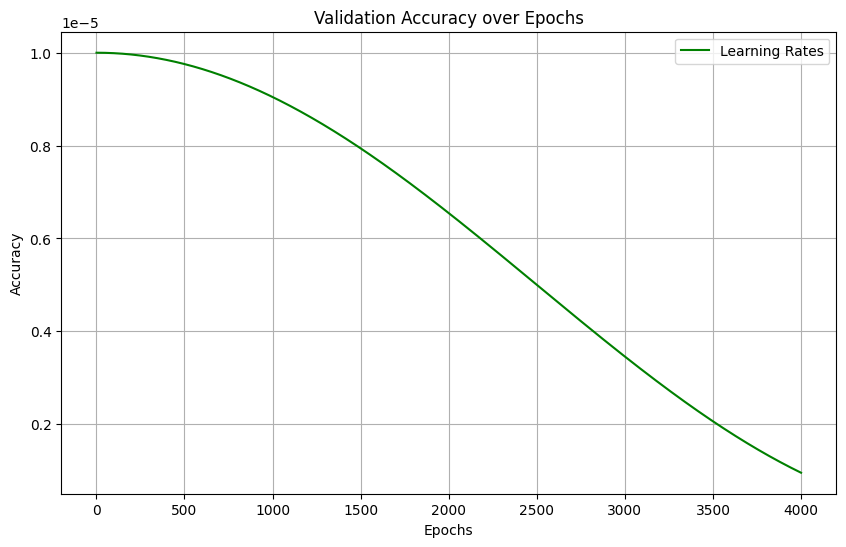

Model for bin 45 saved to GCNModels-5A_exp5/model_bin_45.pth
Training on bin 46/50
Bin 46, Epoch 1/4000, Train Loss: 0.7047, Validation Loss: 0.6987,  Accuracy: 0.2147, LR: 0.000010
Bin 46, Epoch 101/4000, Train Loss: 0.6266, Validation Loss: 0.6243,  Accuracy: 0.8164, LR: 0.000010
Bin 46, Epoch 201/4000, Train Loss: 0.5647, Validation Loss: 0.5318,  Accuracy: 0.8588, LR: 0.000010
Bin 46, Epoch 301/4000, Train Loss: 0.5257, Validation Loss: 0.4518,  Accuracy: 0.8729, LR: 0.000010
Bin 46, Epoch 401/4000, Train Loss: 0.4752, Validation Loss: 0.4380,  Accuracy: 0.8616, LR: 0.000010
Bin 46, Epoch 501/4000, Train Loss: 0.4456, Validation Loss: 0.3966,  Accuracy: 0.8785, LR: 0.000010
Bin 46, Epoch 601/4000, Train Loss: 0.4141, Validation Loss: 0.3632,  Accuracy: 0.8785, LR: 0.000010
Bin 46, Epoch 701/4000, Train Loss: 0.3987, Validation Loss: 0.3618,  Accuracy: 0.8644, LR: 0.000010
Bin 46, Epoch 801/4000, Train Loss: 0.3865, Validation Loss: 0.2946,  Accuracy: 0.8814, LR: 0.000009
Bin 46, Ep

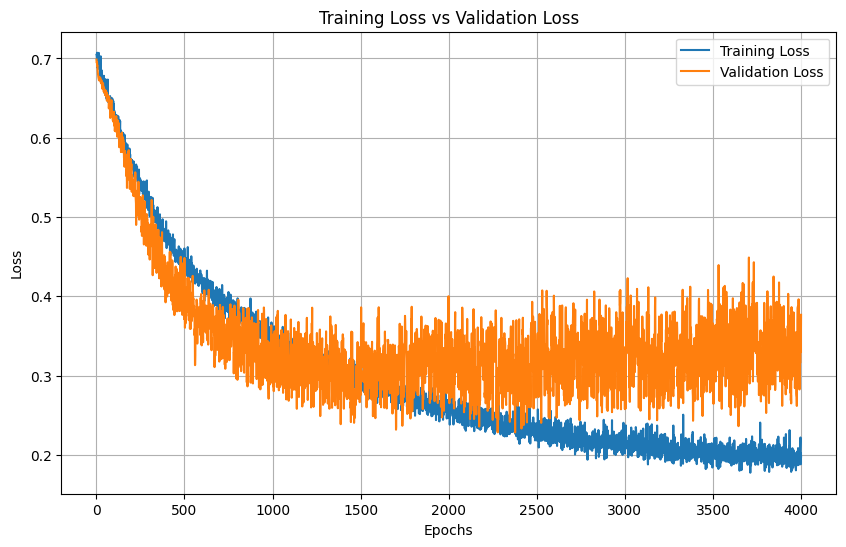

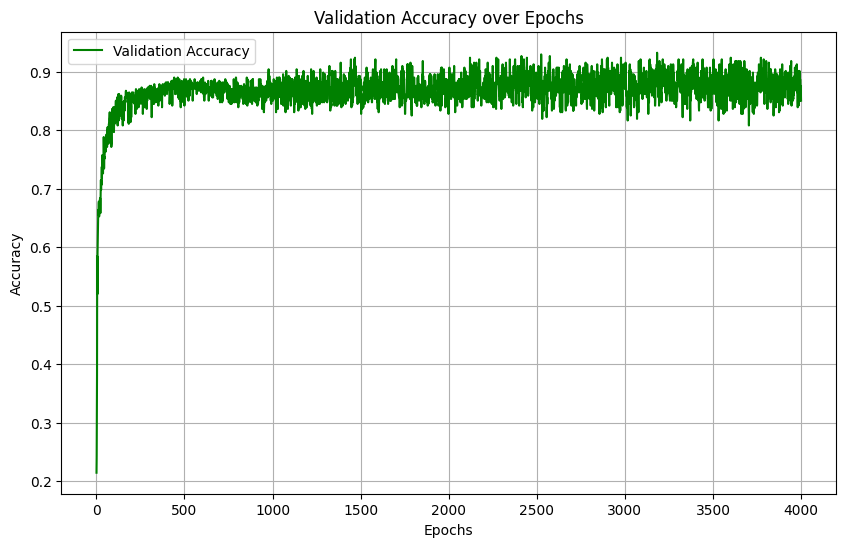

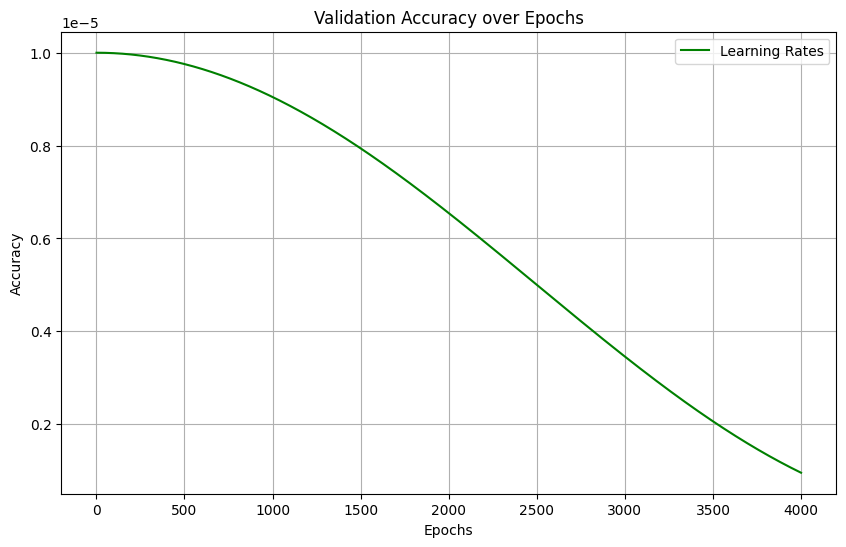

Model for bin 46 saved to GCNModels-5A_exp5/model_bin_46.pth
Training on bin 47/50
Bin 47, Epoch 1/4000, Train Loss: 0.7225, Validation Loss: 0.7083,  Accuracy: 0.2175, LR: 0.000010
Bin 47, Epoch 101/4000, Train Loss: 0.6058, Validation Loss: 0.6489,  Accuracy: 0.7994, LR: 0.000010
Bin 47, Epoch 201/4000, Train Loss: 0.5253, Validation Loss: 0.5791,  Accuracy: 0.8644, LR: 0.000010
Bin 47, Epoch 301/4000, Train Loss: 0.4682, Validation Loss: 0.5049,  Accuracy: 0.8785, LR: 0.000010
Bin 47, Epoch 401/4000, Train Loss: 0.4182, Validation Loss: 0.4650,  Accuracy: 0.8757, LR: 0.000010
Bin 47, Epoch 501/4000, Train Loss: 0.3858, Validation Loss: 0.4412,  Accuracy: 0.8616, LR: 0.000010
Bin 47, Epoch 601/4000, Train Loss: 0.3651, Validation Loss: 0.4144,  Accuracy: 0.8616, LR: 0.000010
Bin 47, Epoch 701/4000, Train Loss: 0.3413, Validation Loss: 0.3676,  Accuracy: 0.8870, LR: 0.000010
Bin 47, Epoch 801/4000, Train Loss: 0.3267, Validation Loss: 0.3505,  Accuracy: 0.8927, LR: 0.000009
Bin 47, Ep

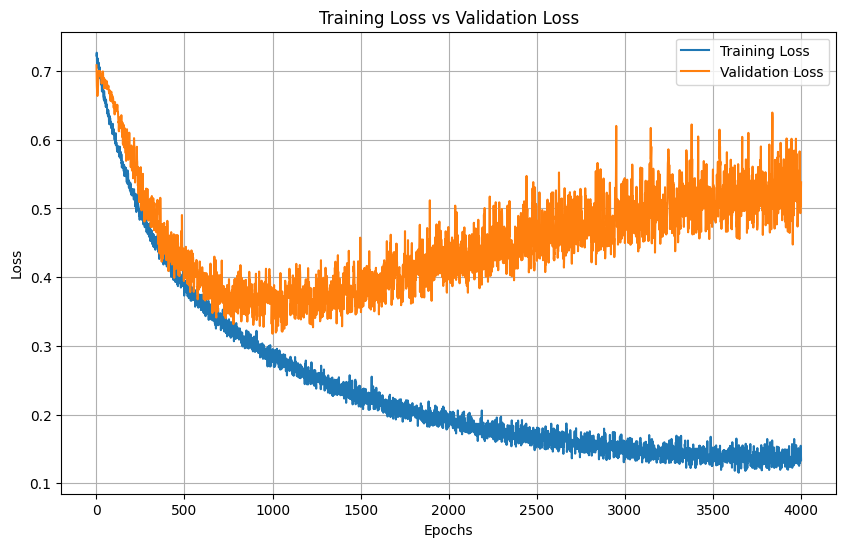

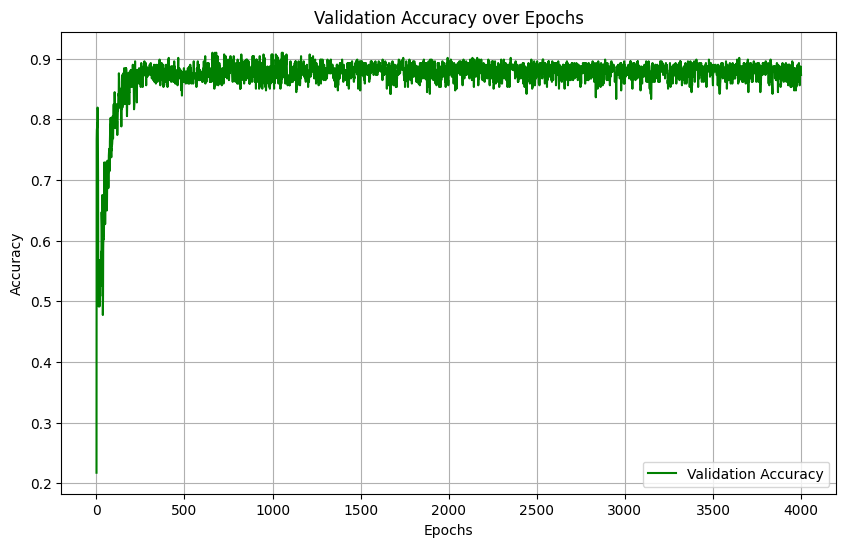

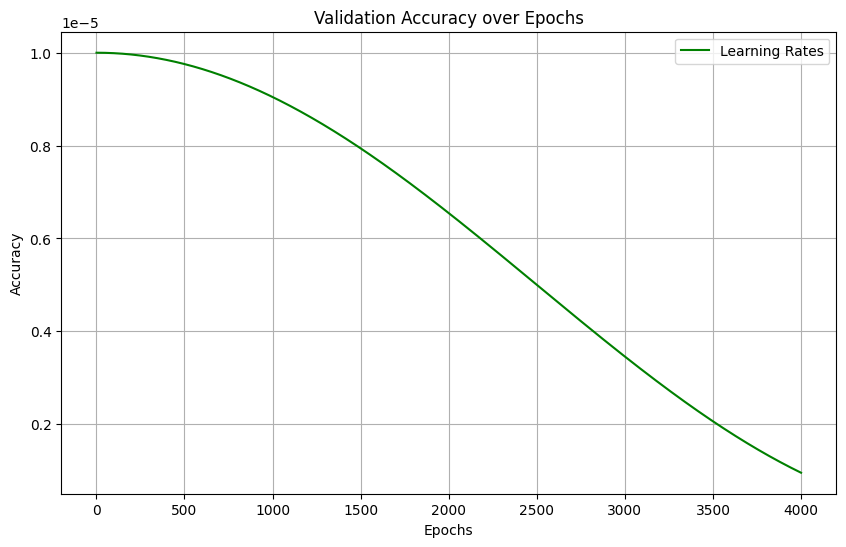

Model for bin 47 saved to GCNModels-5A_exp5/model_bin_47.pth
Training on bin 48/50
Bin 48, Epoch 1/4000, Train Loss: 0.7095, Validation Loss: 0.7104,  Accuracy: 0.2175, LR: 0.000010
Bin 48, Epoch 101/4000, Train Loss: 0.6262, Validation Loss: 0.6782,  Accuracy: 0.6949, LR: 0.000010
Bin 48, Epoch 201/4000, Train Loss: 0.5629, Validation Loss: 0.6220,  Accuracy: 0.8023, LR: 0.000010
Bin 48, Epoch 301/4000, Train Loss: 0.5134, Validation Loss: 0.5393,  Accuracy: 0.8616, LR: 0.000010
Bin 48, Epoch 401/4000, Train Loss: 0.4547, Validation Loss: 0.4923,  Accuracy: 0.8672, LR: 0.000010
Bin 48, Epoch 501/4000, Train Loss: 0.4287, Validation Loss: 0.4311,  Accuracy: 0.8729, LR: 0.000010
Bin 48, Epoch 601/4000, Train Loss: 0.3868, Validation Loss: 0.4423,  Accuracy: 0.8503, LR: 0.000010
Bin 48, Epoch 701/4000, Train Loss: 0.3674, Validation Loss: 0.3733,  Accuracy: 0.8785, LR: 0.000010
Bin 48, Epoch 801/4000, Train Loss: 0.3566, Validation Loss: 0.3688,  Accuracy: 0.8672, LR: 0.000009
Bin 48, Ep

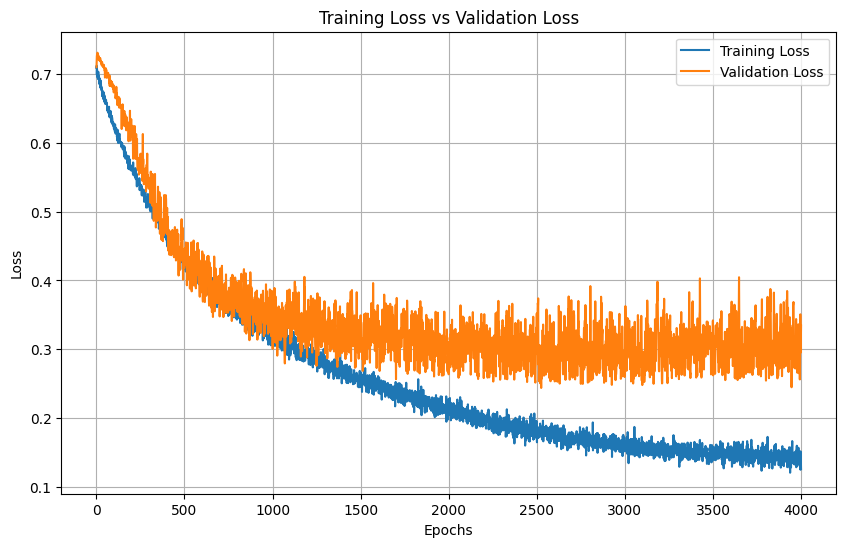

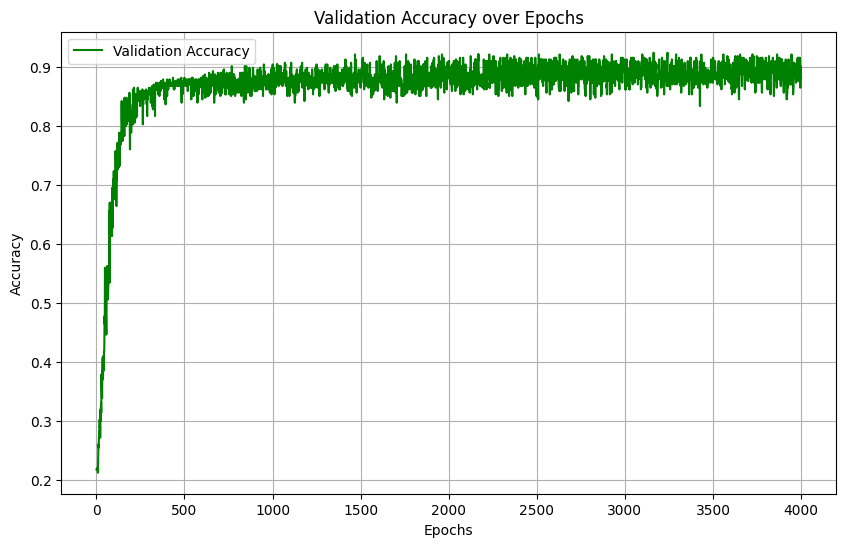

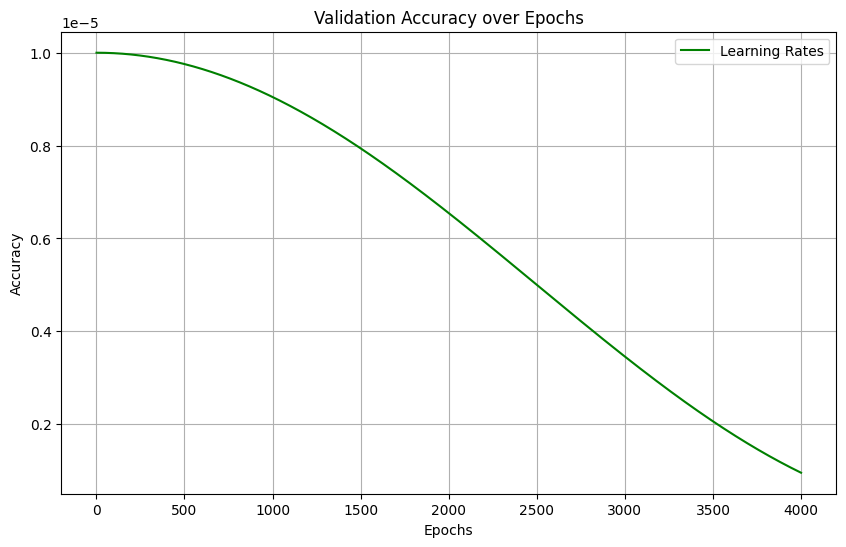

Model for bin 48 saved to GCNModels-5A_exp5/model_bin_48.pth
Training on bin 49/50
Bin 49, Epoch 1/4000, Train Loss: 0.7045, Validation Loss: 0.6855,  Accuracy: 0.7825, LR: 0.000010
Bin 49, Epoch 101/4000, Train Loss: 0.6113, Validation Loss: 0.6228,  Accuracy: 0.8192, LR: 0.000010
Bin 49, Epoch 201/4000, Train Loss: 0.5415, Validation Loss: 0.5570,  Accuracy: 0.8418, LR: 0.000010
Bin 49, Epoch 301/4000, Train Loss: 0.4803, Validation Loss: 0.4943,  Accuracy: 0.8616, LR: 0.000010
Bin 49, Epoch 401/4000, Train Loss: 0.4496, Validation Loss: 0.4525,  Accuracy: 0.8672, LR: 0.000010
Bin 49, Epoch 501/4000, Train Loss: 0.4216, Validation Loss: 0.4580,  Accuracy: 0.8531, LR: 0.000010
Bin 49, Epoch 601/4000, Train Loss: 0.3985, Validation Loss: 0.3691,  Accuracy: 0.9040, LR: 0.000010
Bin 49, Epoch 701/4000, Train Loss: 0.3829, Validation Loss: 0.4009,  Accuracy: 0.8814, LR: 0.000010
Bin 49, Epoch 801/4000, Train Loss: 0.3352, Validation Loss: 0.4283,  Accuracy: 0.8701, LR: 0.000009
Bin 49, Ep

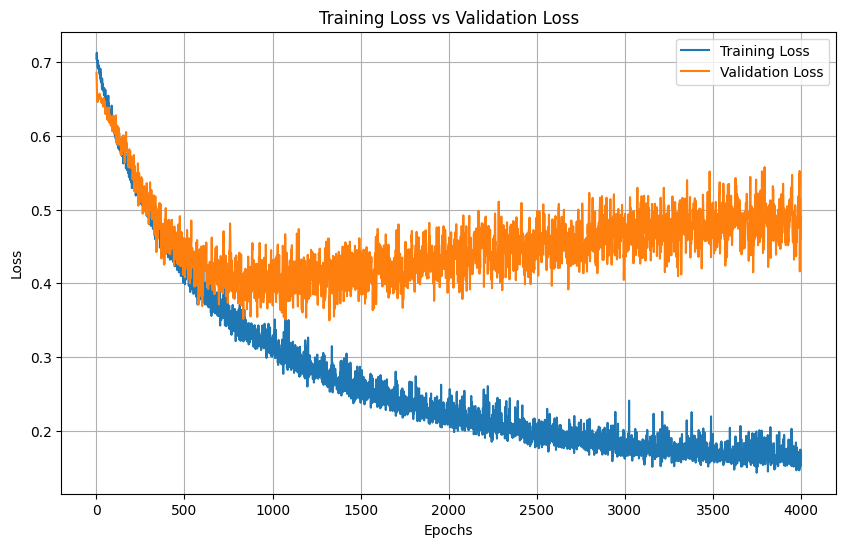

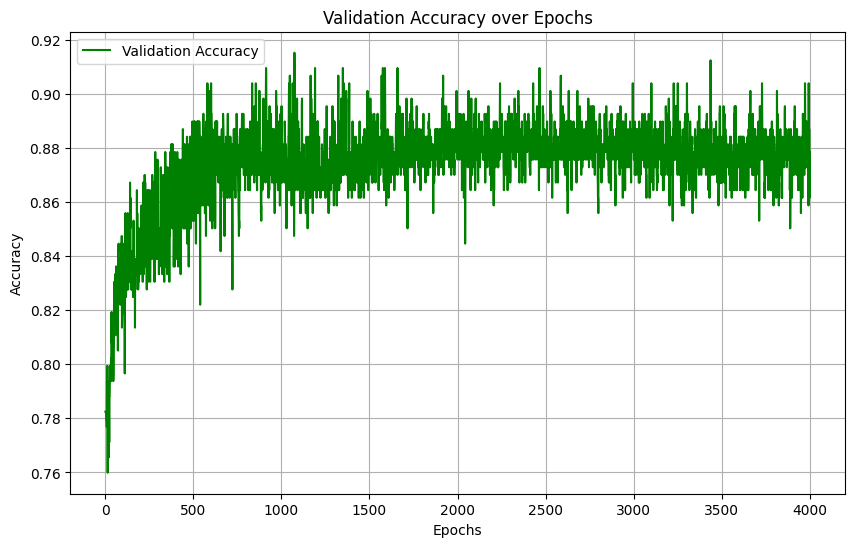

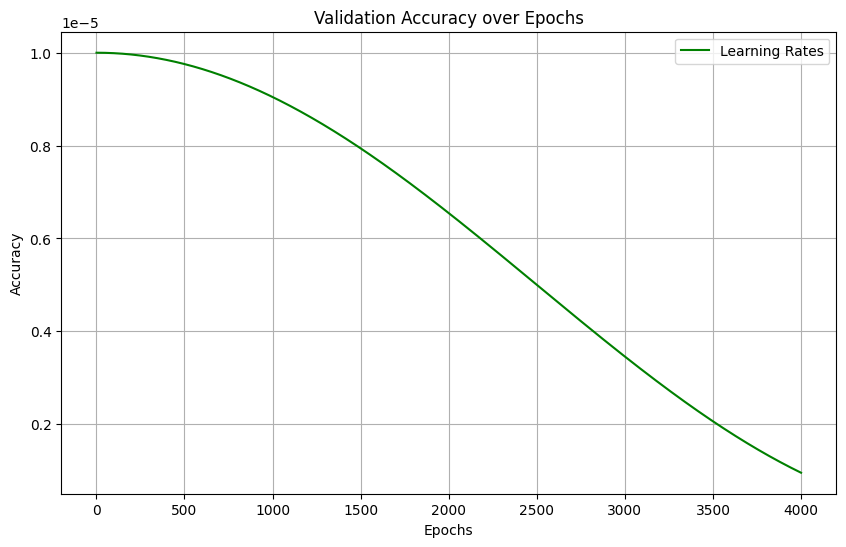

Model for bin 49 saved to GCNModels-5A_exp5/model_bin_49.pth
Training on bin 50/50
Bin 50, Epoch 1/4000, Train Loss: 0.6992, Validation Loss: 0.7207,  Accuracy: 0.2175, LR: 0.000010
Bin 50, Epoch 101/4000, Train Loss: 0.6440, Validation Loss: 0.6714,  Accuracy: 0.6130, LR: 0.000010
Bin 50, Epoch 201/4000, Train Loss: 0.5986, Validation Loss: 0.5728,  Accuracy: 0.8249, LR: 0.000010
Bin 50, Epoch 301/4000, Train Loss: 0.5584, Validation Loss: 0.5374,  Accuracy: 0.8249, LR: 0.000010
Bin 50, Epoch 401/4000, Train Loss: 0.5216, Validation Loss: 0.5150,  Accuracy: 0.8333, LR: 0.000010
Bin 50, Epoch 501/4000, Train Loss: 0.5044, Validation Loss: 0.4415,  Accuracy: 0.8475, LR: 0.000010
Bin 50, Epoch 601/4000, Train Loss: 0.4607, Validation Loss: 0.3847,  Accuracy: 0.8757, LR: 0.000010
Bin 50, Epoch 701/4000, Train Loss: 0.4413, Validation Loss: 0.3660,  Accuracy: 0.8757, LR: 0.000010
Bin 50, Epoch 801/4000, Train Loss: 0.4172, Validation Loss: 0.3317,  Accuracy: 0.8927, LR: 0.000009
Bin 50, Ep

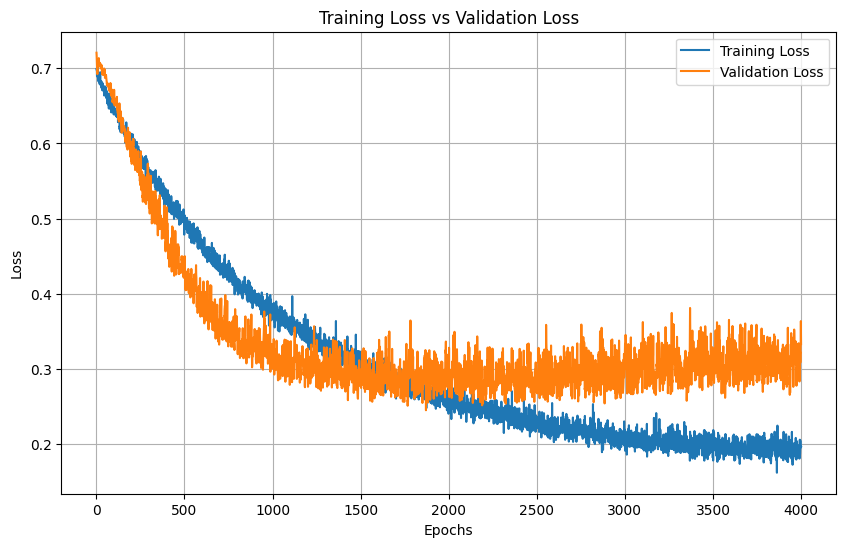

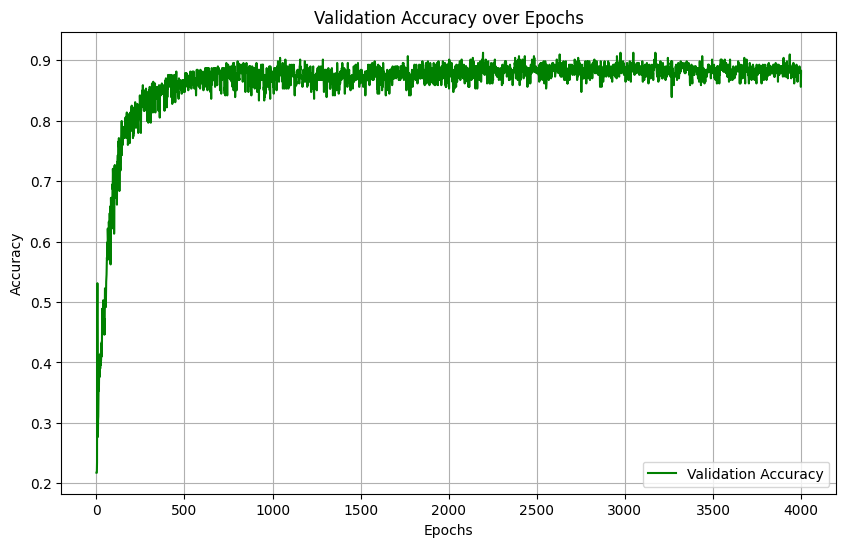

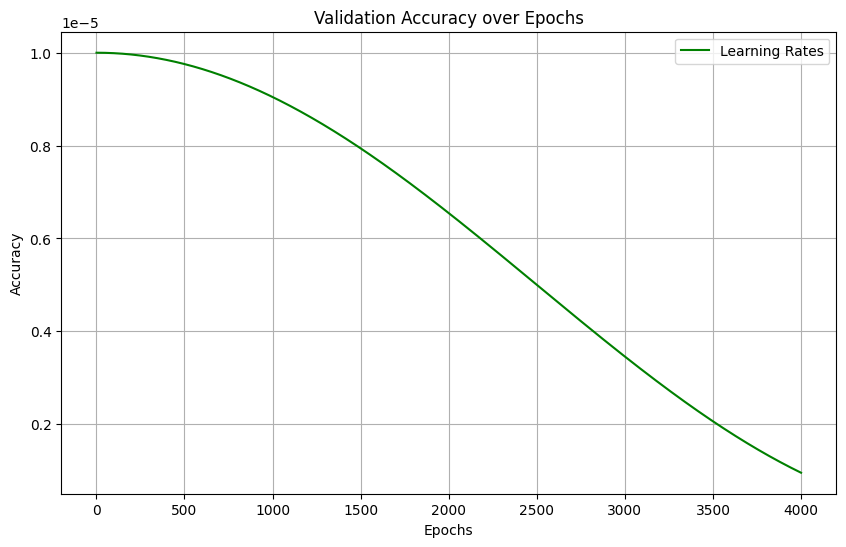

Model for bin 50 saved to GCNModels-5A_exp5/model_bin_50.pth
Training complete.


In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
criterion = nn.BCEWithLogitsLoss()

# Define paths for saving models
save_dir = "GCNModels-5A_exp5"
os.makedirs(f"{save_dir}/Models", exist_ok=True)

# Training loop
epochs = 4000
batch_size = 128

# keep 10 positives and 10 negatives for validation data
val_loader = DataLoader(validation_graphs, batch_size=batch_size, shuffle=False)

for i in range(0, len(bins)):
    model = GCN(input_dim=37).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4) 
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5000, eta_min=1e-10)

    print(f"Training on bin {i+1}/{len(bins)}")
    train_loader = DataLoader(bins[i], batch_size=batch_size, shuffle=True)    

    train_losses = []
    learning_rates = []
    validation_losses = []
    validation_accuracies = []

    for epoch in range(epochs):
        epoch_loss, accuracy = train_model(model, train_loader, criterion, optimizer, device)
        validation_loss, validation_accuracy = validate_model(model, val_loader, criterion, device)
        current_lr = optimizer.param_groups[0]['lr'] 
        train_losses.append(epoch_loss)
        learning_rates.append(current_lr)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)   
        if epoch % 100 == 0:
            print(
                f"Bin {i+1}, Epoch {epoch+1}/{epochs}, "
                f"Train Loss: {epoch_loss:.4f}, Validation Loss: {validation_loss:.4f},  "
                f"Accuracy: {validation_accuracy:.4f}, "
                f"LR: {current_lr:.6f}"
            )

        scheduler.step()

    plot_graphs(train_losses, validation_losses, validation_accuracies, learning_rates)
    
    #Save the trained model
    model_path = os.path.join(save_dir, f"model_bin_{i+1}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model for bin {i+1} saved to {model_path}")

print("Training complete.")